In [8]:
import umap, pywt, random, math, librosa
from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from scipy.stats import *
import numpy as np 
import pandas as pd 
import umap.plot as uplot 
import matplotlib.pyplot as plt 
from glob import glob 
from scipy.signal import * 
from matplotlib import * 
from sklearn.preprocessing import MinMaxScaler 
from mpl_toolkits.mplot3d import Axes3D 

%matplotlib notebook 

In [3]:
plt.rcParams['font.size'] = '16' 


In [4]:
def plot_embeddings(dic_embeddings, order_plot):
    for key in order_plot: 
        embedding = dic_embeddings[key][:, 2:] 
        labels = dic_embeddings[key][:, 0] 

        plt.figure(figsize=(12, 8)) 
        plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='nipy_spectral', s=20) 
        plt.gca().set_aspect('equal', 'datalim') 
        plt.colorbar(boundaries=np.append(np.unique(labels), labels[-1]+1)-0.5).set_ticks(np.unique(labels)) 
        plt.title(key) 


In [5]:
def get_embeddings(files, feat=None, mode='u', n=10, dist=0.1, metric='euclidean', n_components=2, n_epochs=500, markers_concat=[]):
    dic_embeddings = {} 
    dic_data = {} 

    for f in files:
        if(f.endswith('.csv')):
            data = np.loadtxt(f, delimiter=',') 
        elif(f.endswith('.npz')):
            data = np.load(f) 
            data = data[data.files[0]]
        labels = data[:, 0].astype(int) 
        days = data[:, 1].astype(int) 
        parts_f = os.path.basename(f).split('.')[0].split('_')
        if(len(parts_f) > 5):
            key = parts_f[1]+'_'+parts_f[2]
        else:
            key = parts_f[1]
        print(key)
        
        
        if(feat=='freq'):
            features = np.abs(np.fft.fft(data[:, 2:], axis=1))[:, :round((data.shape[1]-2)/2)]  
        elif(feat=='harm'):
            features = get_harmonics(data[:, 2:], n_harmonics=10, fs=100)
        else:
            features = np.copy(data[:, 2:])
            
        
        dic_data[key] = np.hstack((labels[:, np.newaxis], days[:, np.newaxis], features)) 
        reducer = umap.UMAP(random_state=1, n_components=n_components, n_neighbors=n, metric=metric, min_dist=dist, n_epochs=n_epochs)
        
        if(mode=='u'):
            embedding = reducer.fit_transform(features)
            dic_embeddings[key] = np.hstack((labels[:, np.newaxis], days[:, np.newaxis], embedding))
        elif(mode=='s'):
            idxs_train = np.where(days==1)[0]
            idxs_test = np.where(days==2)[0]
            embedding_train = reducer.fit_transform(features[idxs_train])
            embedding_test = reducer.transform(features[idxs_test])

            dic_embeddings[key] = {}
            dic_embeddings[key]['train'] = np.hstack((labels[idxs_train, np.newaxis], days[idxs_train, np.newaxis], embedding_train)) 
            dic_embeddings[key]['test'] = np.hstack((labels[idxs_test, np.newaxis], days[idxs_test, np.newaxis], embedding_test)) 
            
    for subset in markers_concat: 
        subset_name = '_'.join(subset) 
        features = np.hstack(([dic_data[key][:, 2:] for key in subset])) 
        labels = dic_data[subset[0]][:, 0].astype(int) 
        days = dic_data[subset[0]][:, 1].astype(int) 
        reducer = umap.UMAP(random_state=1, n_components=n_components, n_neighbors=n, metric=metric, min_dist=dist, n_epochs=n_epochs) 
        
        if(mode=='u'):
            embedding = reducer.fit_transform(features)
            dic_embeddings[subset_name] = np.hstack((labels[:, np.newaxis], days[:, np.newaxis], embedding))
        elif(mode=='s'):
            idxs_train = np.where(days==1)[0]
            idxs_test = np.where(days==2)[0]
            embedding_train = reducer.fit_transform(features[idxs_train], y=labels[idxs_train]) 
            embedding_test = reducer.transform(features[idxs_test])
            idxs = np.concatenate((idxs_train, idxs_test))
            embedding = np.vstack((embedding_train, embedding_test))
            dic_embeddings[subset_name] = {}
            dic_embeddings[subset_name]['train'] = np.hstack((labels[idxs_train, np.newaxis], days[idxs_train, np.newaxis], embedding_train)) 
            dic_embeddings[subset_name]['test'] = np.hstack((labels[idxs_test, np.newaxis], days[idxs_test, np.newaxis], embedding_test)) 

    return dic_embeddings, dic_data


In [6]:
def generate_pairs(dic_data):
    print("Generating pairs...")
    if(not os.path.isdir("./pairs")):
        os.mkdir("./pairs")
    users = dic_data[list(dic_data.keys())[0]][:, 0].astype(int)
    all_users = np.unique(users)
    np.random.seed(0)
    users_set1 = np.random.choice(all_users, 13, replace=False)
    users_set2 = [u for u in all_users if u not in users_set1]

    idxs_pos = {}
    idxs_neg = {}
    for key in sorted(dic_data.keys()):
        sensor_data = dic_data[key][:, 2:]
        users = dic_data[key][:, 0].astype(int)

        pairs = np.empty((0, 2*sensor_data.shape[1]+2))
        for s, users_set in enumerate([users_set1, users_set2]):
            for idxu, u in enumerate(users_set):
                ratio = 0.2
                users_n = np.delete(users_set, idxu)
                idxs_u = np.where(users==u)[0]
                np.random.seed(0)                
                pairs_pos_u = np.vstack(( [[np.concatenate(([s+1], np.abs(sensor_data[idx])*np.abs(sensor_data[i]), np.abs(sensor_data[idx])-np.abs(sensor_data[i]) )) for i in np.delete(idxs_u, np.where(idxs_u==idx)[0]) ] for idx in idxs_u] ))
                np.random.seed(0)
                pairs_pos_u = pairs_pos_u[np.random.choice(np.arange(len(pairs_pos_u)), int(len(pairs_pos_u)*ratio))]
                
                n_neg = int(math.ceil(len(pairs_pos_u)/len(users_n)/len(idxs_u)))

                np.random.seed(0)
                idxs_users_neg = np.concatenate(([np.random.choice(np.where(users==un)[0], n_neg, replace=False) for un in users_n]))

                if(u not in idxs_neg):
                    np.random.seed(0)
                    idxs_users_neg = np.concatenate(([np.random.choice(np.where(users==un)[0], n_neg, replace=False) for un in users_n]))
                    idxs_neg[u] = idxs_users_neg
                else:
                    idxs_users_neg = idxs_neg[u]
                
                pairs_neg_u = np.vstack(( [ np.hstack(( np.repeat([s+1], len(idxs_users_neg), axis=0)[:, np.newaxis], np.abs(np.repeat(sensor_data[i, np.newaxis], len(idxs_users_neg), axis=0))-np.abs(sensor_data[idxs_users_neg]), np.abs(np.repeat(sensor_data[i, np.newaxis], len(idxs_users_neg), axis=0))*np.abs(sensor_data[idxs_users_neg]) )) for i in idxs_u] ))
                pairs_u = np.vstack(( pairs_pos_u, pairs_neg_u ))
                labels = np.concatenate(( np.ones(len(pairs_pos_u)), np.zeros(len(pairs_neg_u)) ))
                pairs = np.vstack(( pairs, np.hstack((labels[:, np.newaxis], pairs_u)) ))
        print(len(pairs), "pairs generated")
        np.savez_compressed("pairs/pairs_"+key+".npz", pairs.astype(np.float32))
    

In [ ]:
!python3 generate_frames.py -p ./frames -d 1

In [ ]:
files = glob("frames/*.csv")
dic_embeddings, dic_data = get_embeddings(files, feat='freq', mode='u', n=50, dist=0.5)

In [ ]:
generate_pairs(dic_data)

nexus
fme
fle
ftc
fax
imu
ias
ttc
nexus


<IPython.core.display.Javascript object>


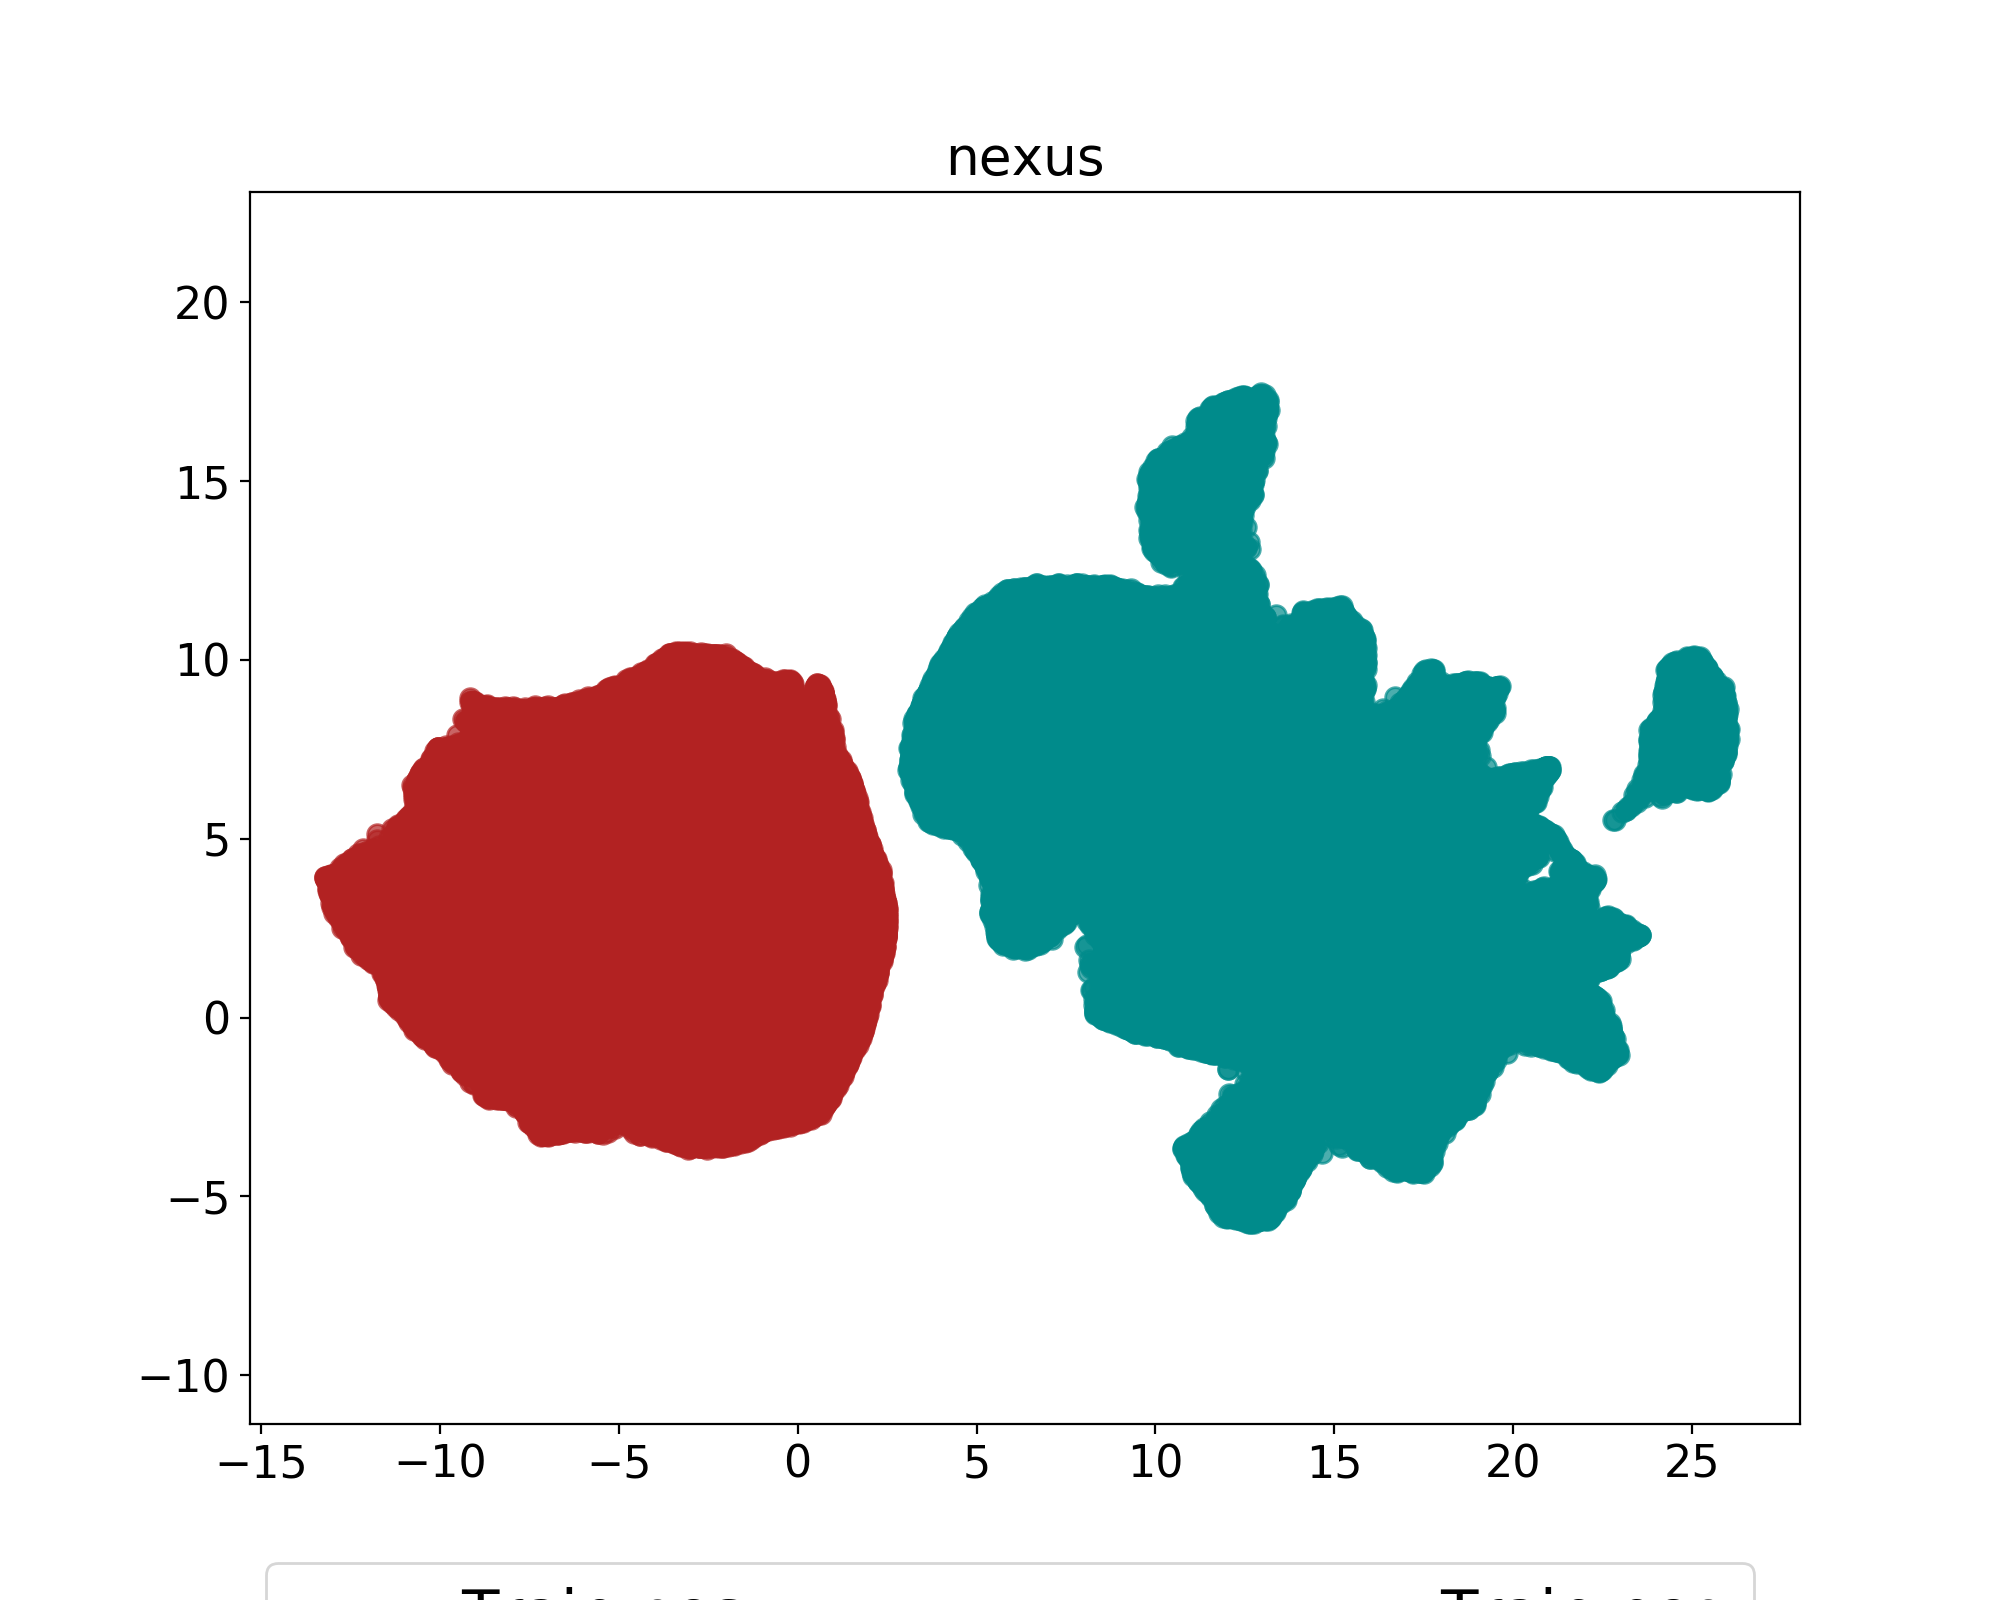

fme


<IPython.core.display.Javascript object>


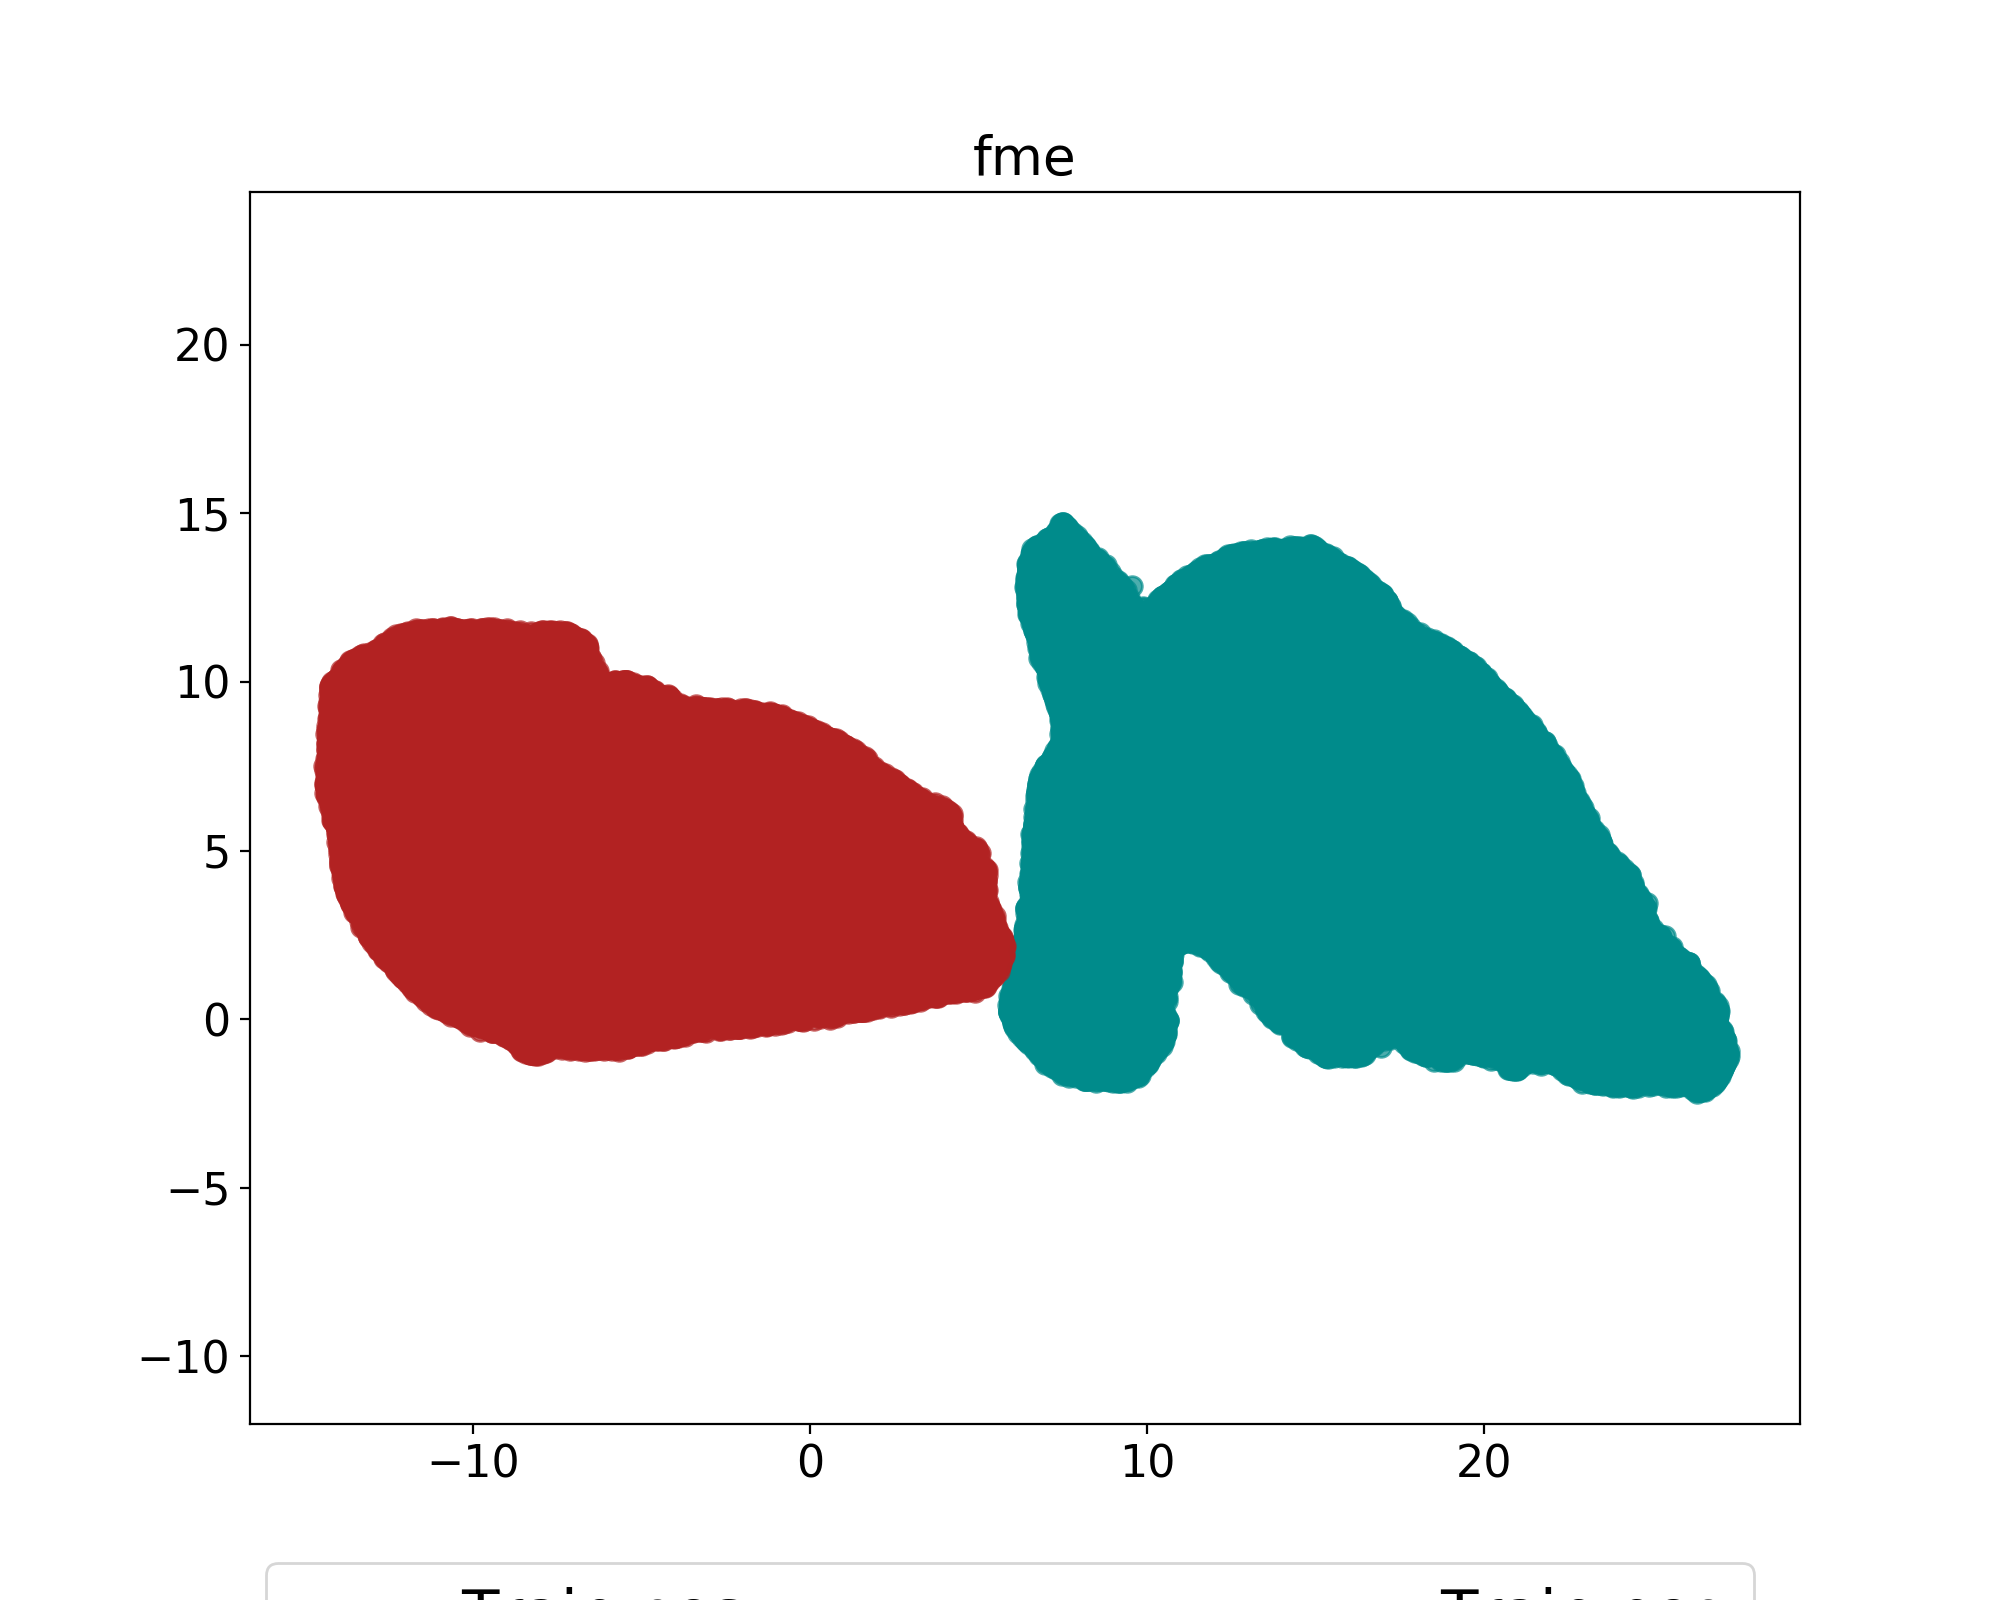

fle


<IPython.core.display.Javascript object>


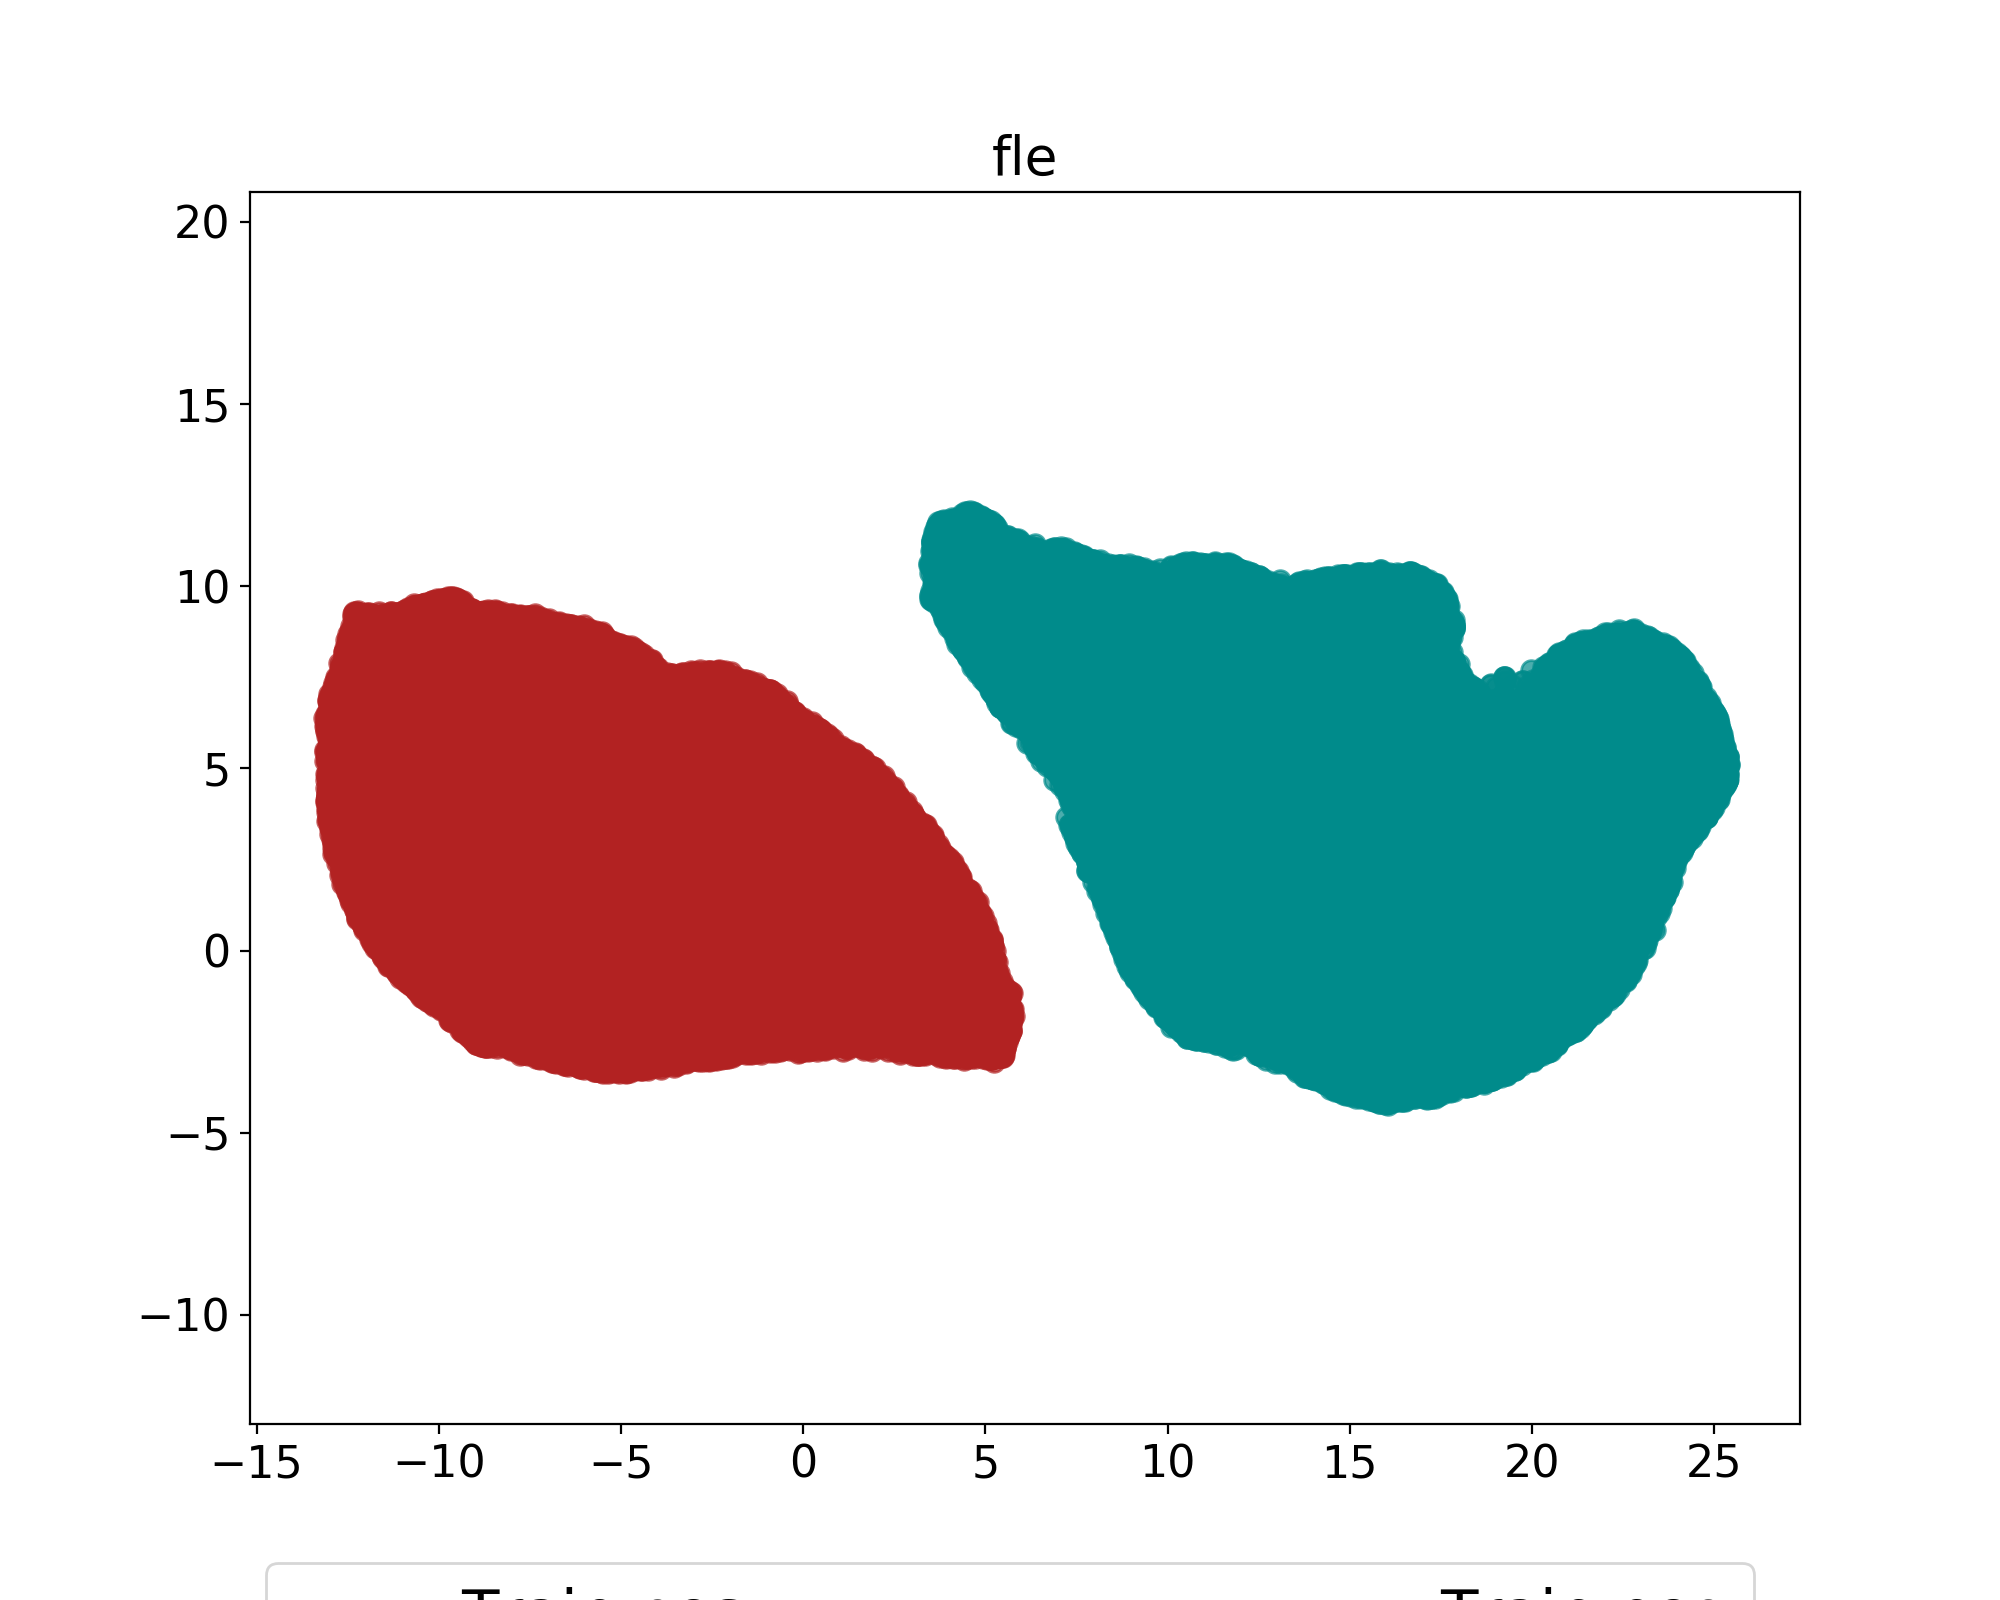

ftc


<IPython.core.display.Javascript object>


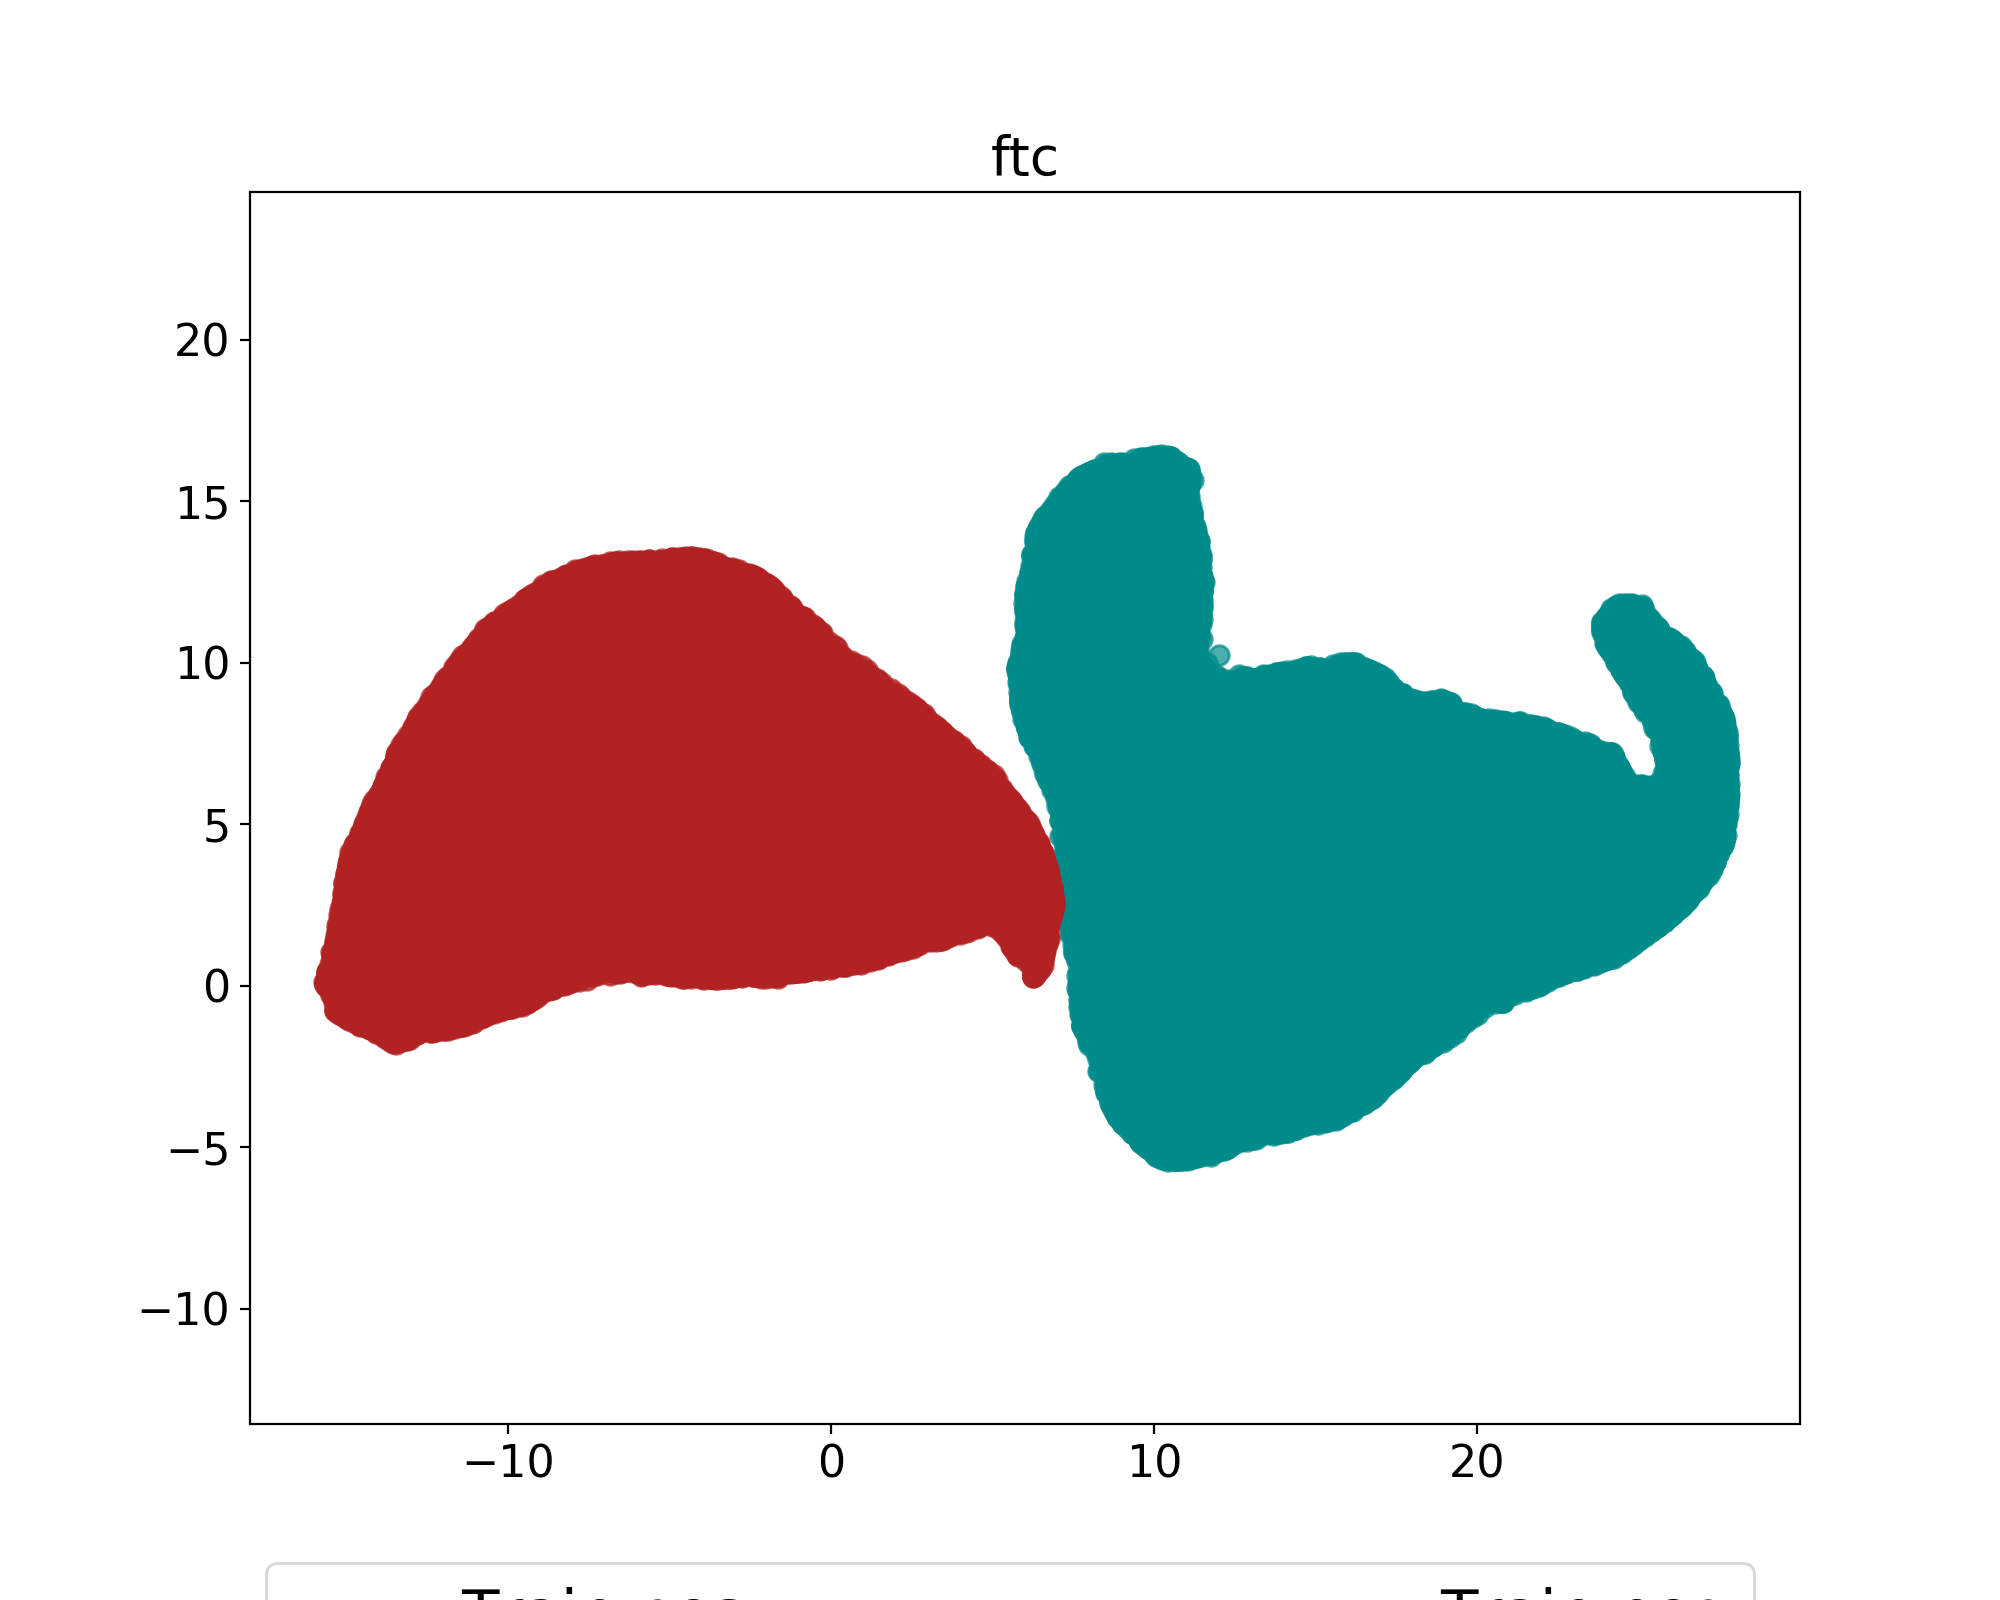

fax


<IPython.core.display.Javascript object>


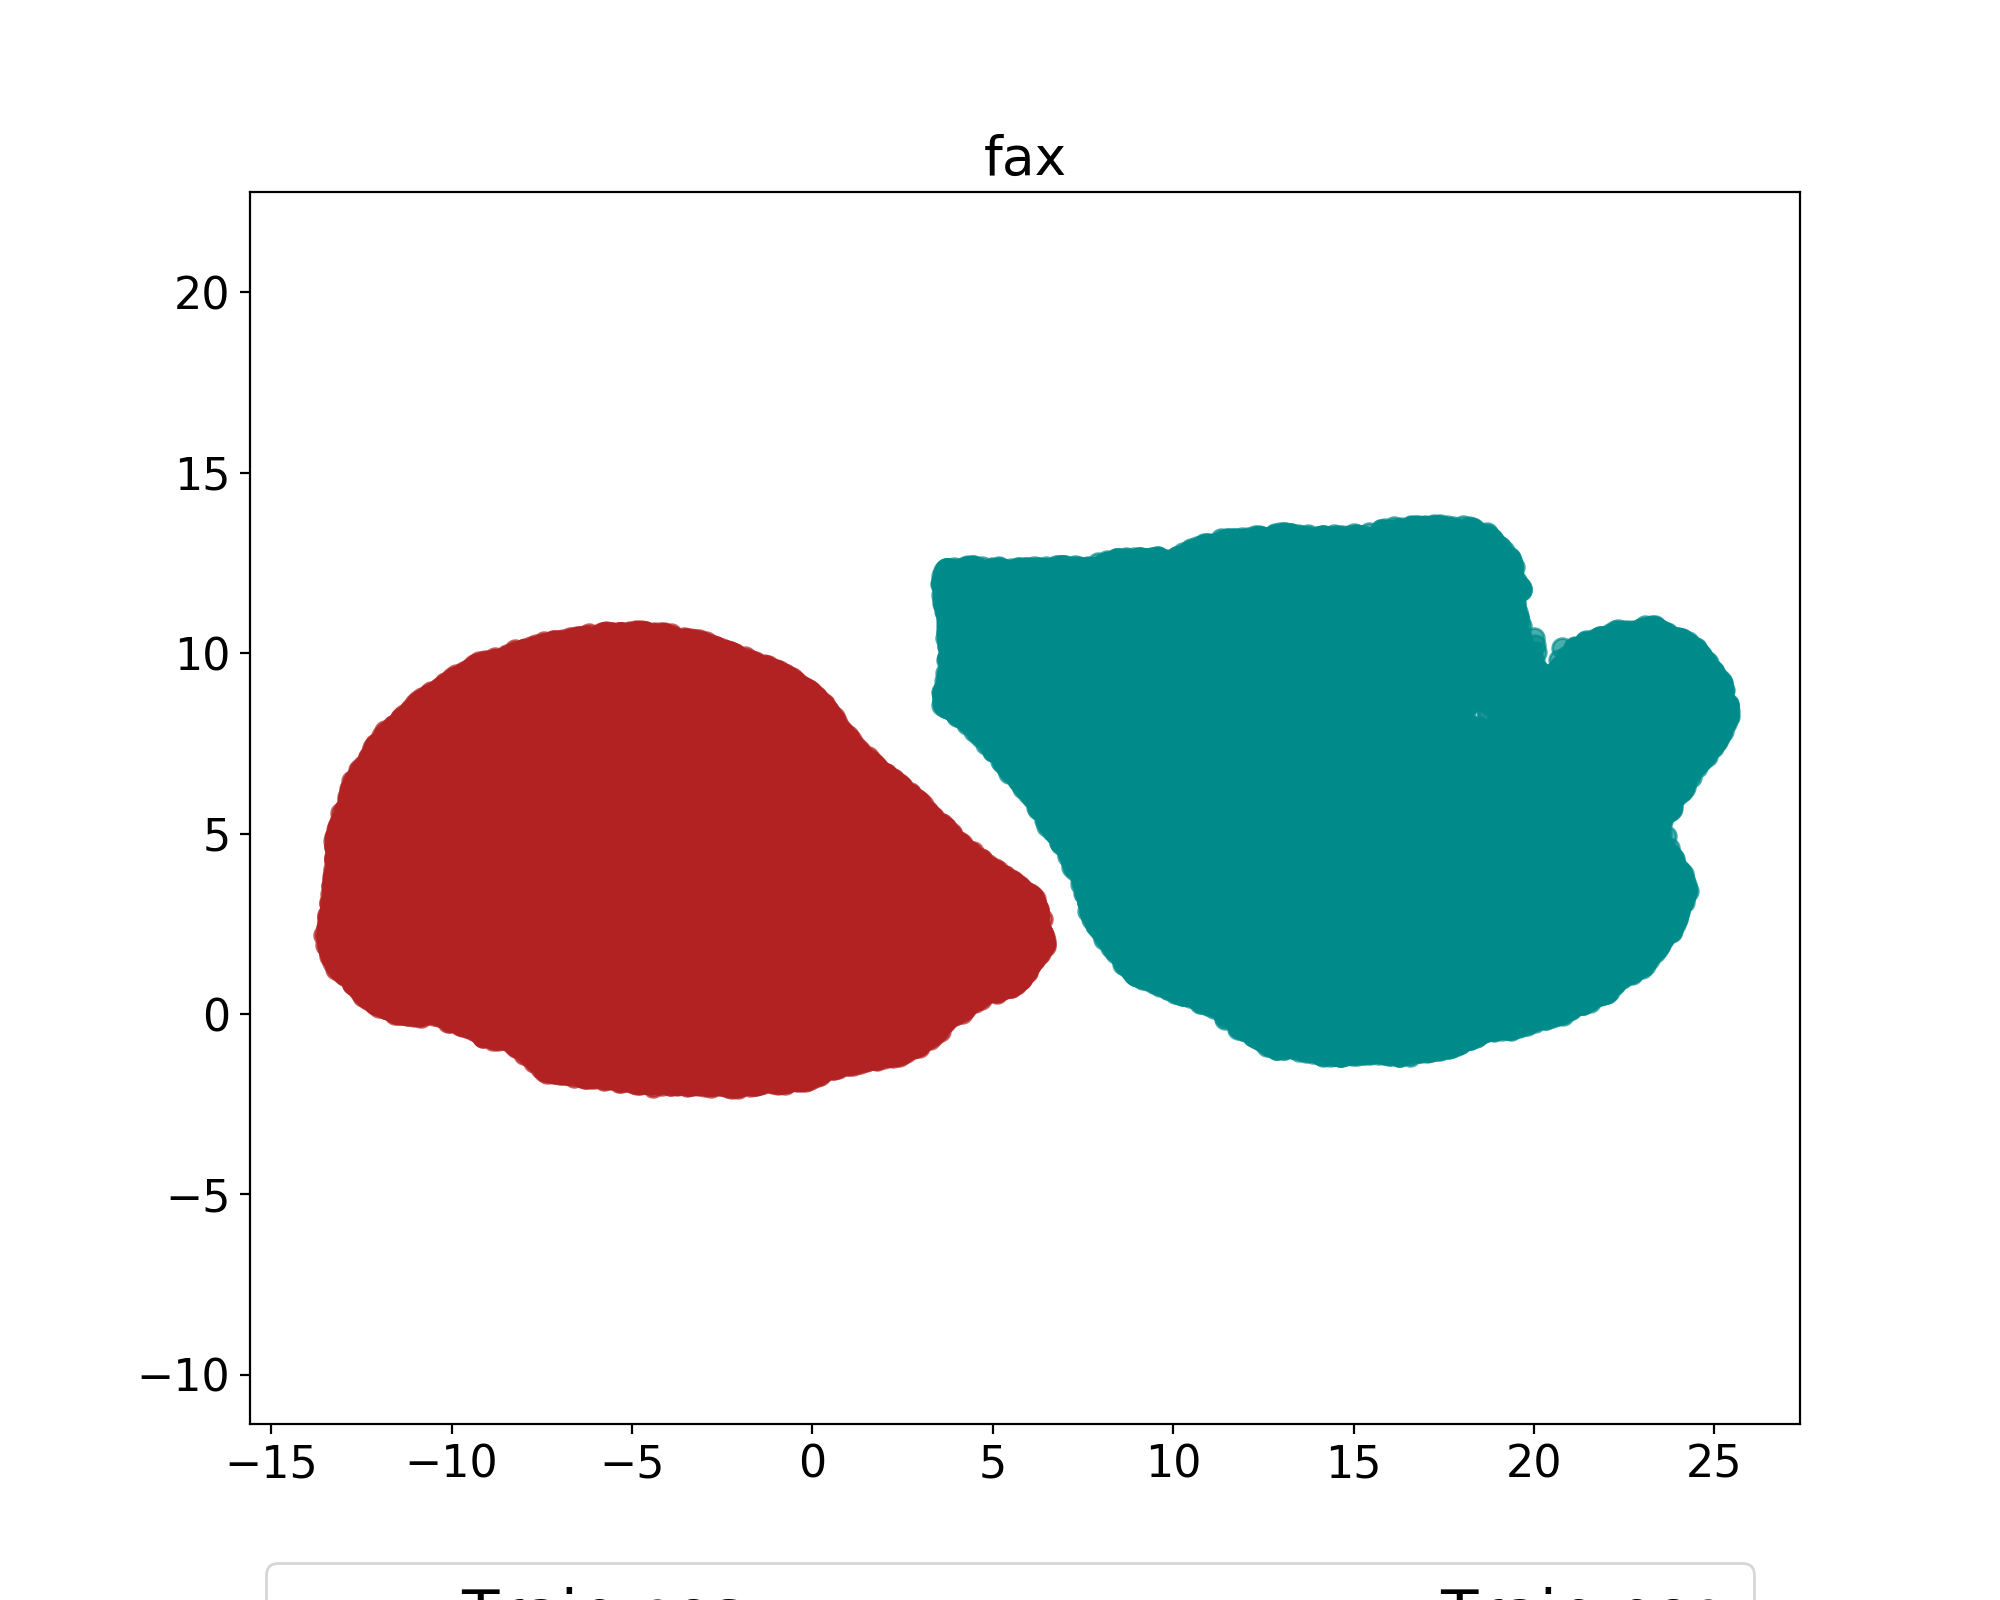

imu


<IPython.core.display.Javascript object>


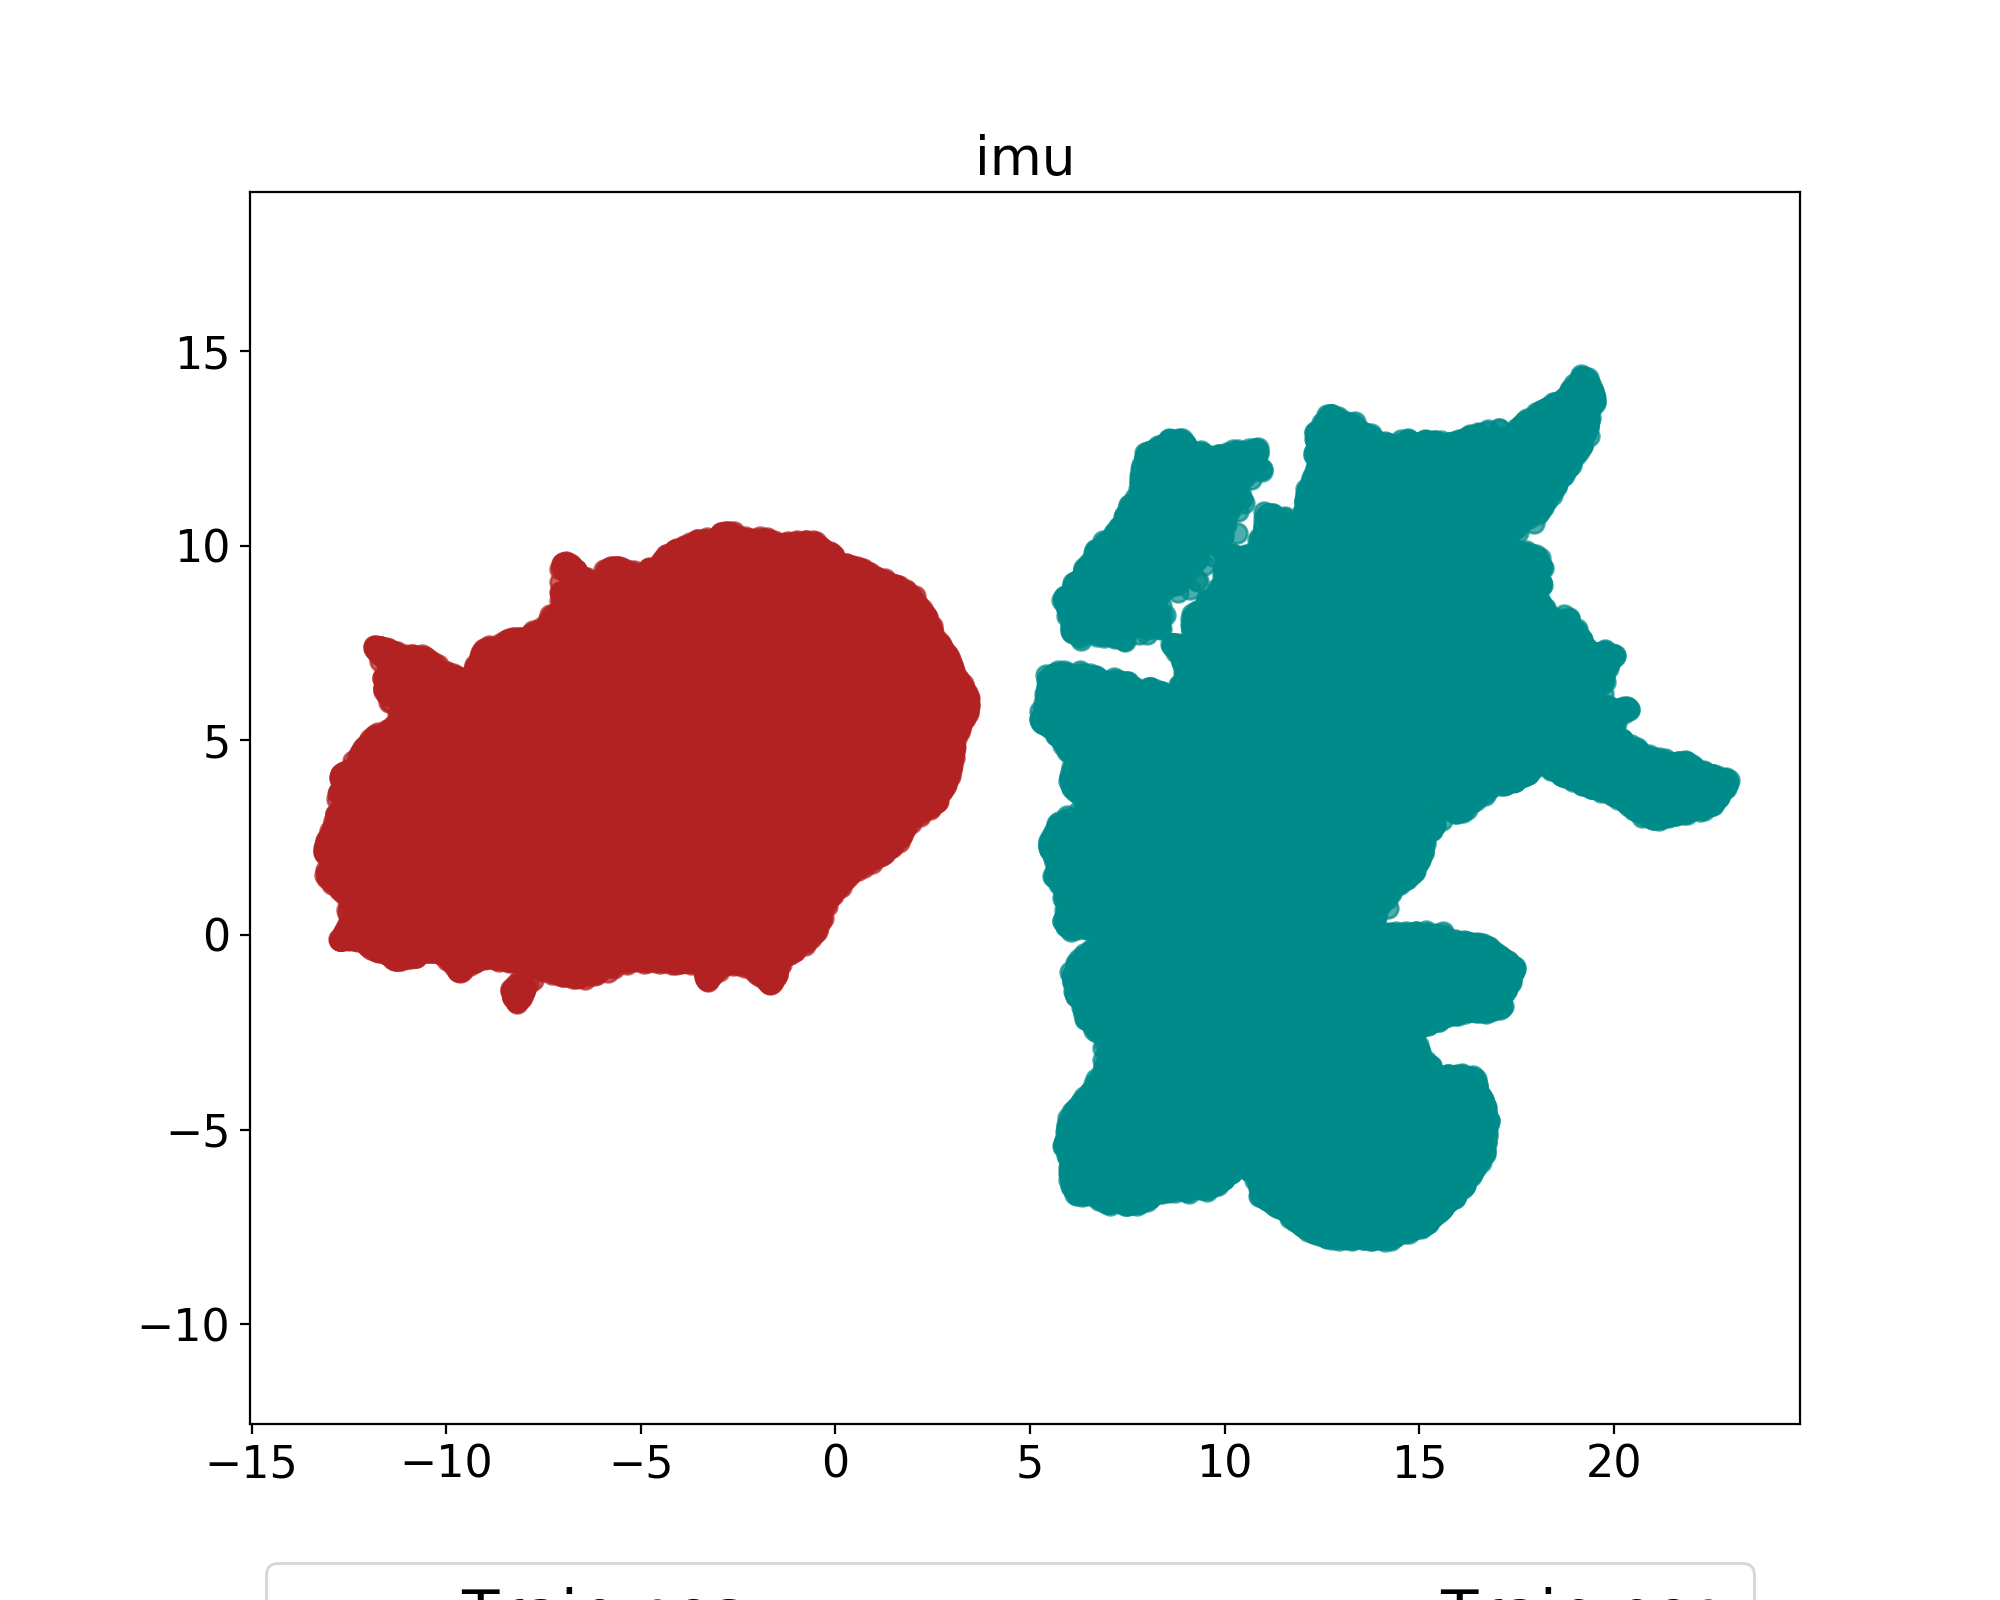

ias


<IPython.core.display.Javascript object>


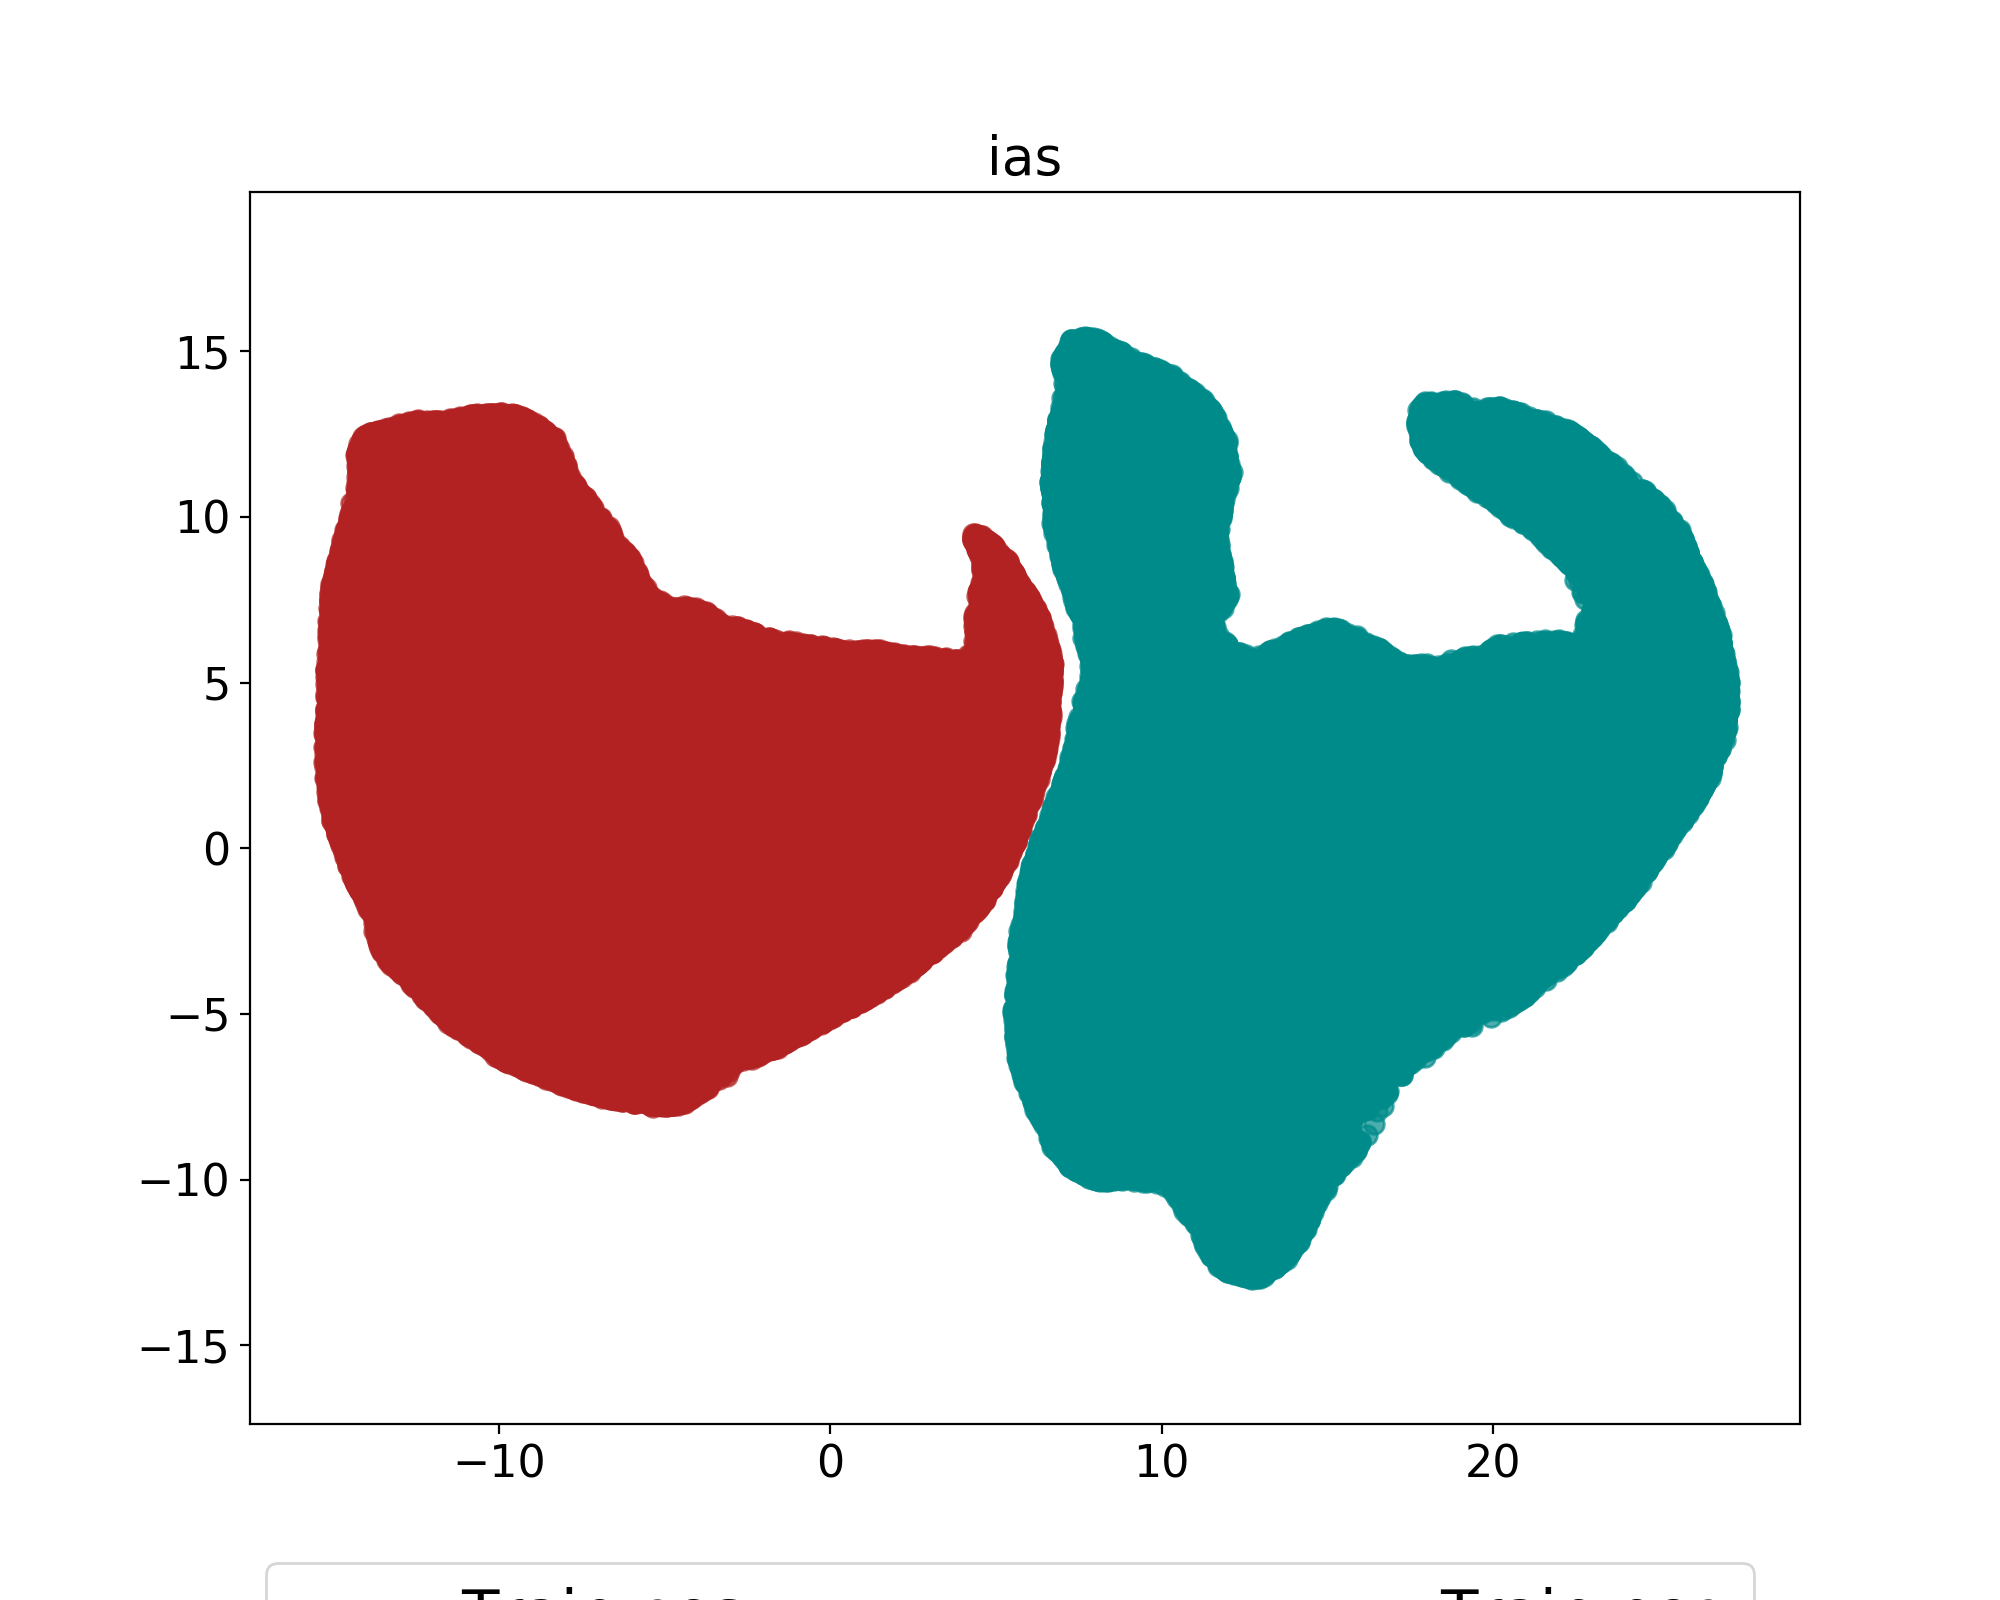

ttc


<IPython.core.display.Javascript object>


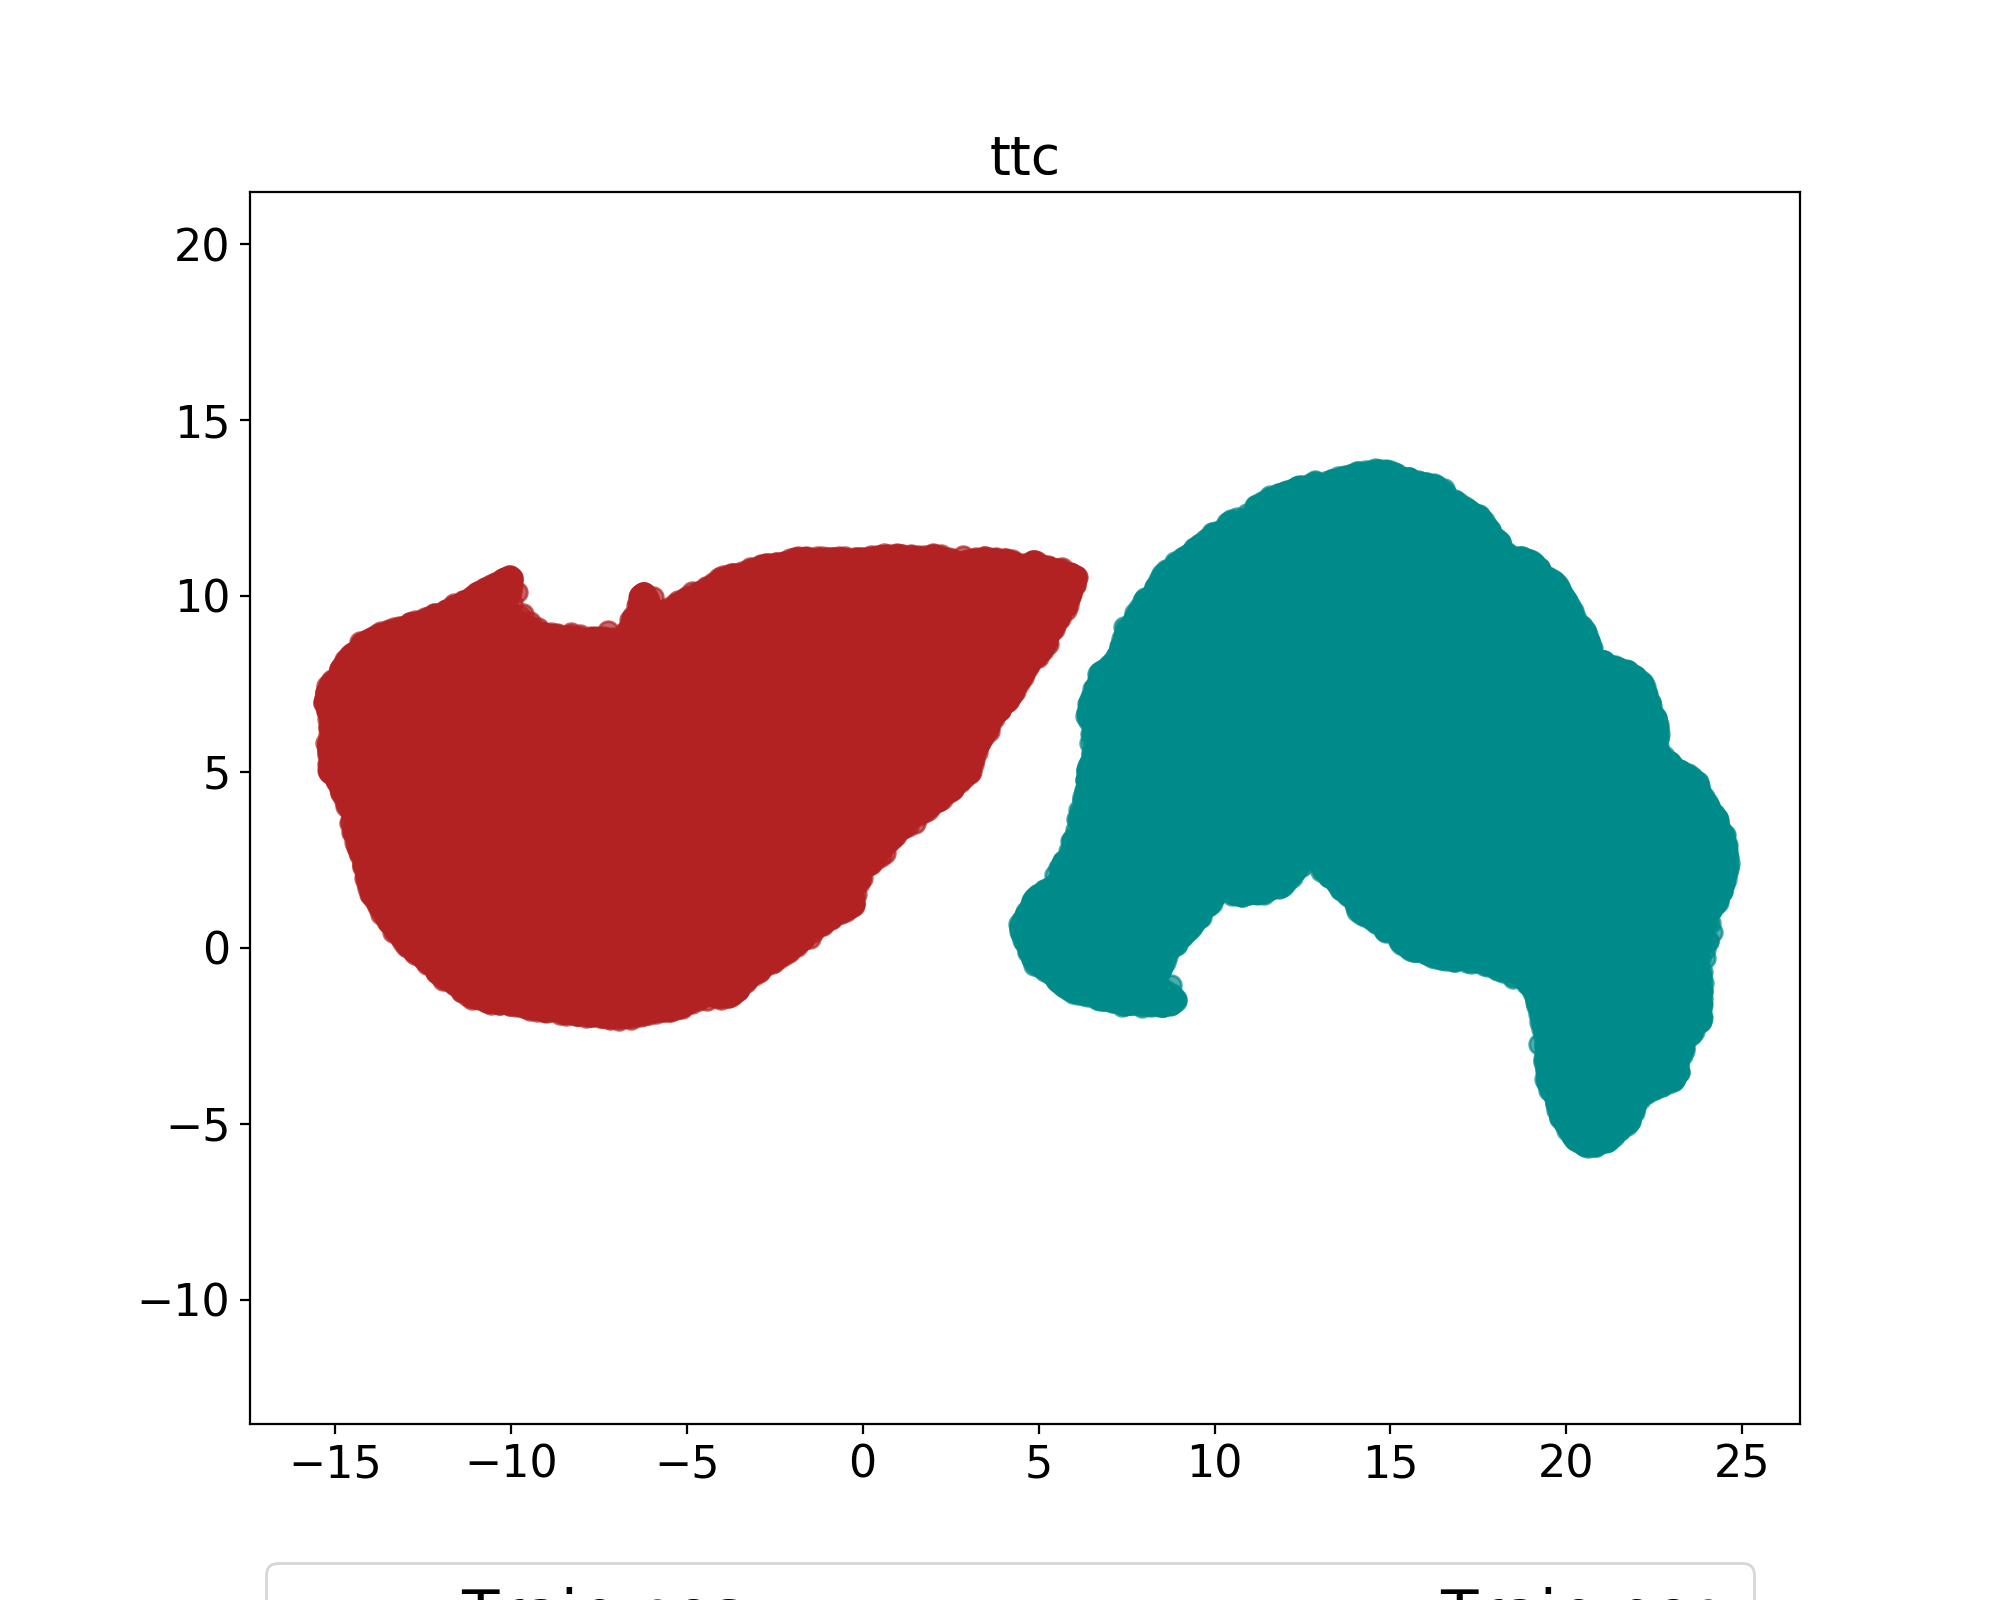

fle_fax


<IPython.core.display.Javascript object>


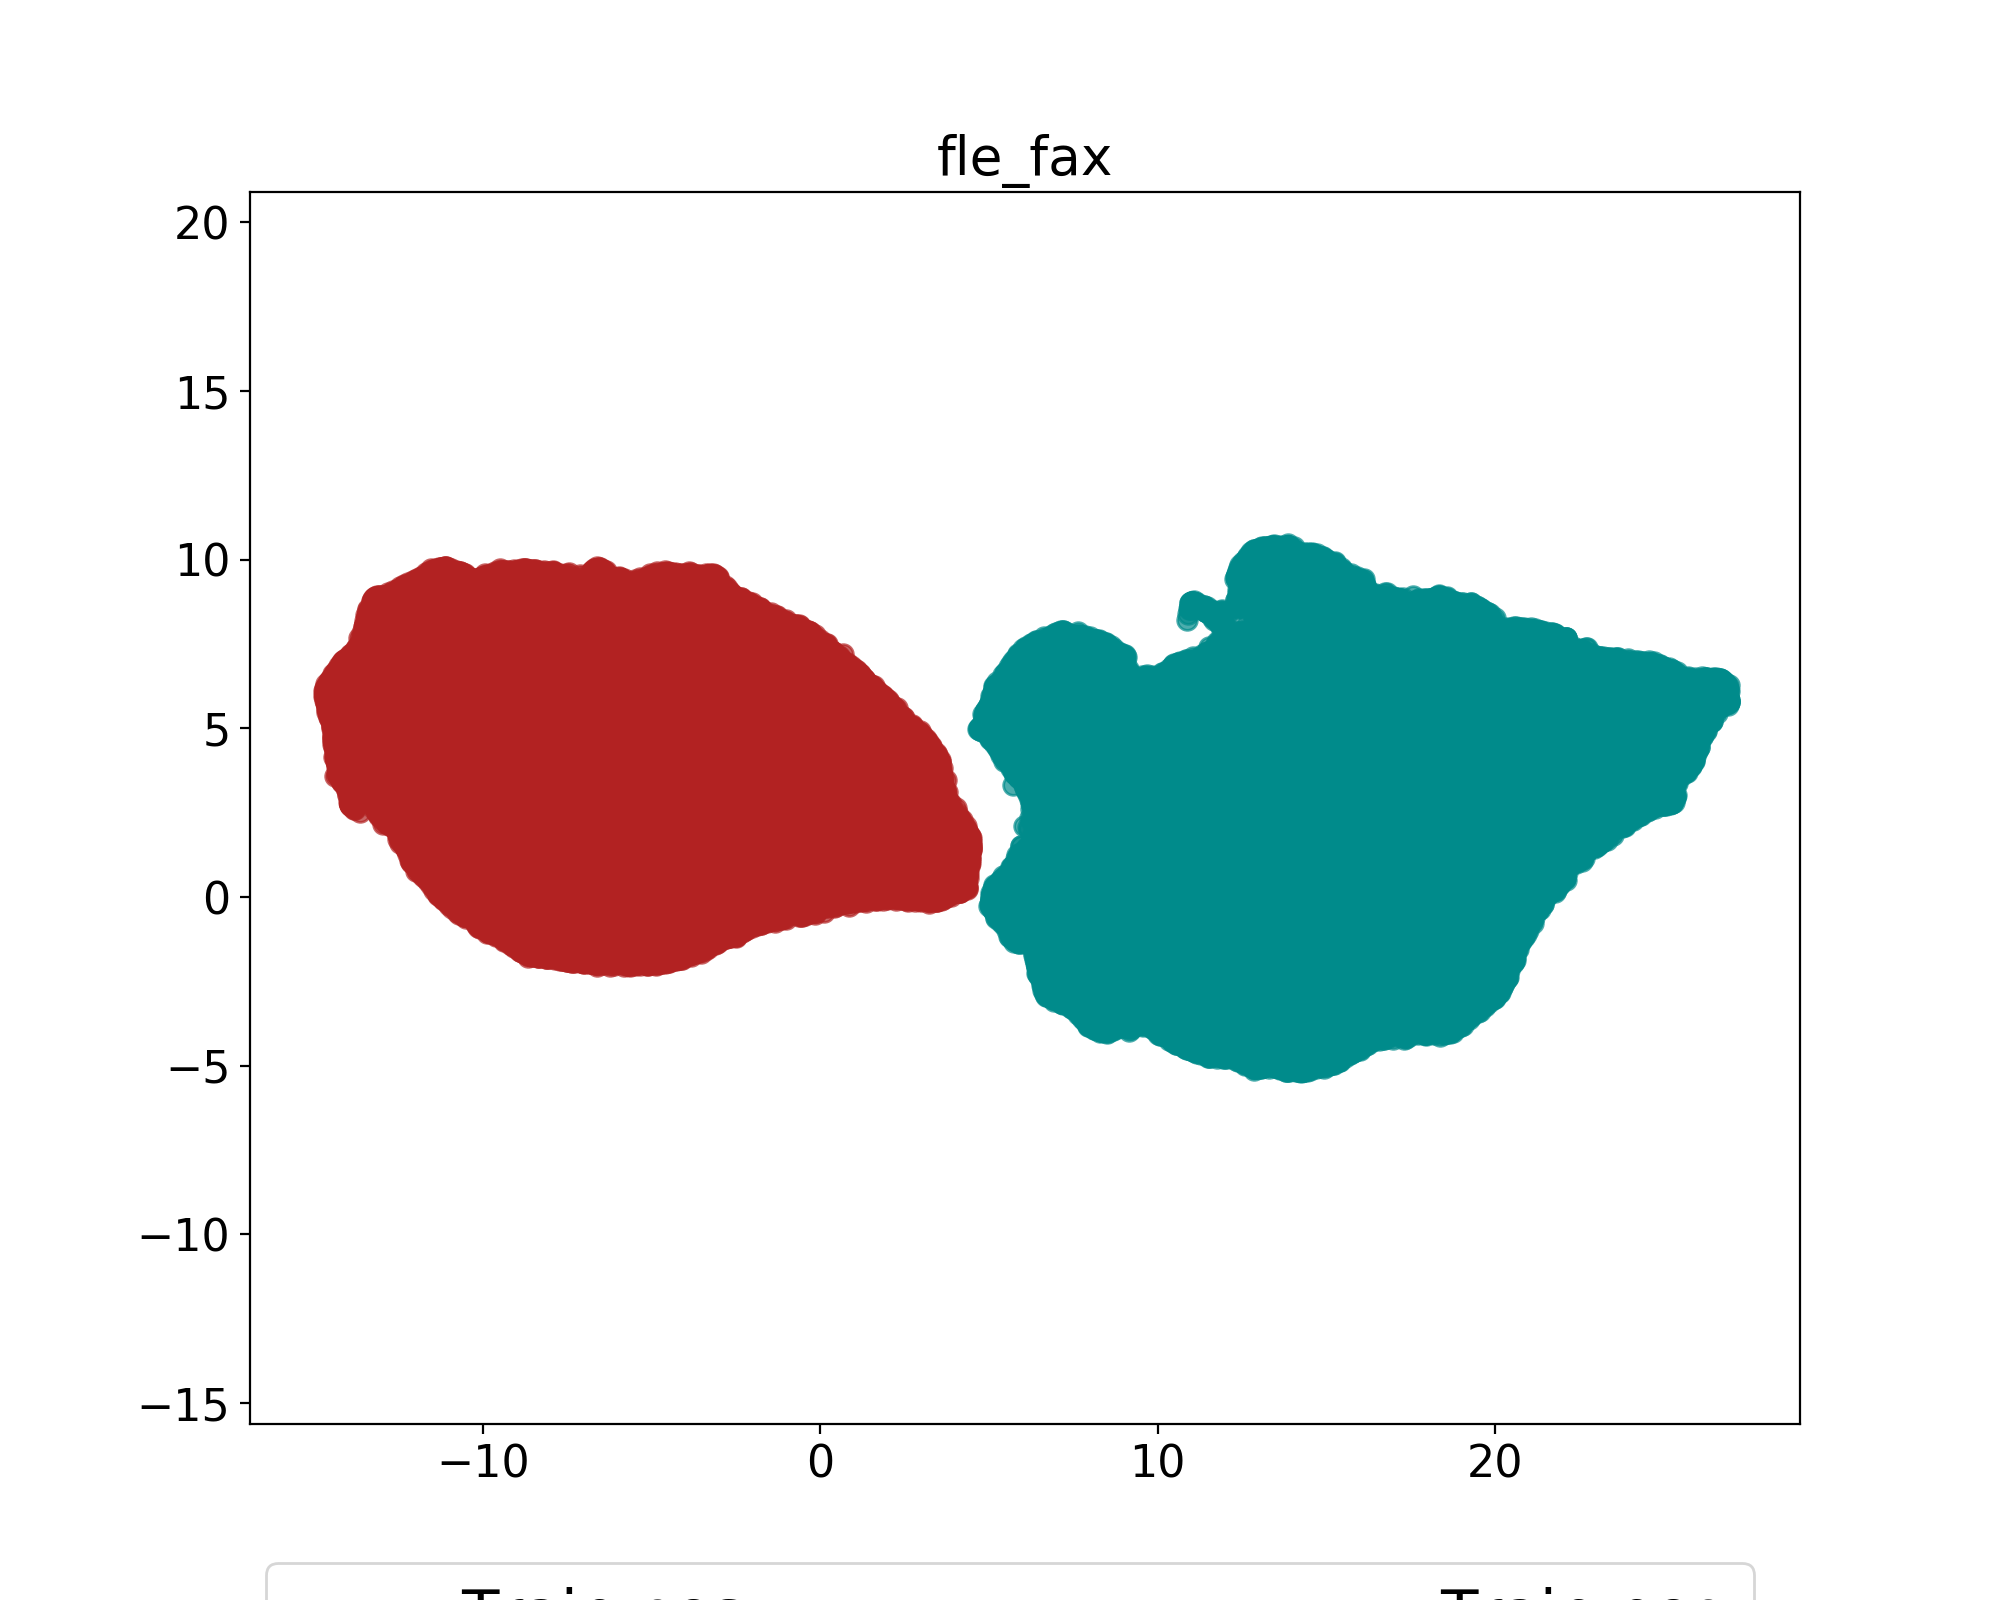

ftc_fle


<IPython.core.display.Javascript object>


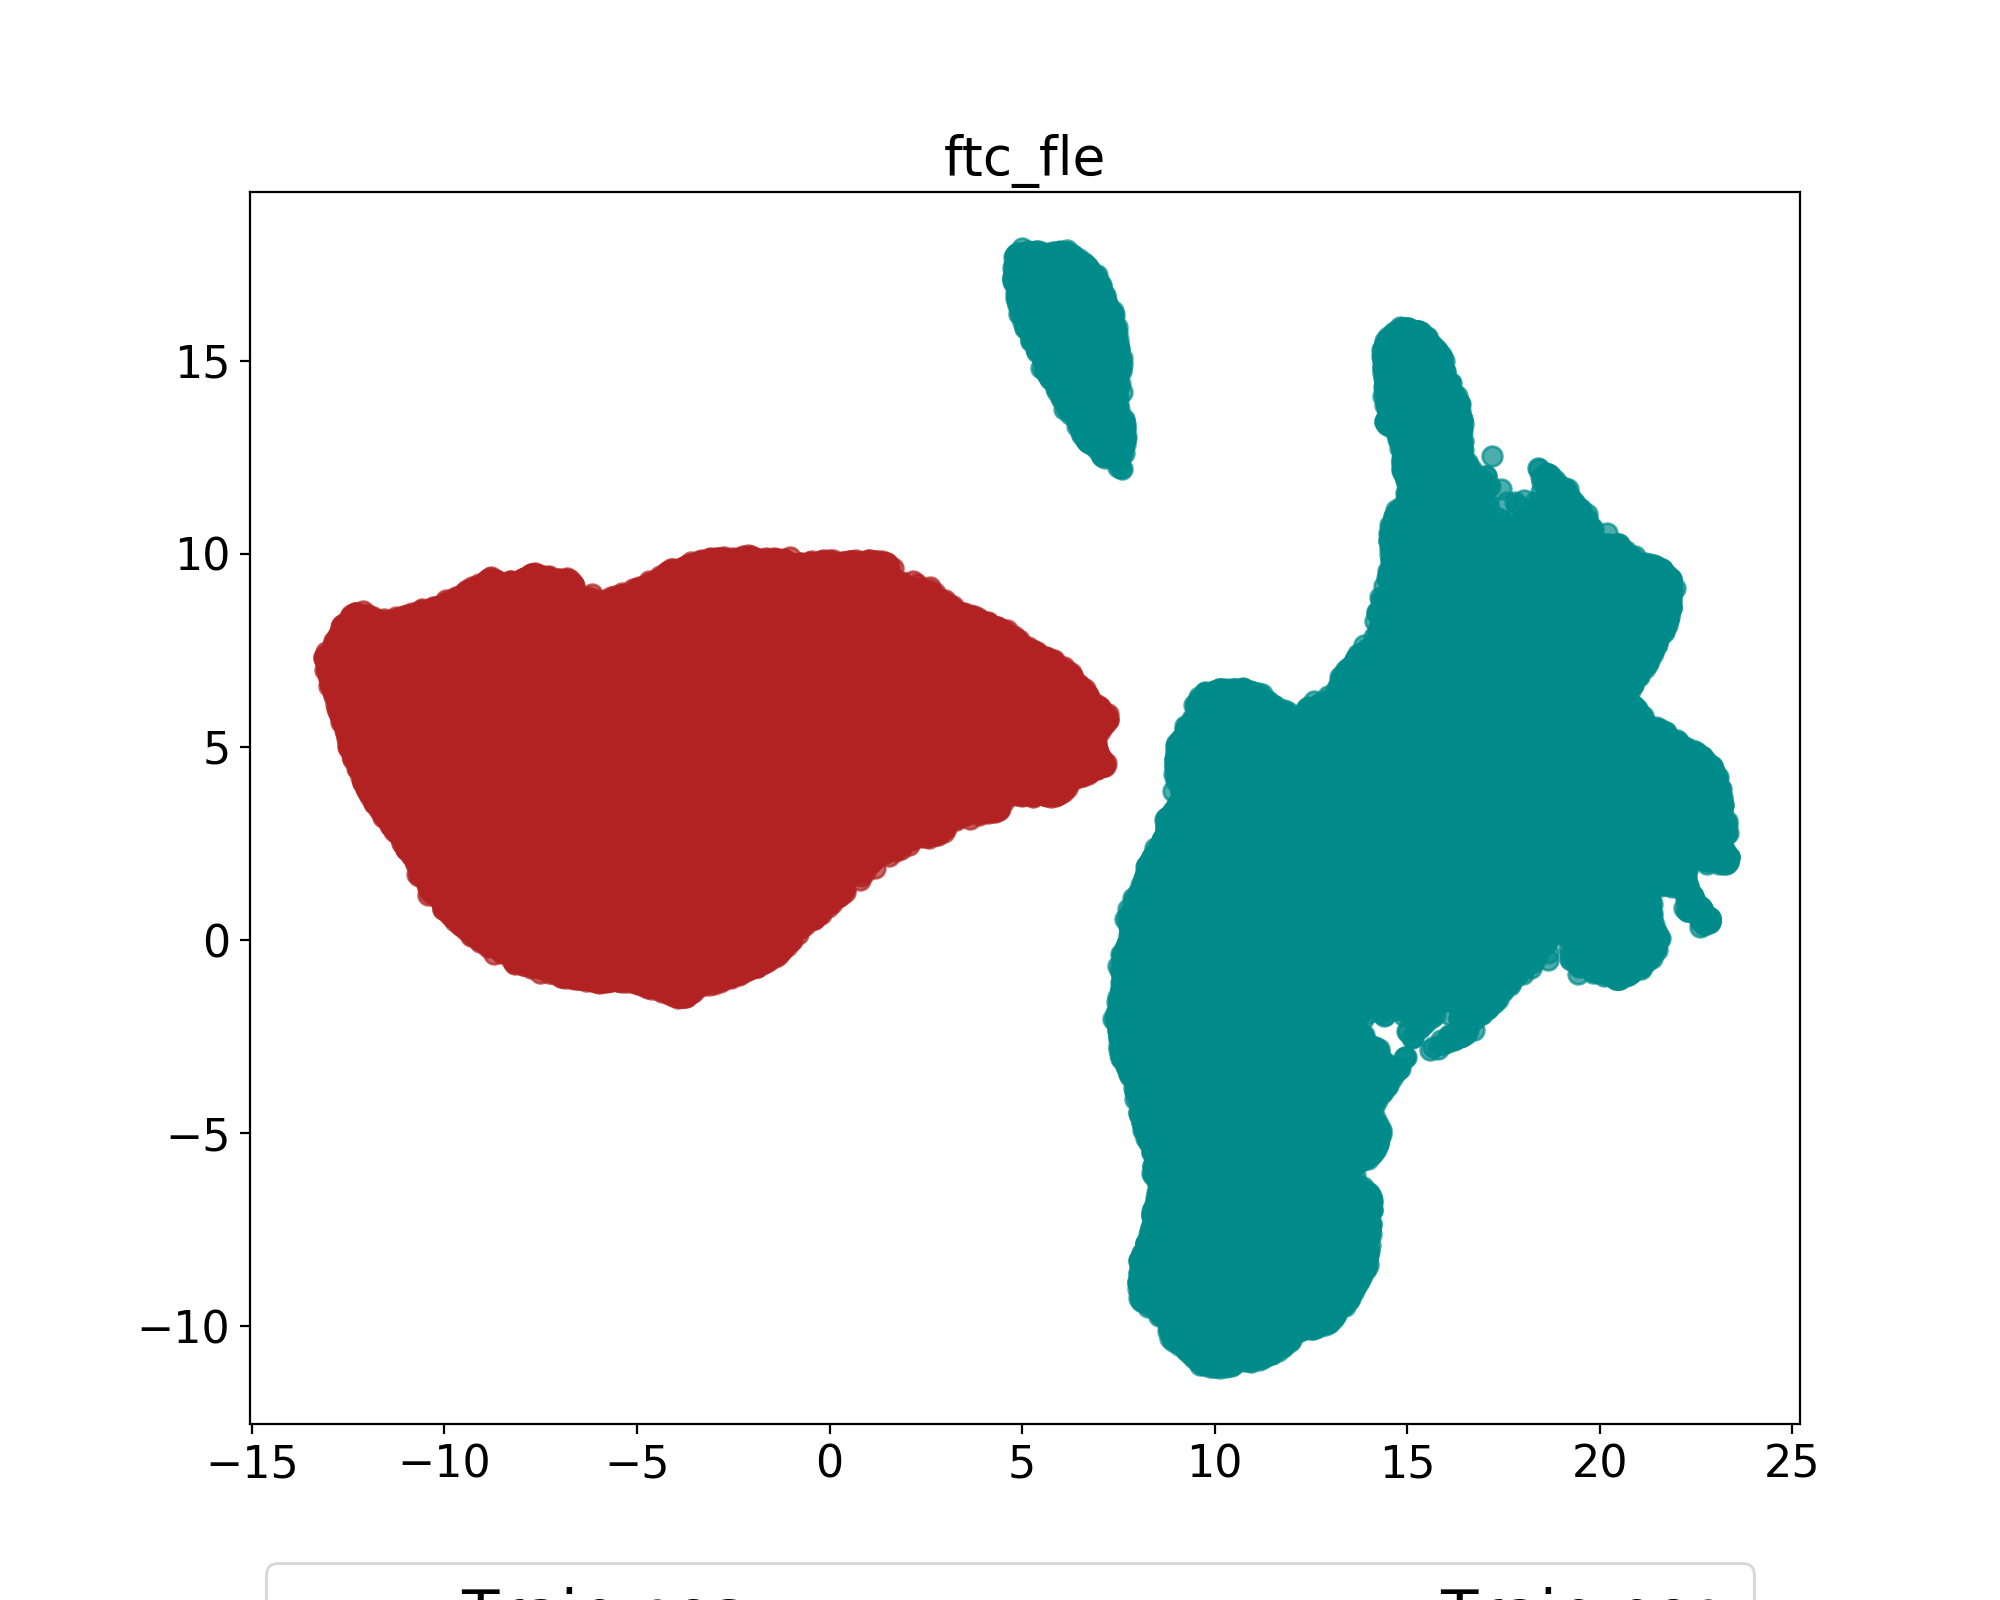

ftc_fle_fax


<IPython.core.display.Javascript object>


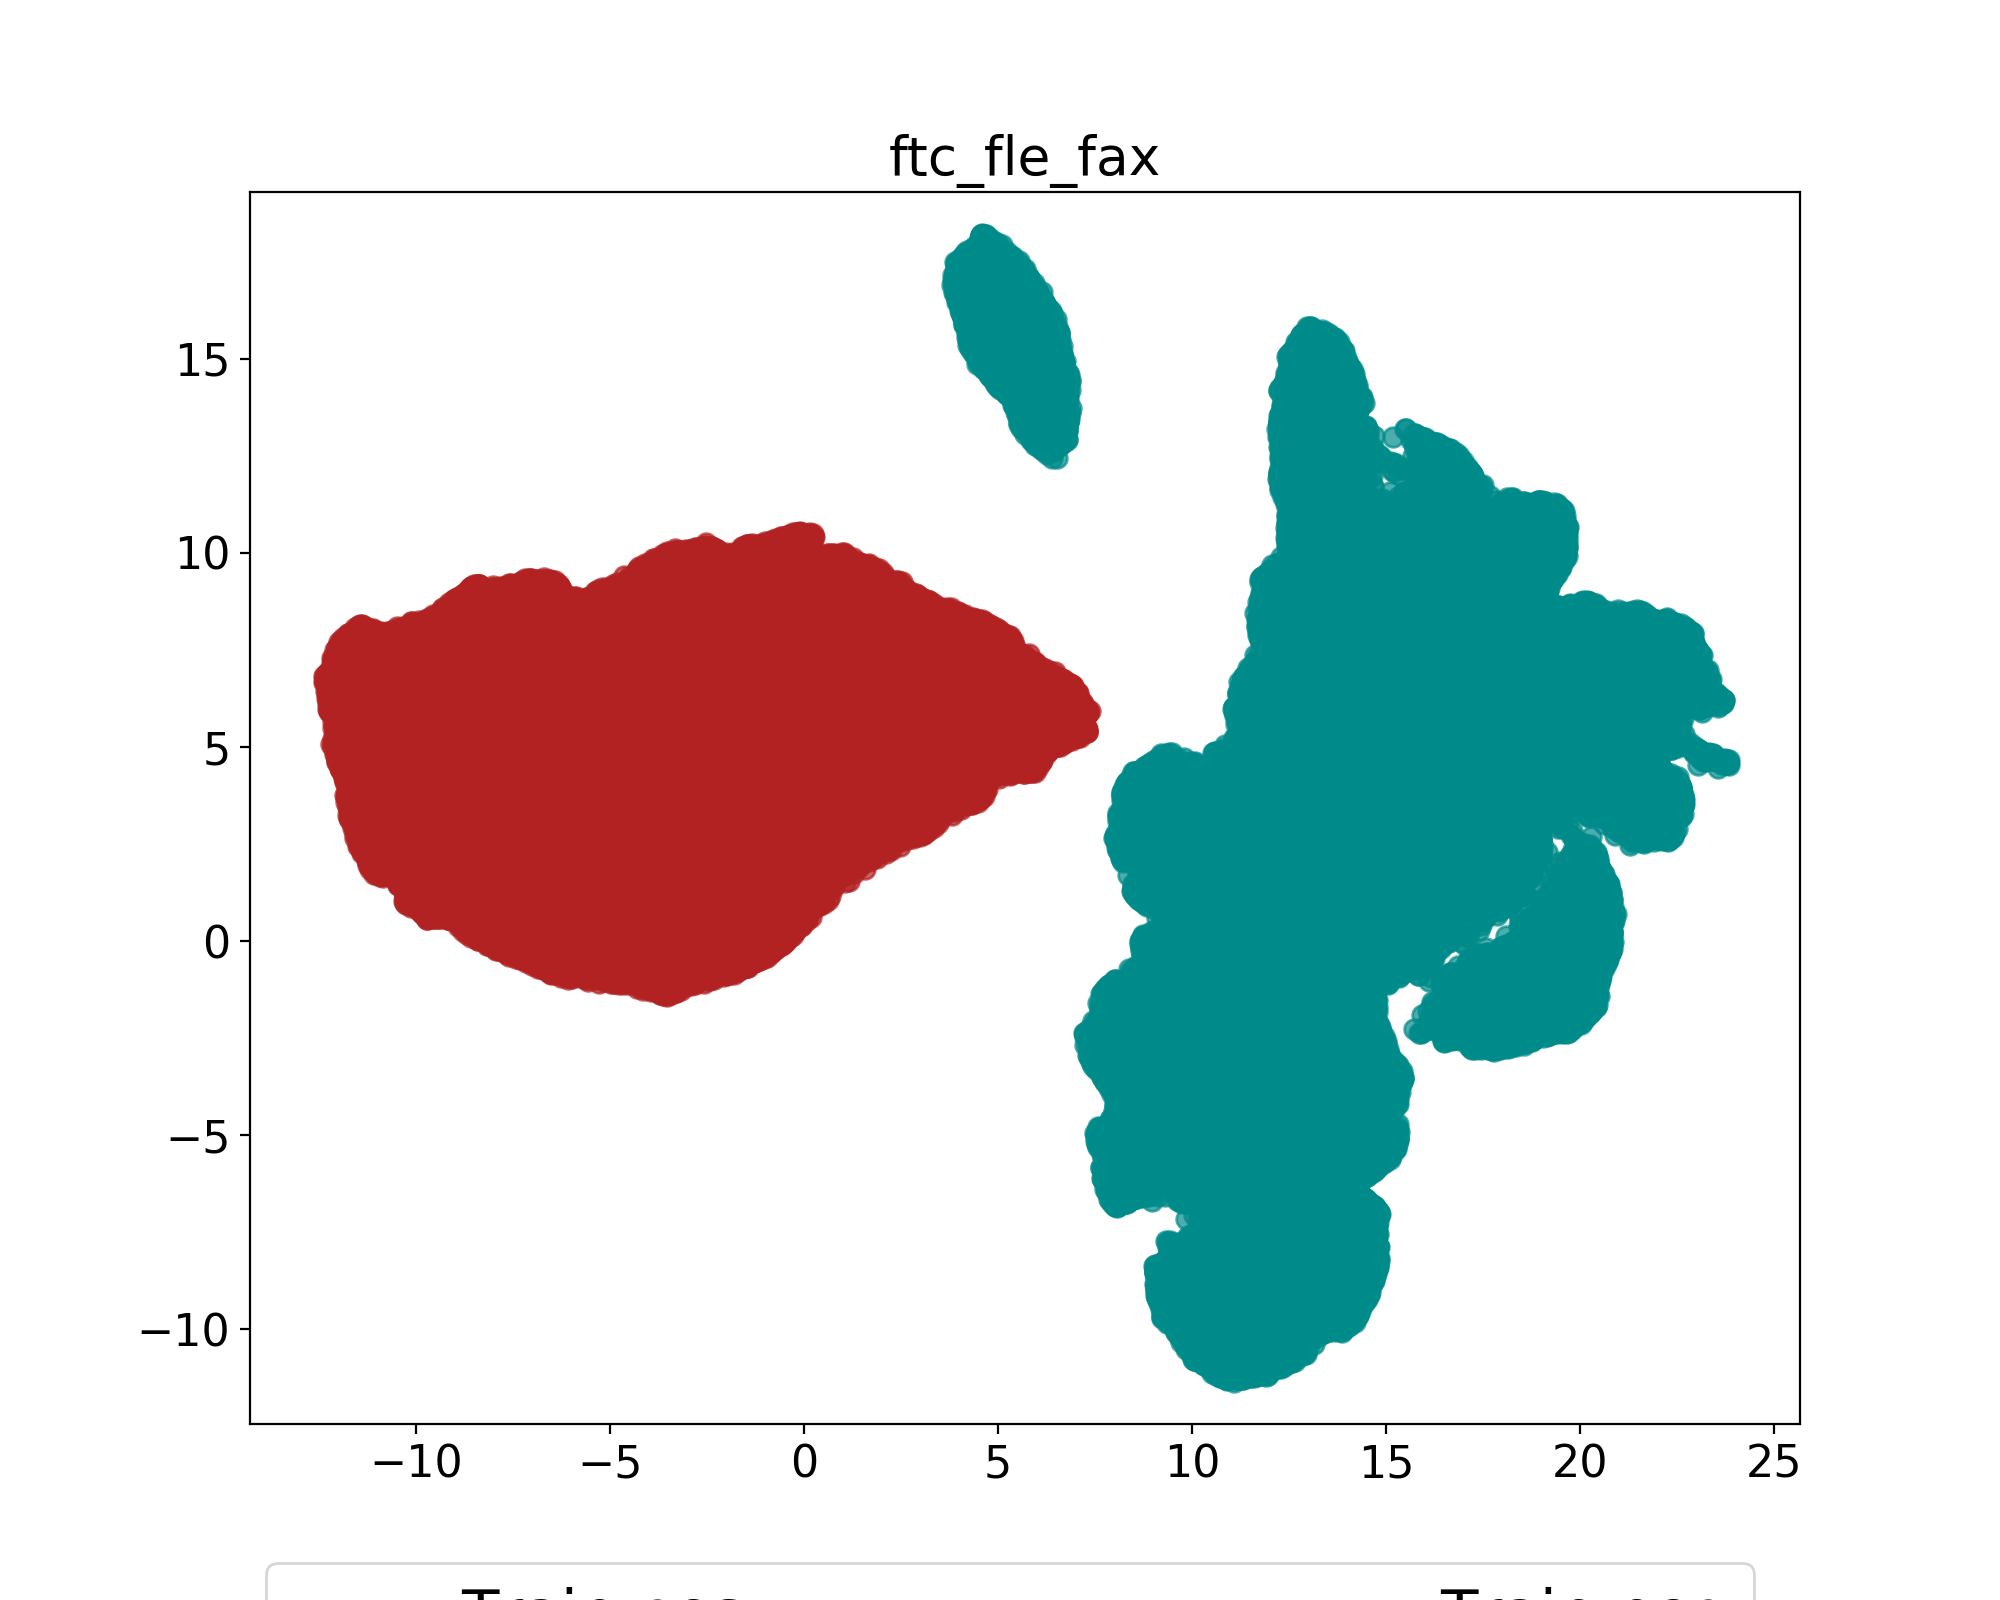

fle_fax_ttc


<IPython.core.display.Javascript object>


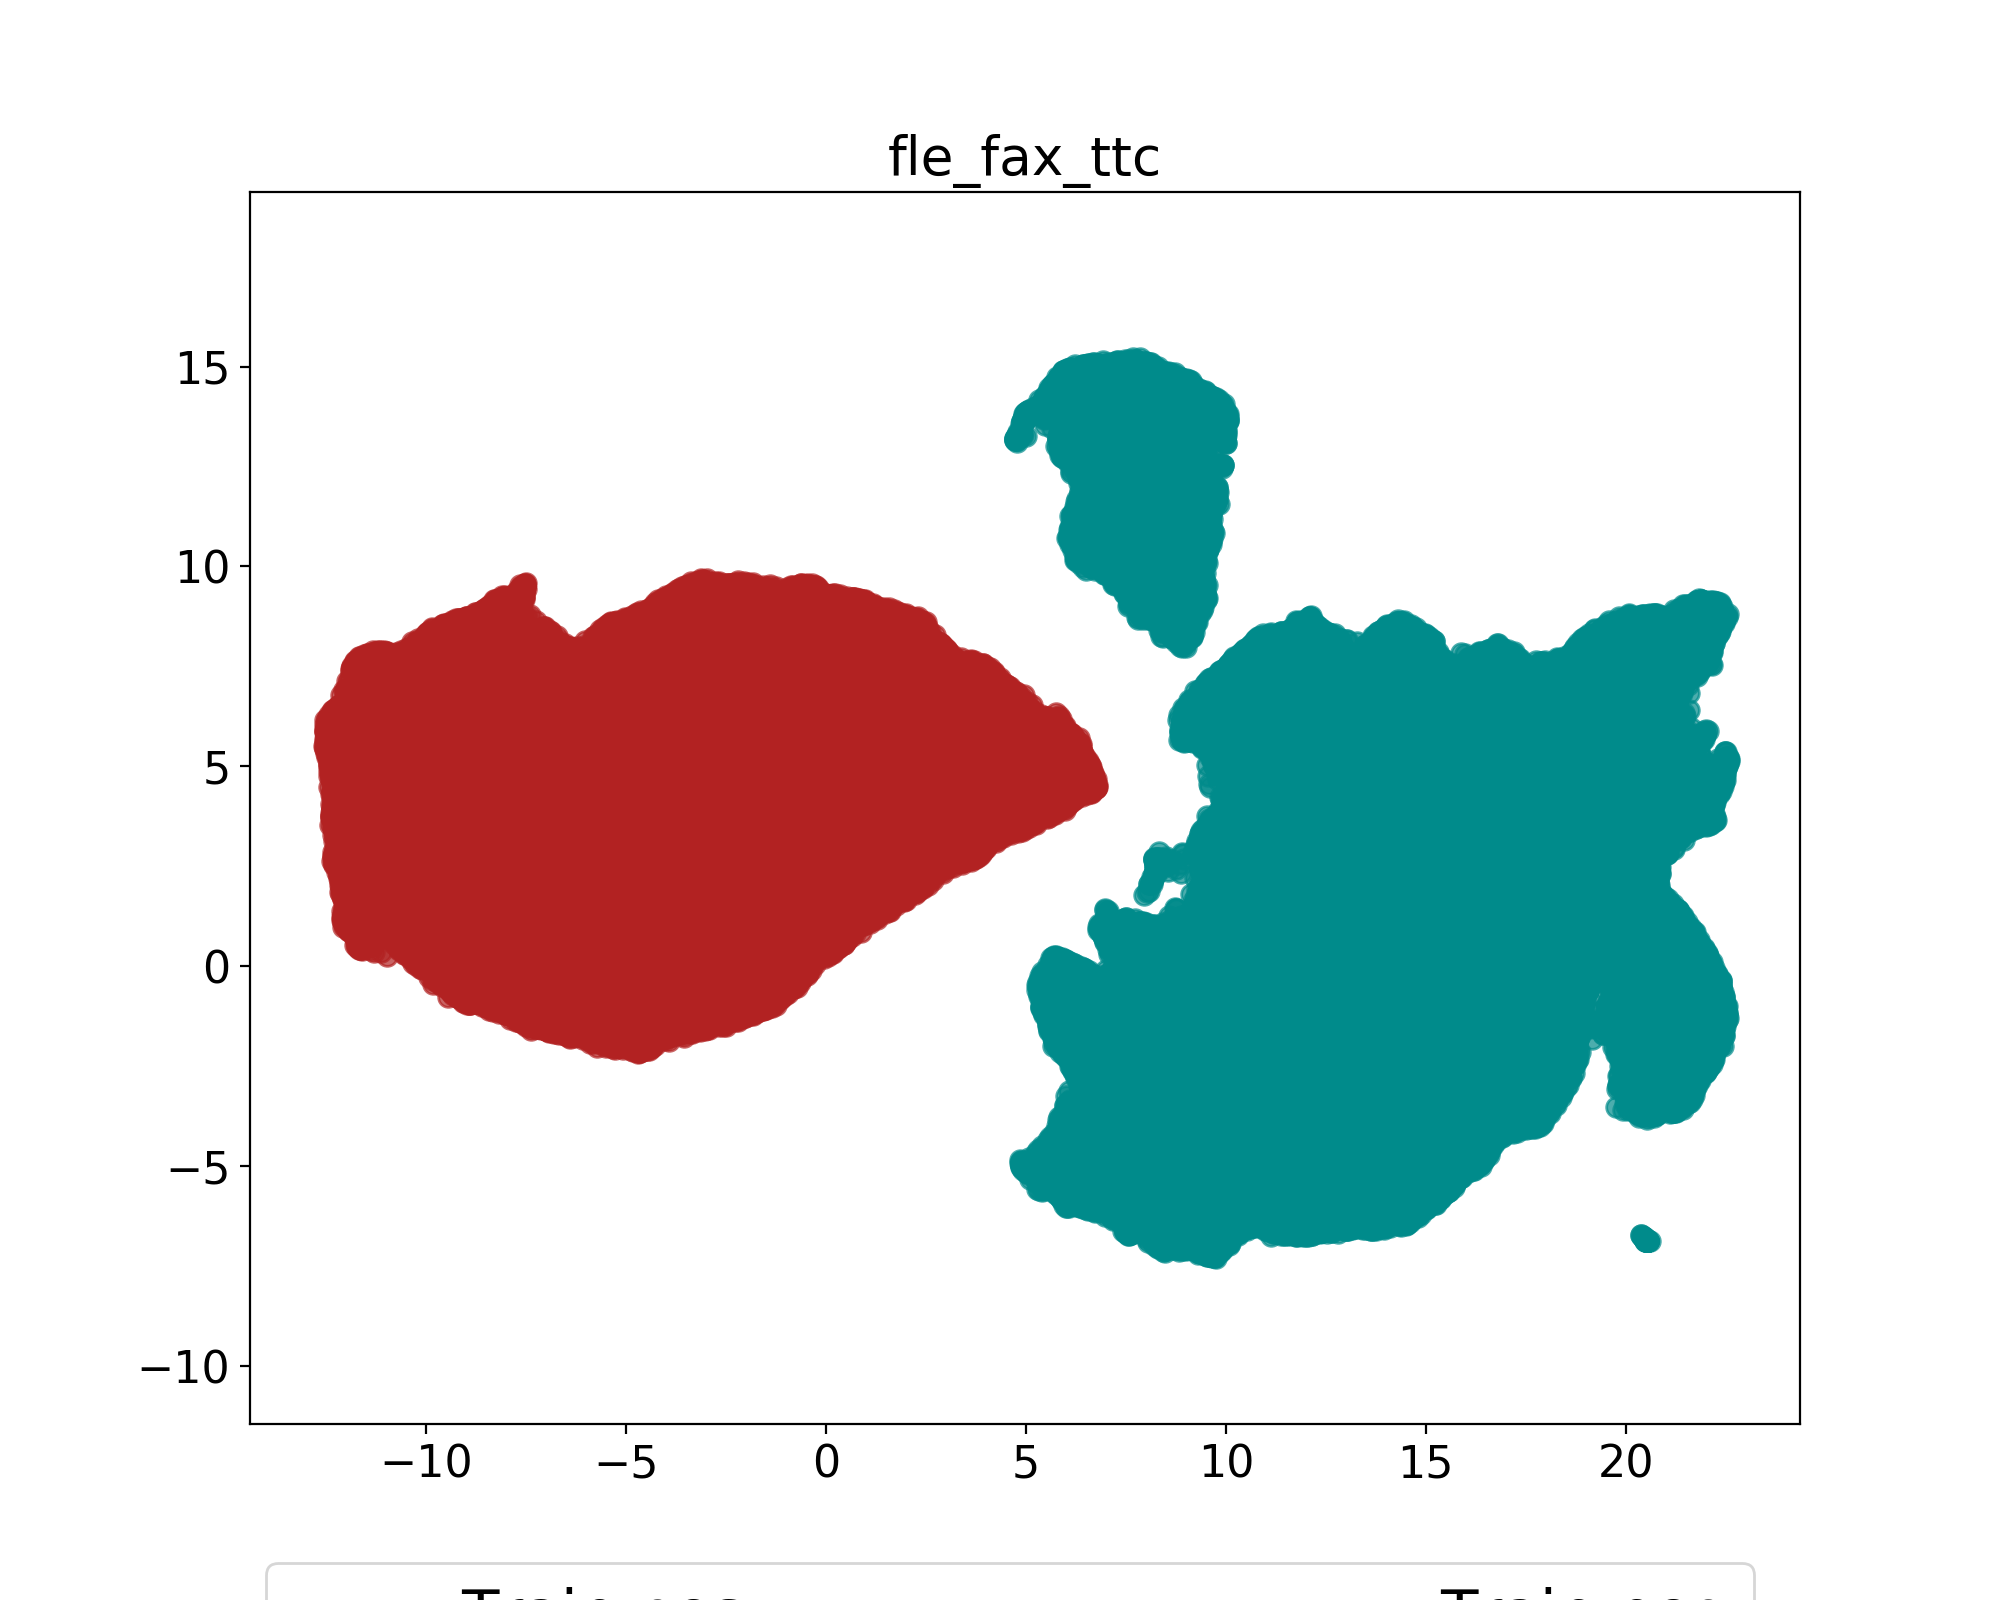

In [7]:
markers = [['fle', 'fax'], ['ftc', 'fle'], ['ftc', 'fle', 'fax'], ['fle', 'fax', 'ttc']]    
files = glob("pairs/*.npz")

dic_embeddings_pairs, dic_data_pairs = get_embeddings(files, feat='time', mode='u', n=50, dist=0.5, n_components=2, markers_concat=markers)

for key in dic_embeddings_pairs:
    embeddings = dic_embeddings_pairs[key][:, 2:] 
    labels = dic_embeddings_pairs[key][:, 0]
    print(key)
    plt.figure(figsize=(10, 8)) 
    idxs_pos = np.where(labels==1)[0]
    idxs_neg = np.where(labels==0)[0]
    plt.scatter(embeddings[idxs_pos, 0], embeddings[idxs_pos, 1], facecolors='darkcyan', s=50, alpha=0.7, label='Train pos')
    plt.scatter(embeddings[idxs_neg, 0], embeddings[idxs_neg, 1], facecolors='firebrick', s=50, alpha=0.7, label='Train neg')
    plt.gca().set_aspect('equal', 'datalim')  
    plt.legend(loc=[0.01, -0.2], ncol=2, fontsize=22, scatterpoints=10, mode='expand')
    plt.title(key)
    

nexus
fme
fle
ftc
fax
imu
ias
ttc
nexus


<IPython.core.display.Javascript object>


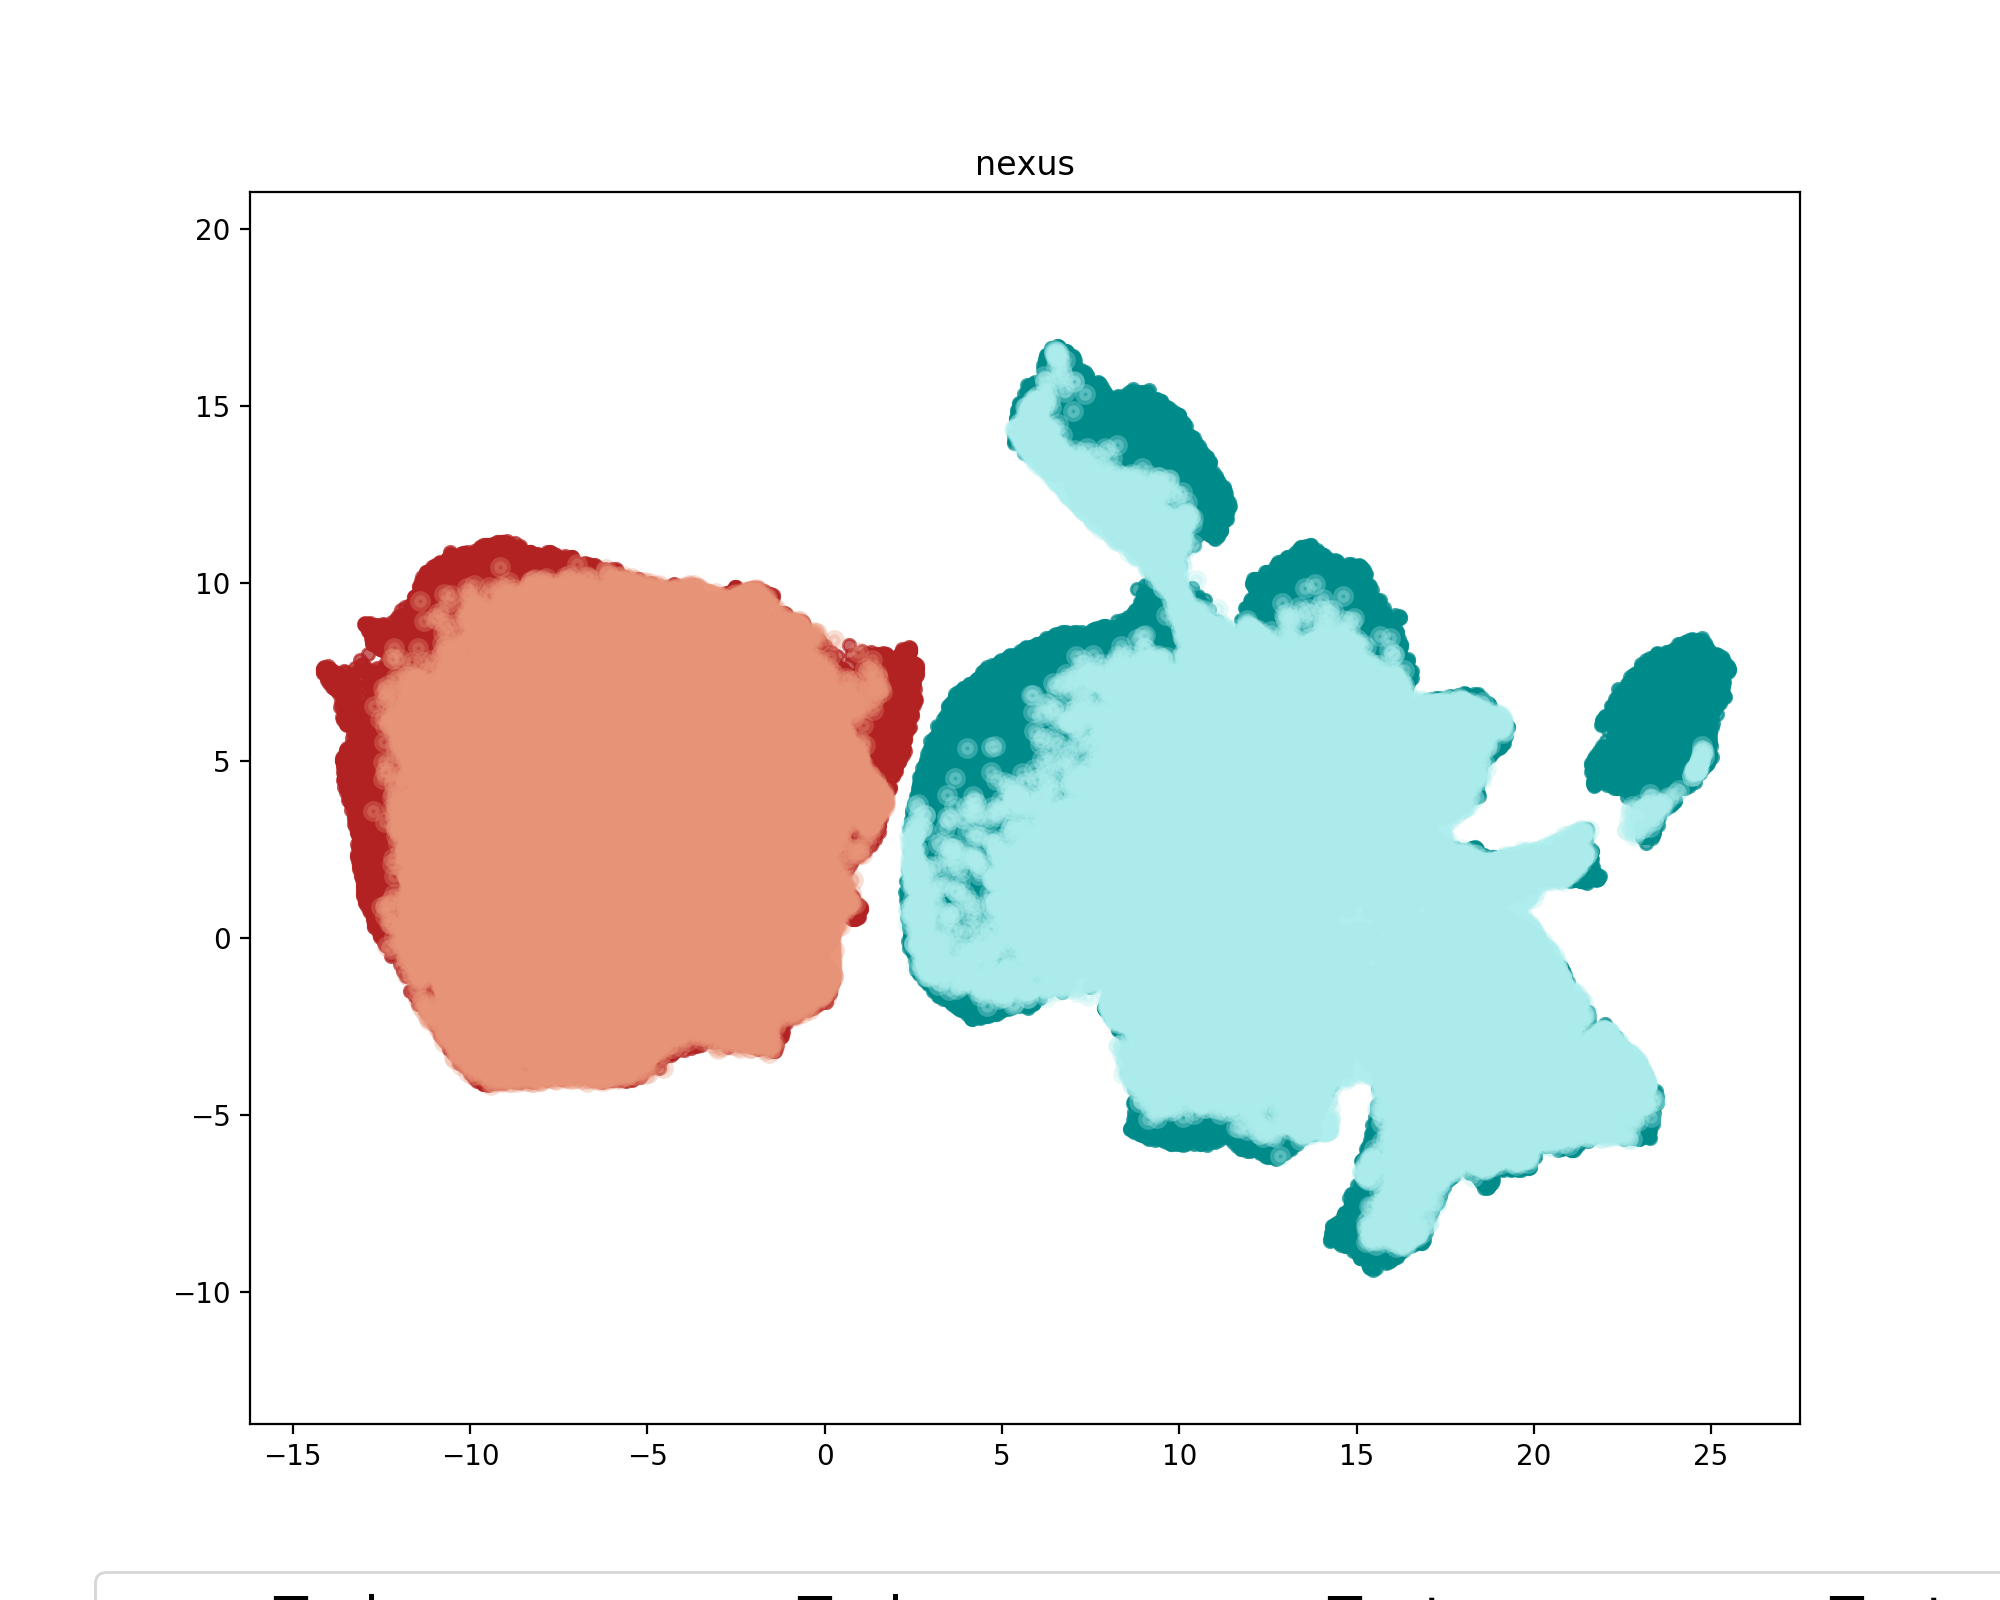

fme


<IPython.core.display.Javascript object>


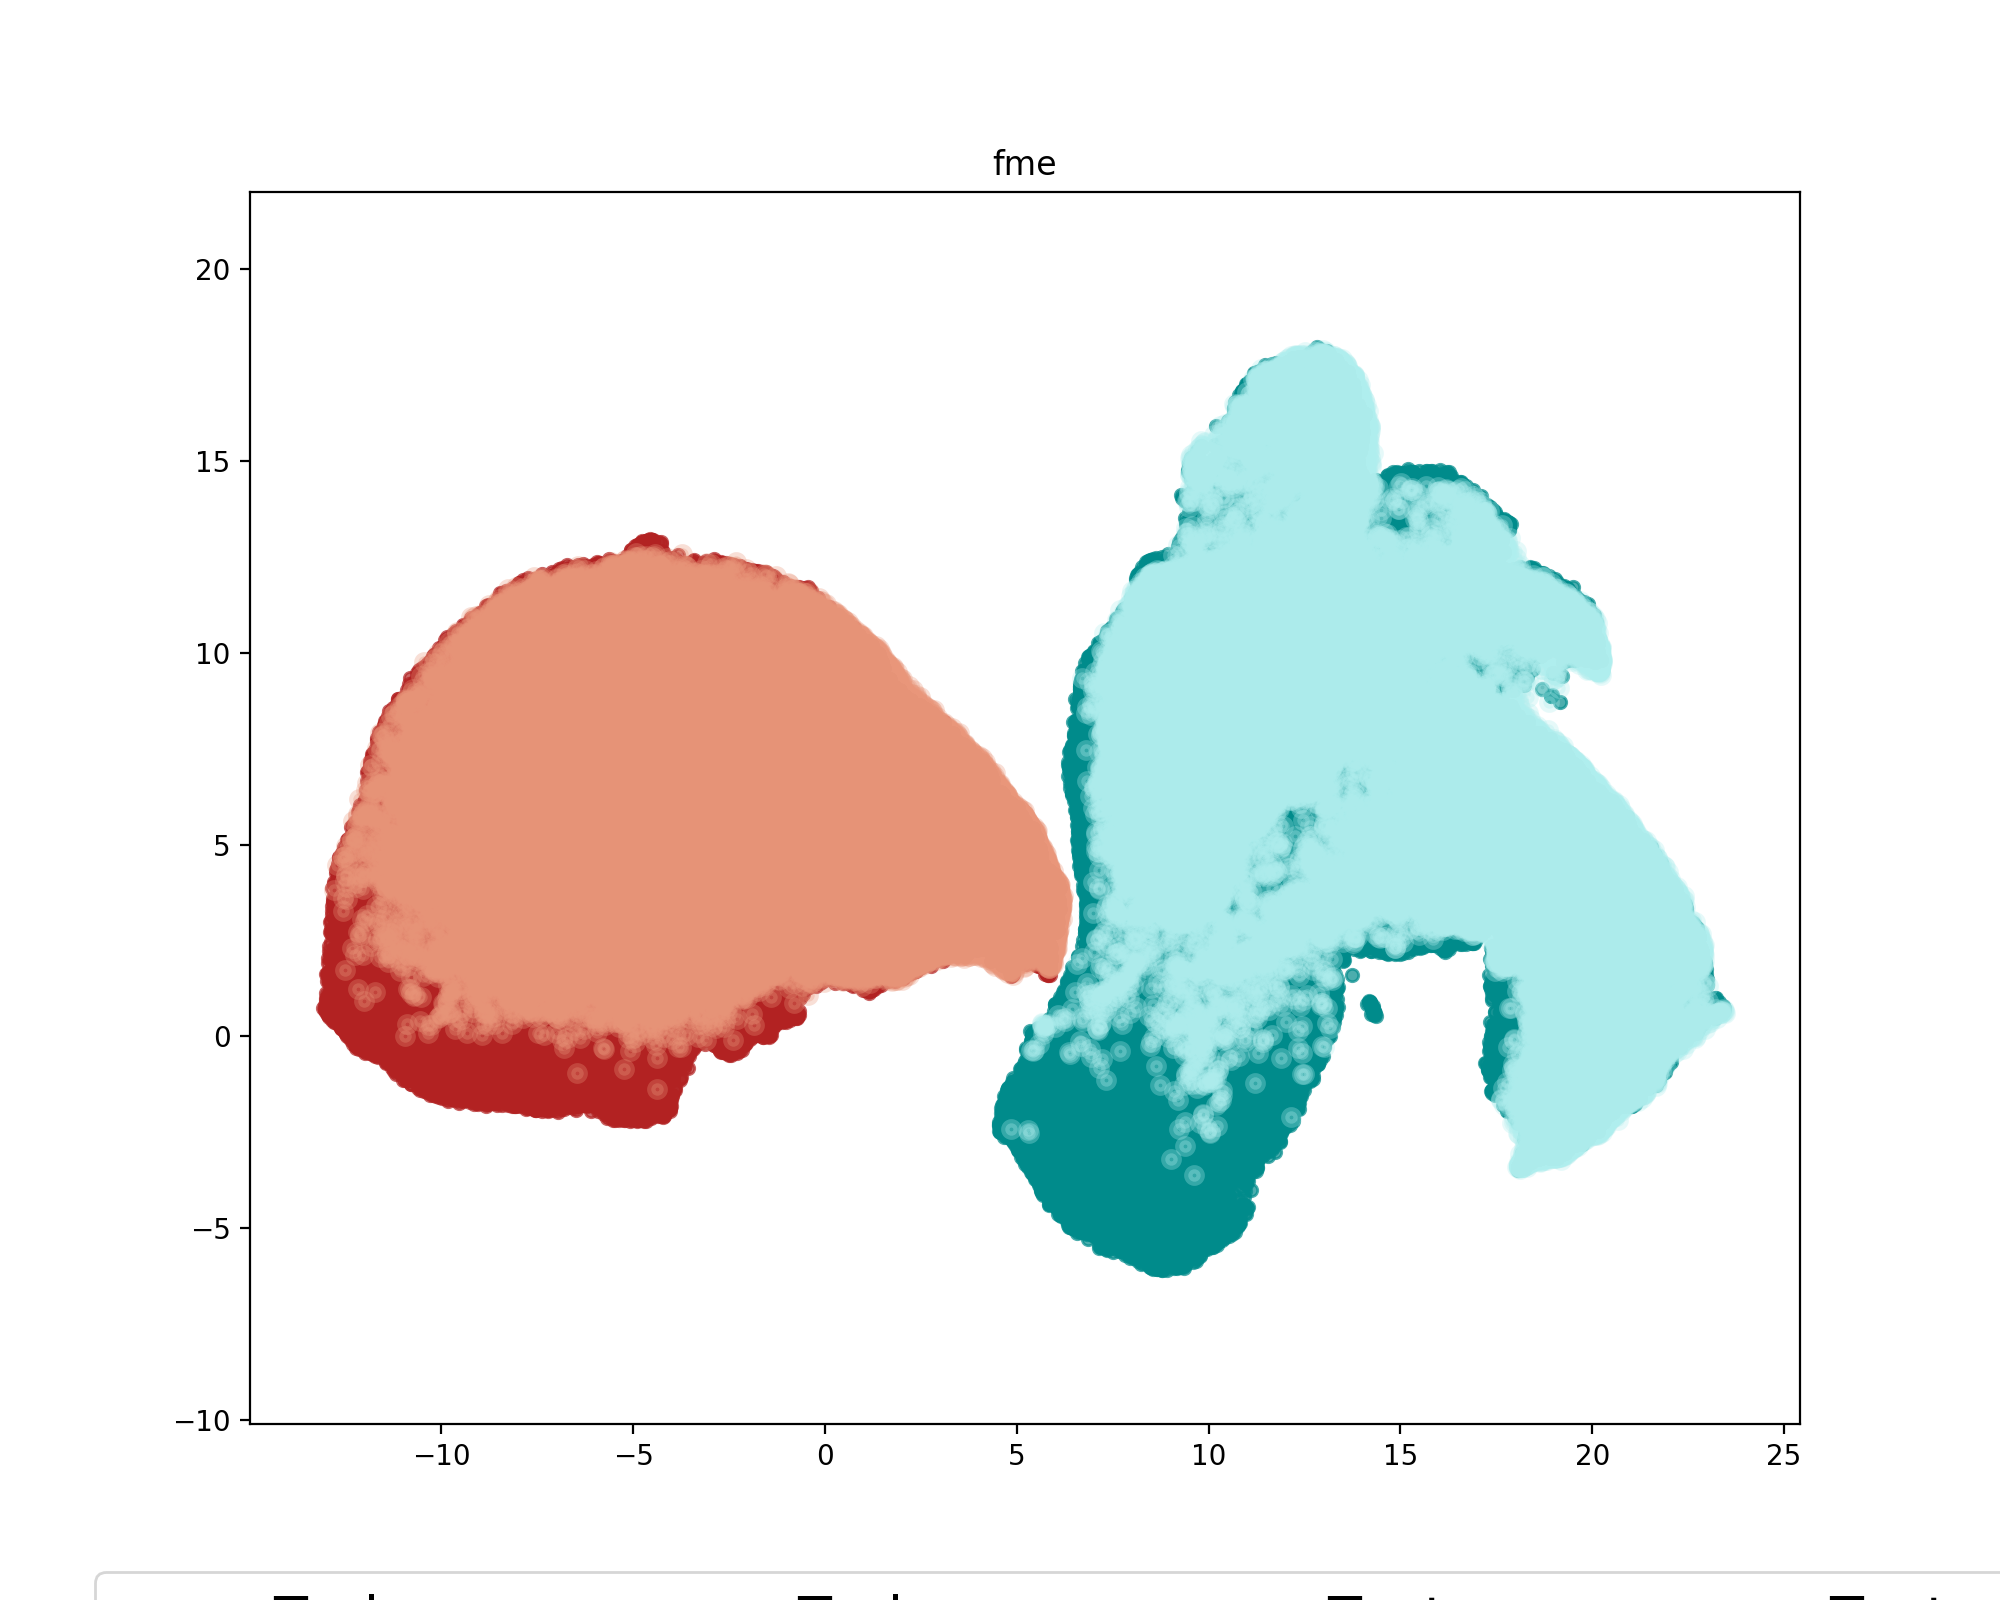

fle


<IPython.core.display.Javascript object>


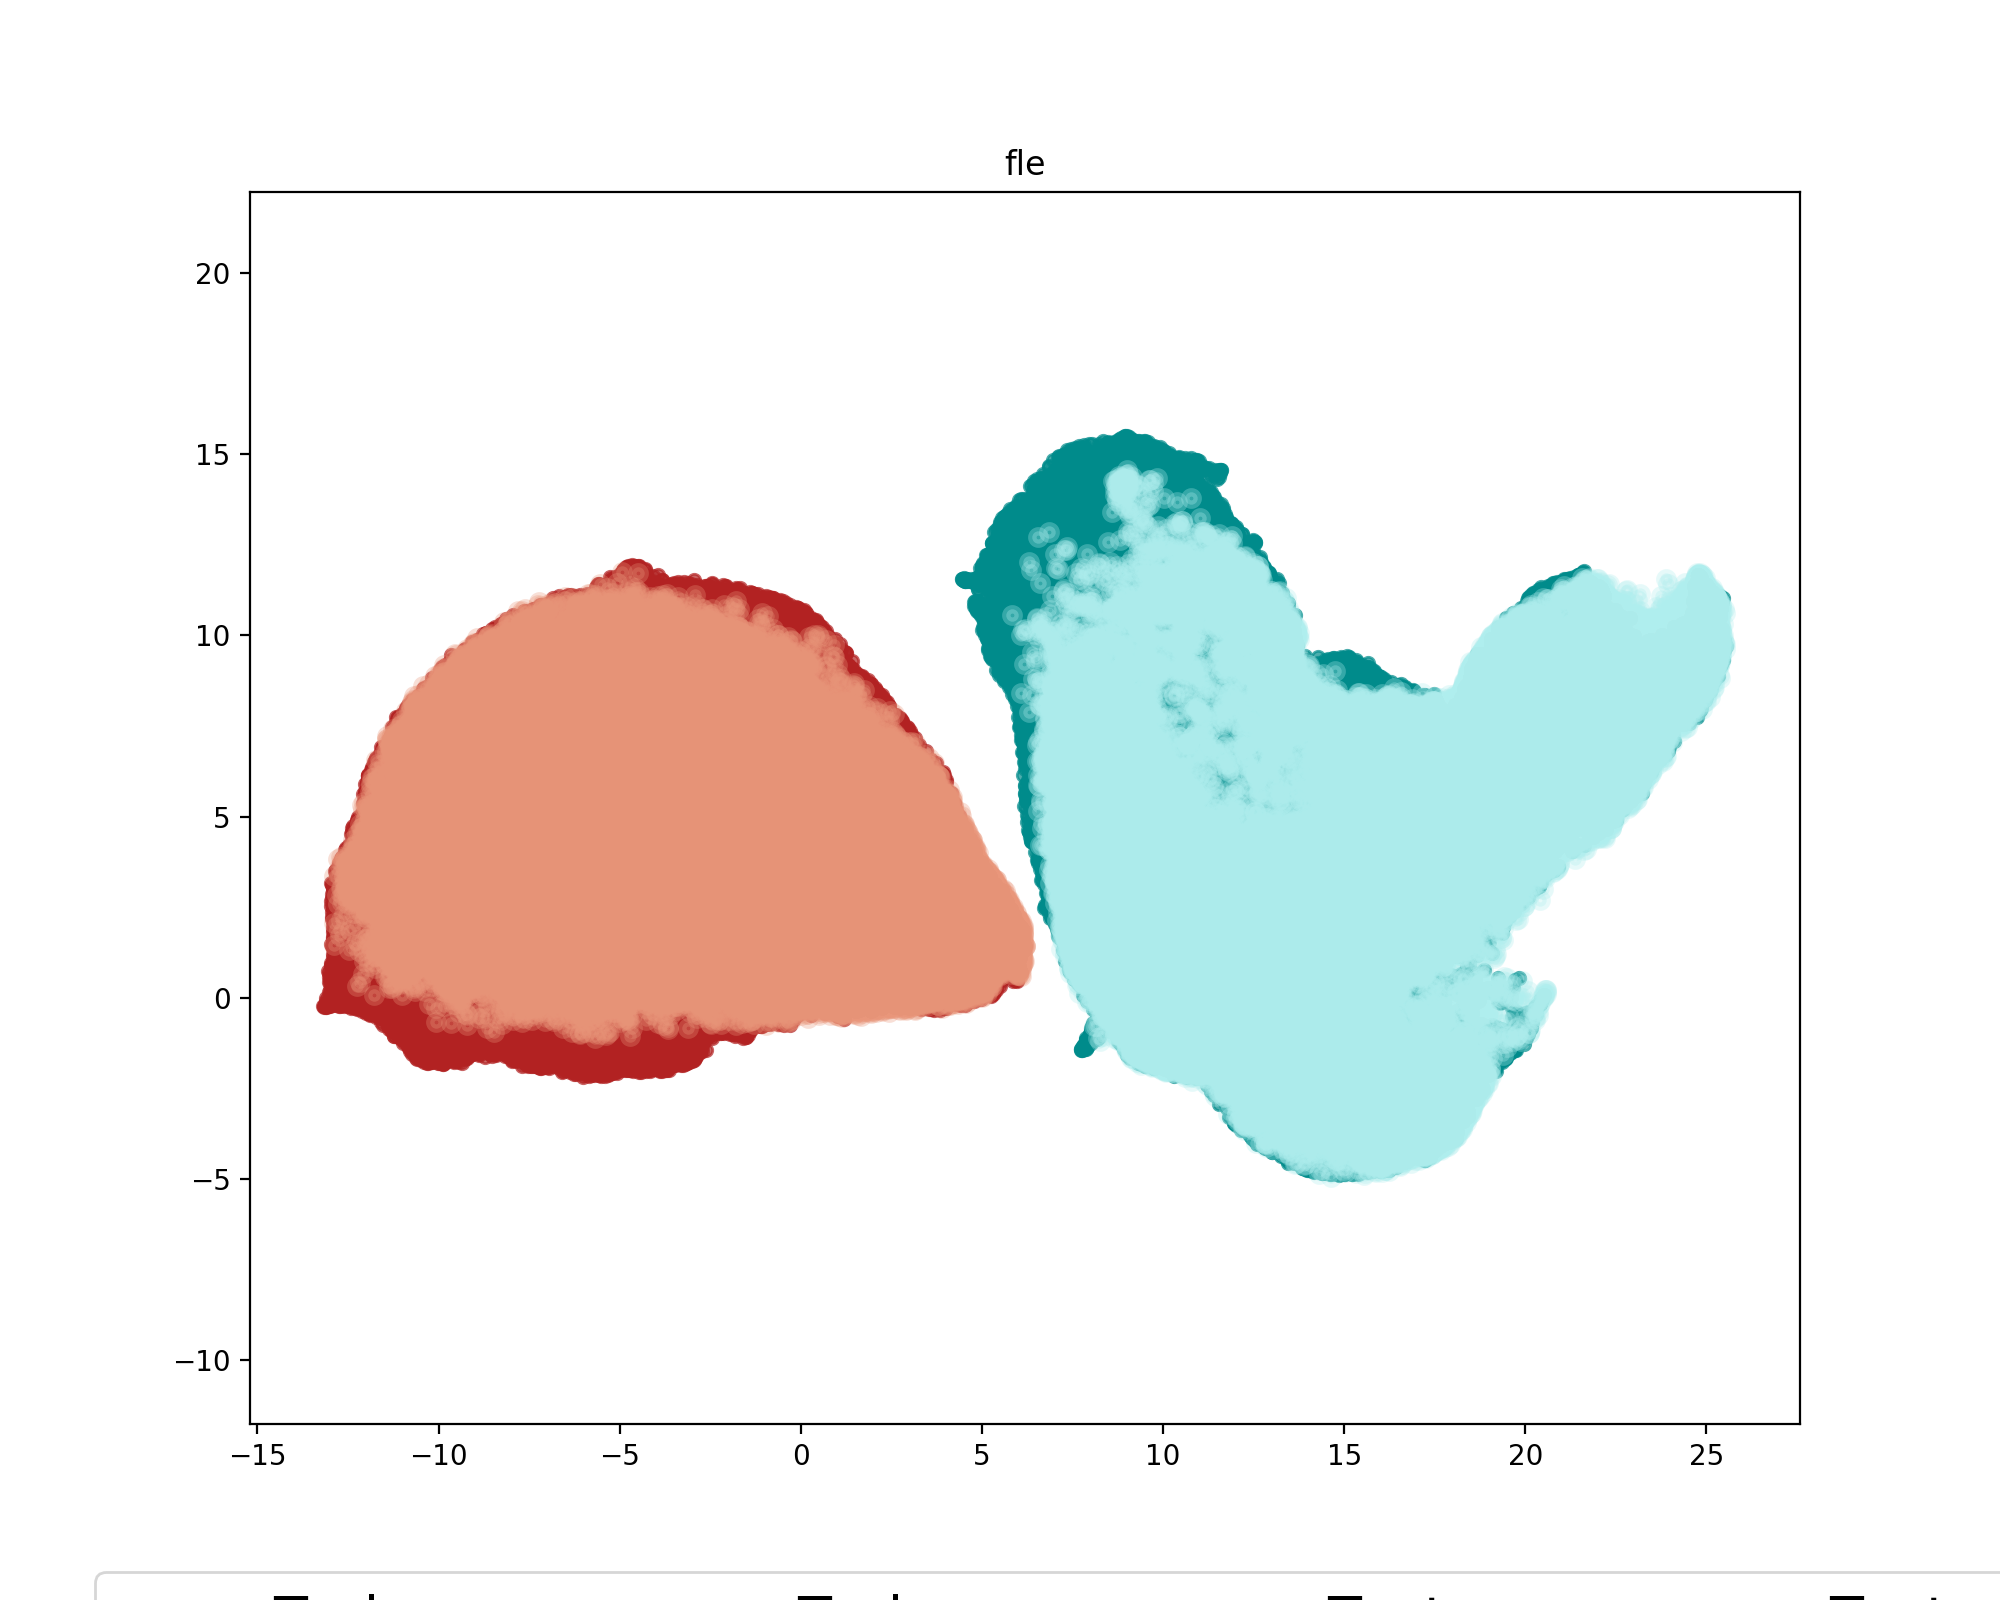

ftc


<IPython.core.display.Javascript object>


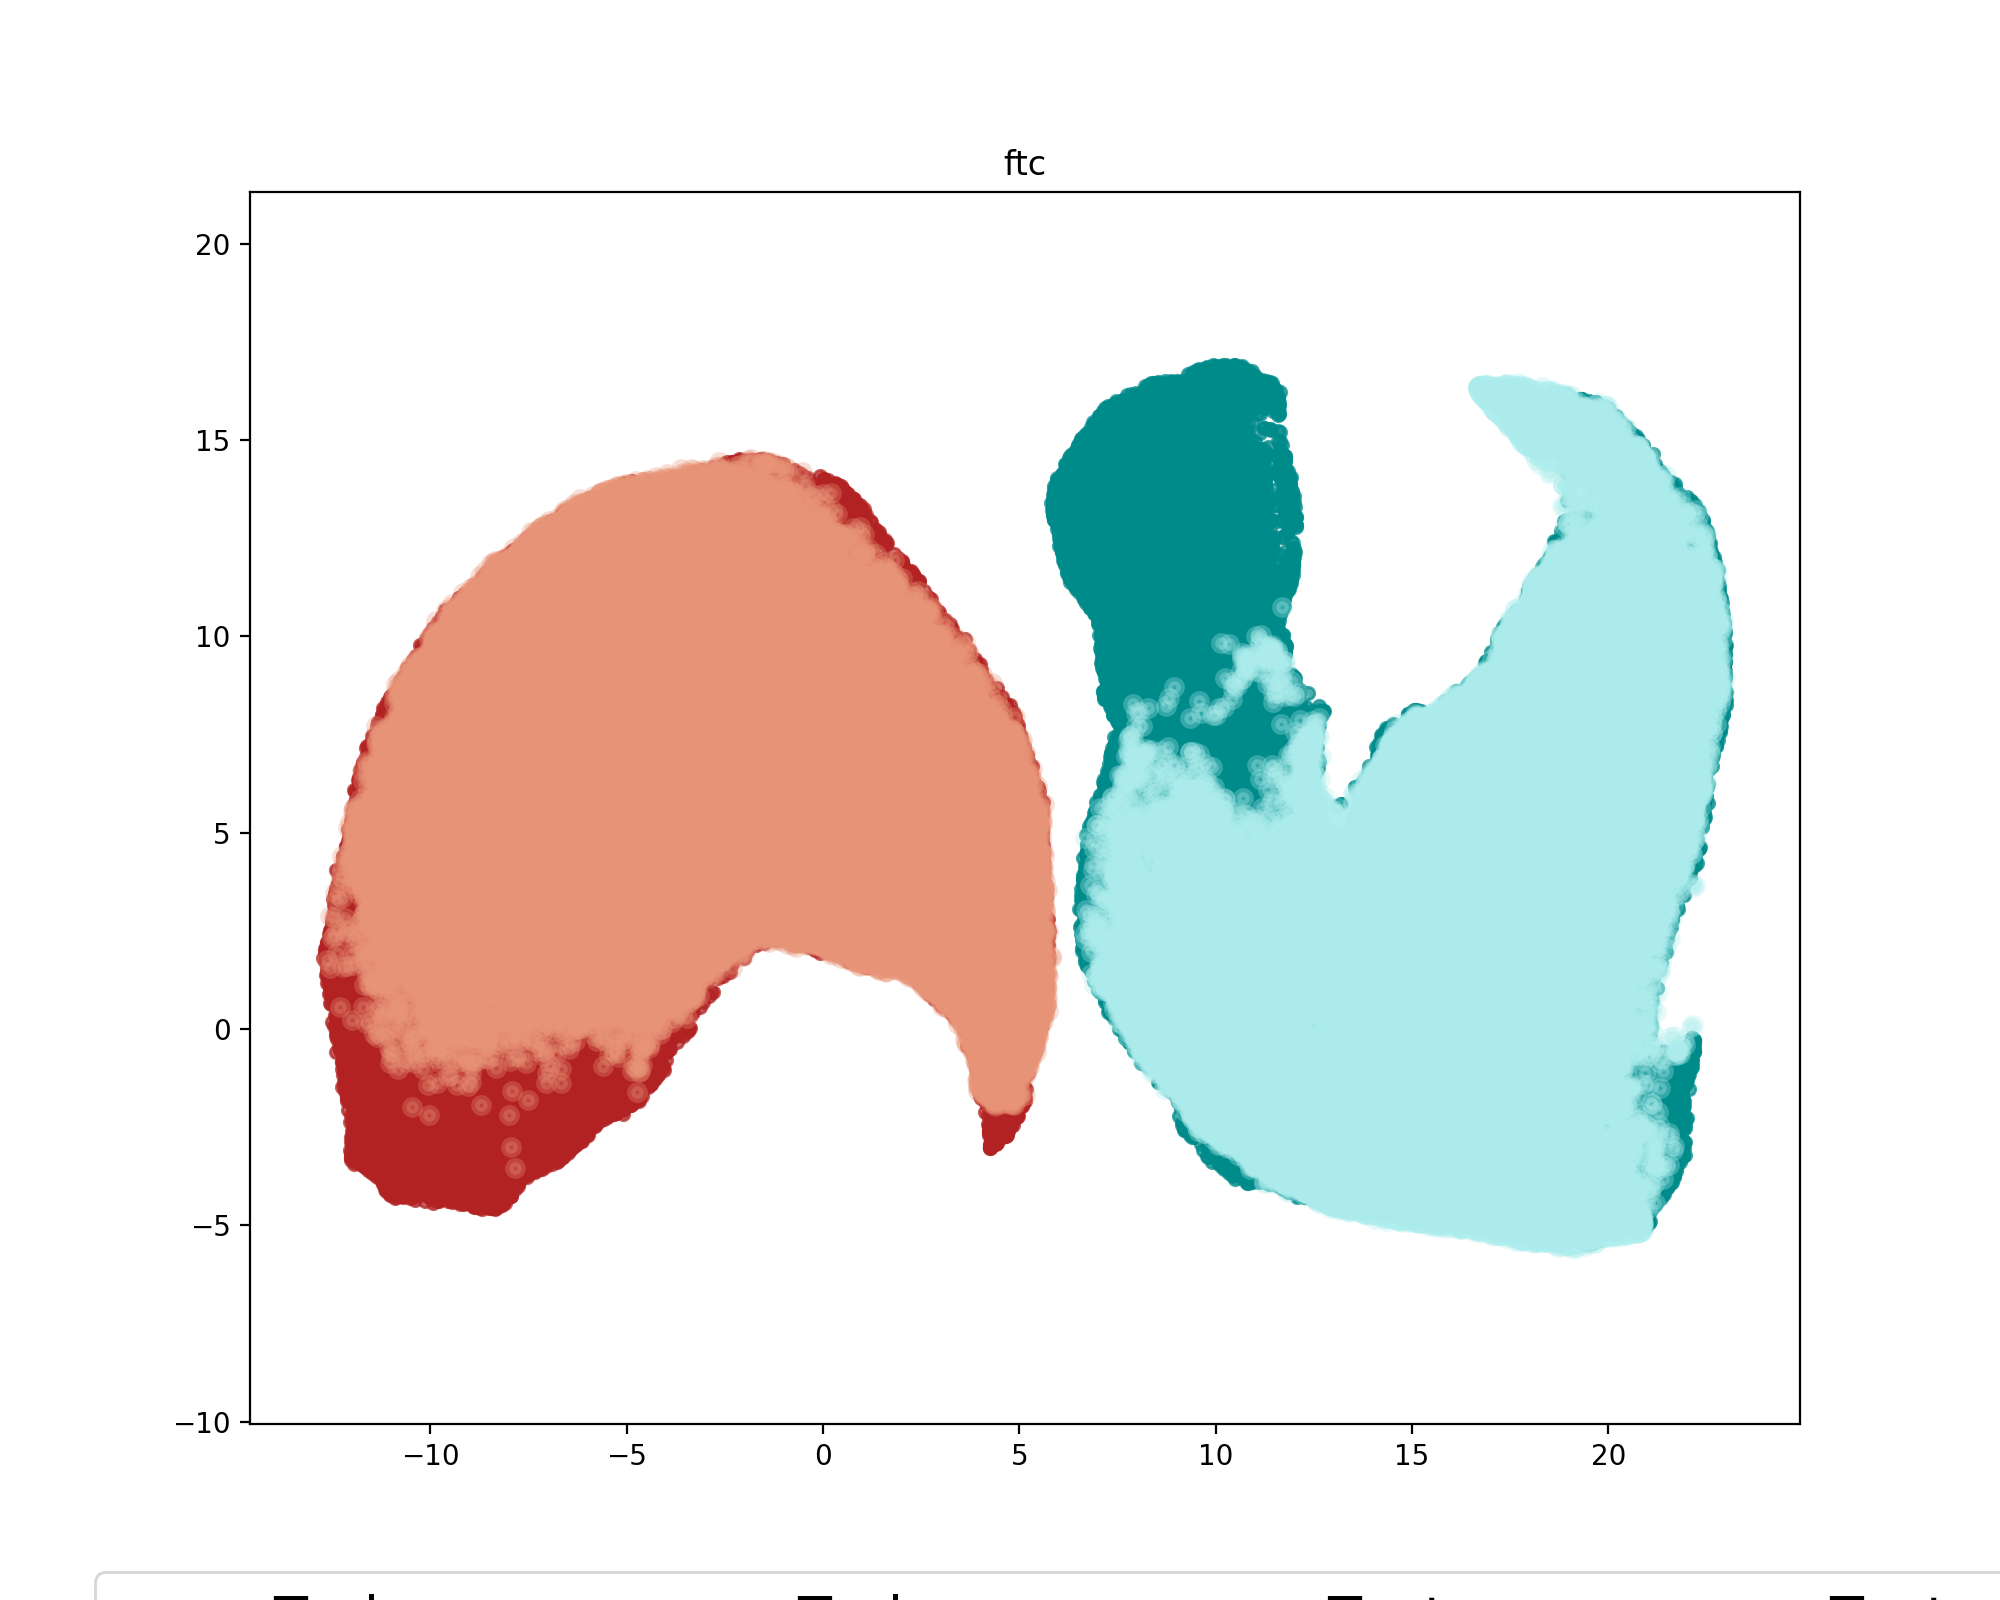

fax


<IPython.core.display.Javascript object>


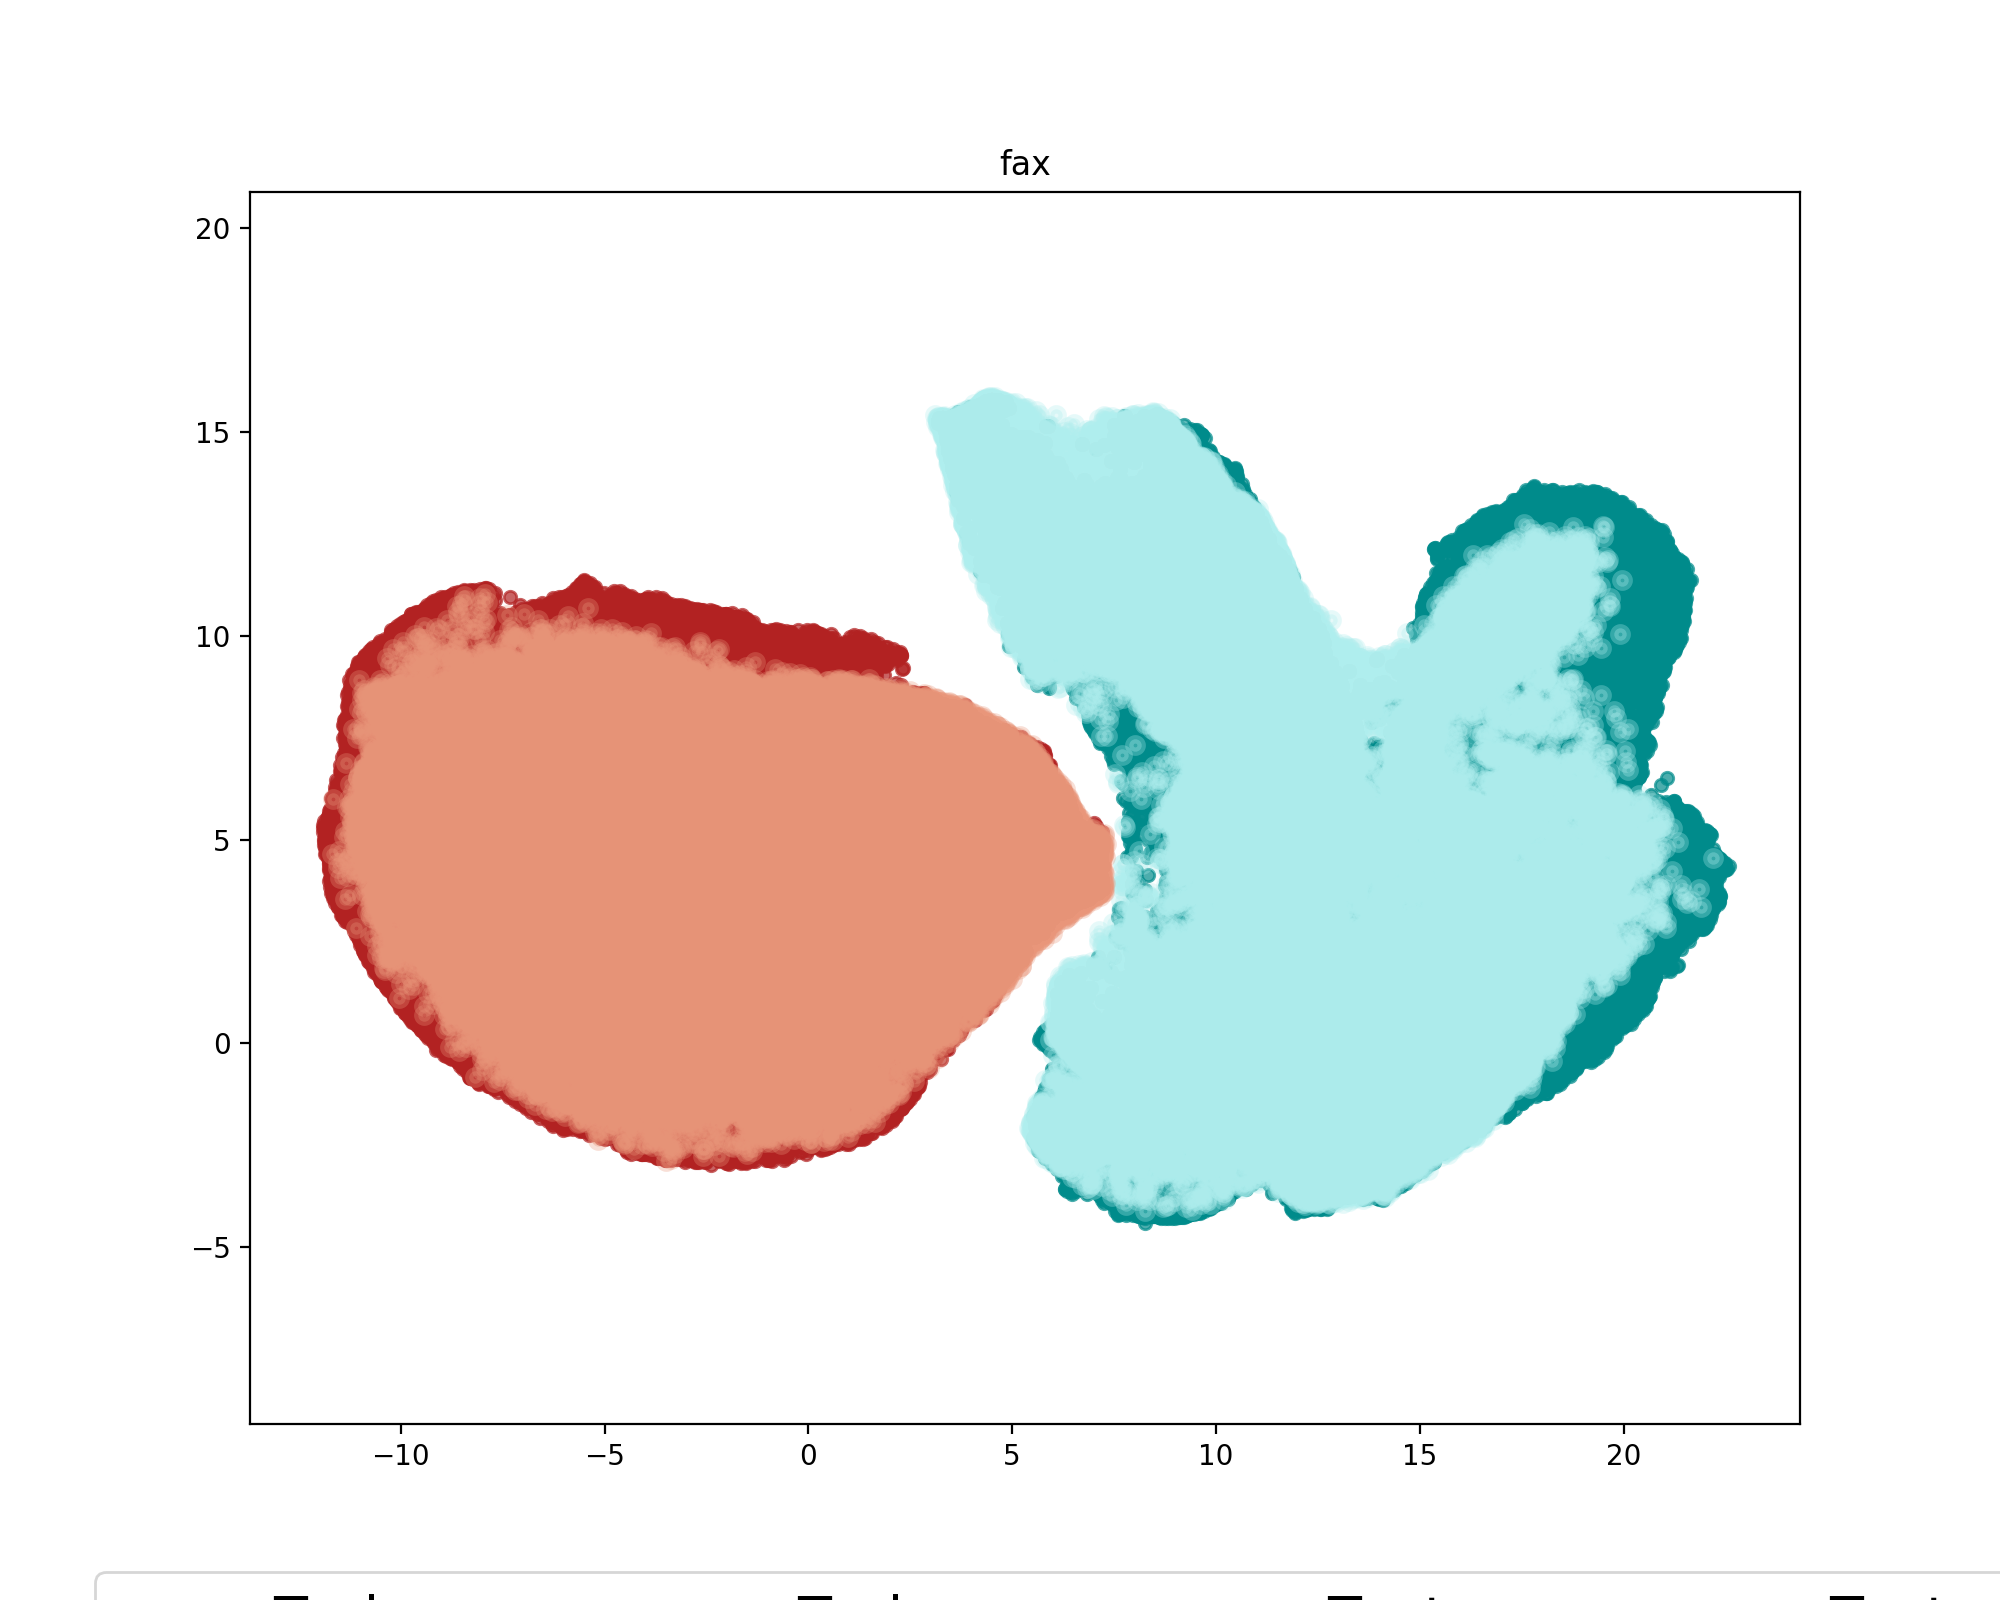

imu


<IPython.core.display.Javascript object>


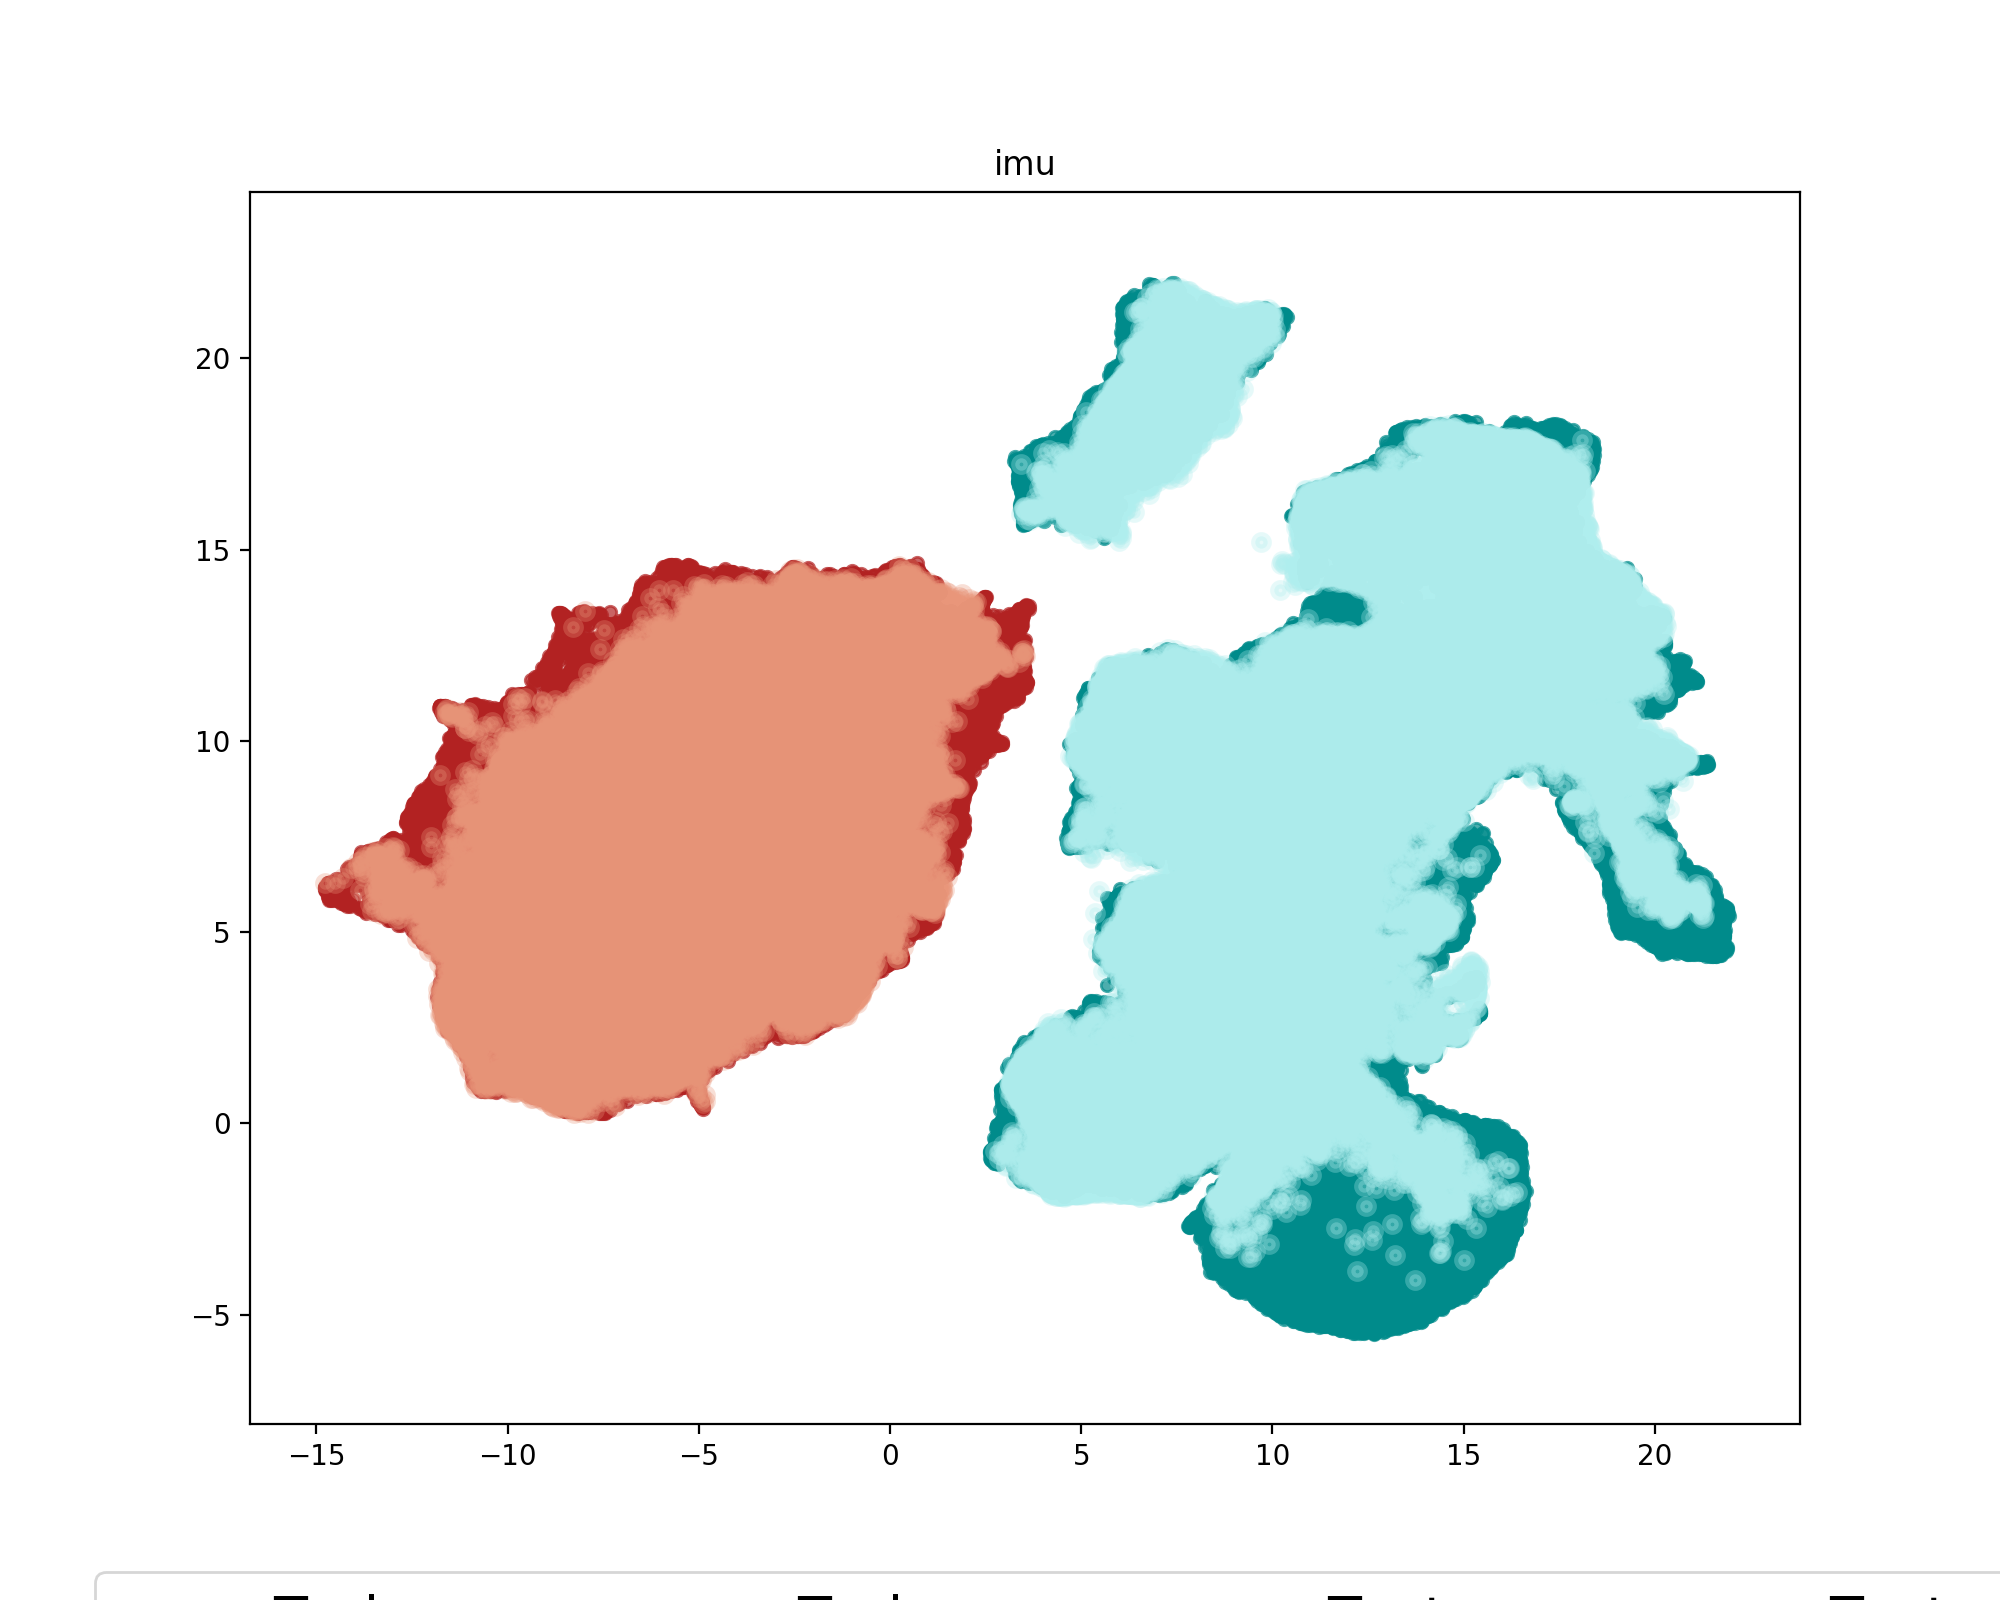

ias


<IPython.core.display.Javascript object>


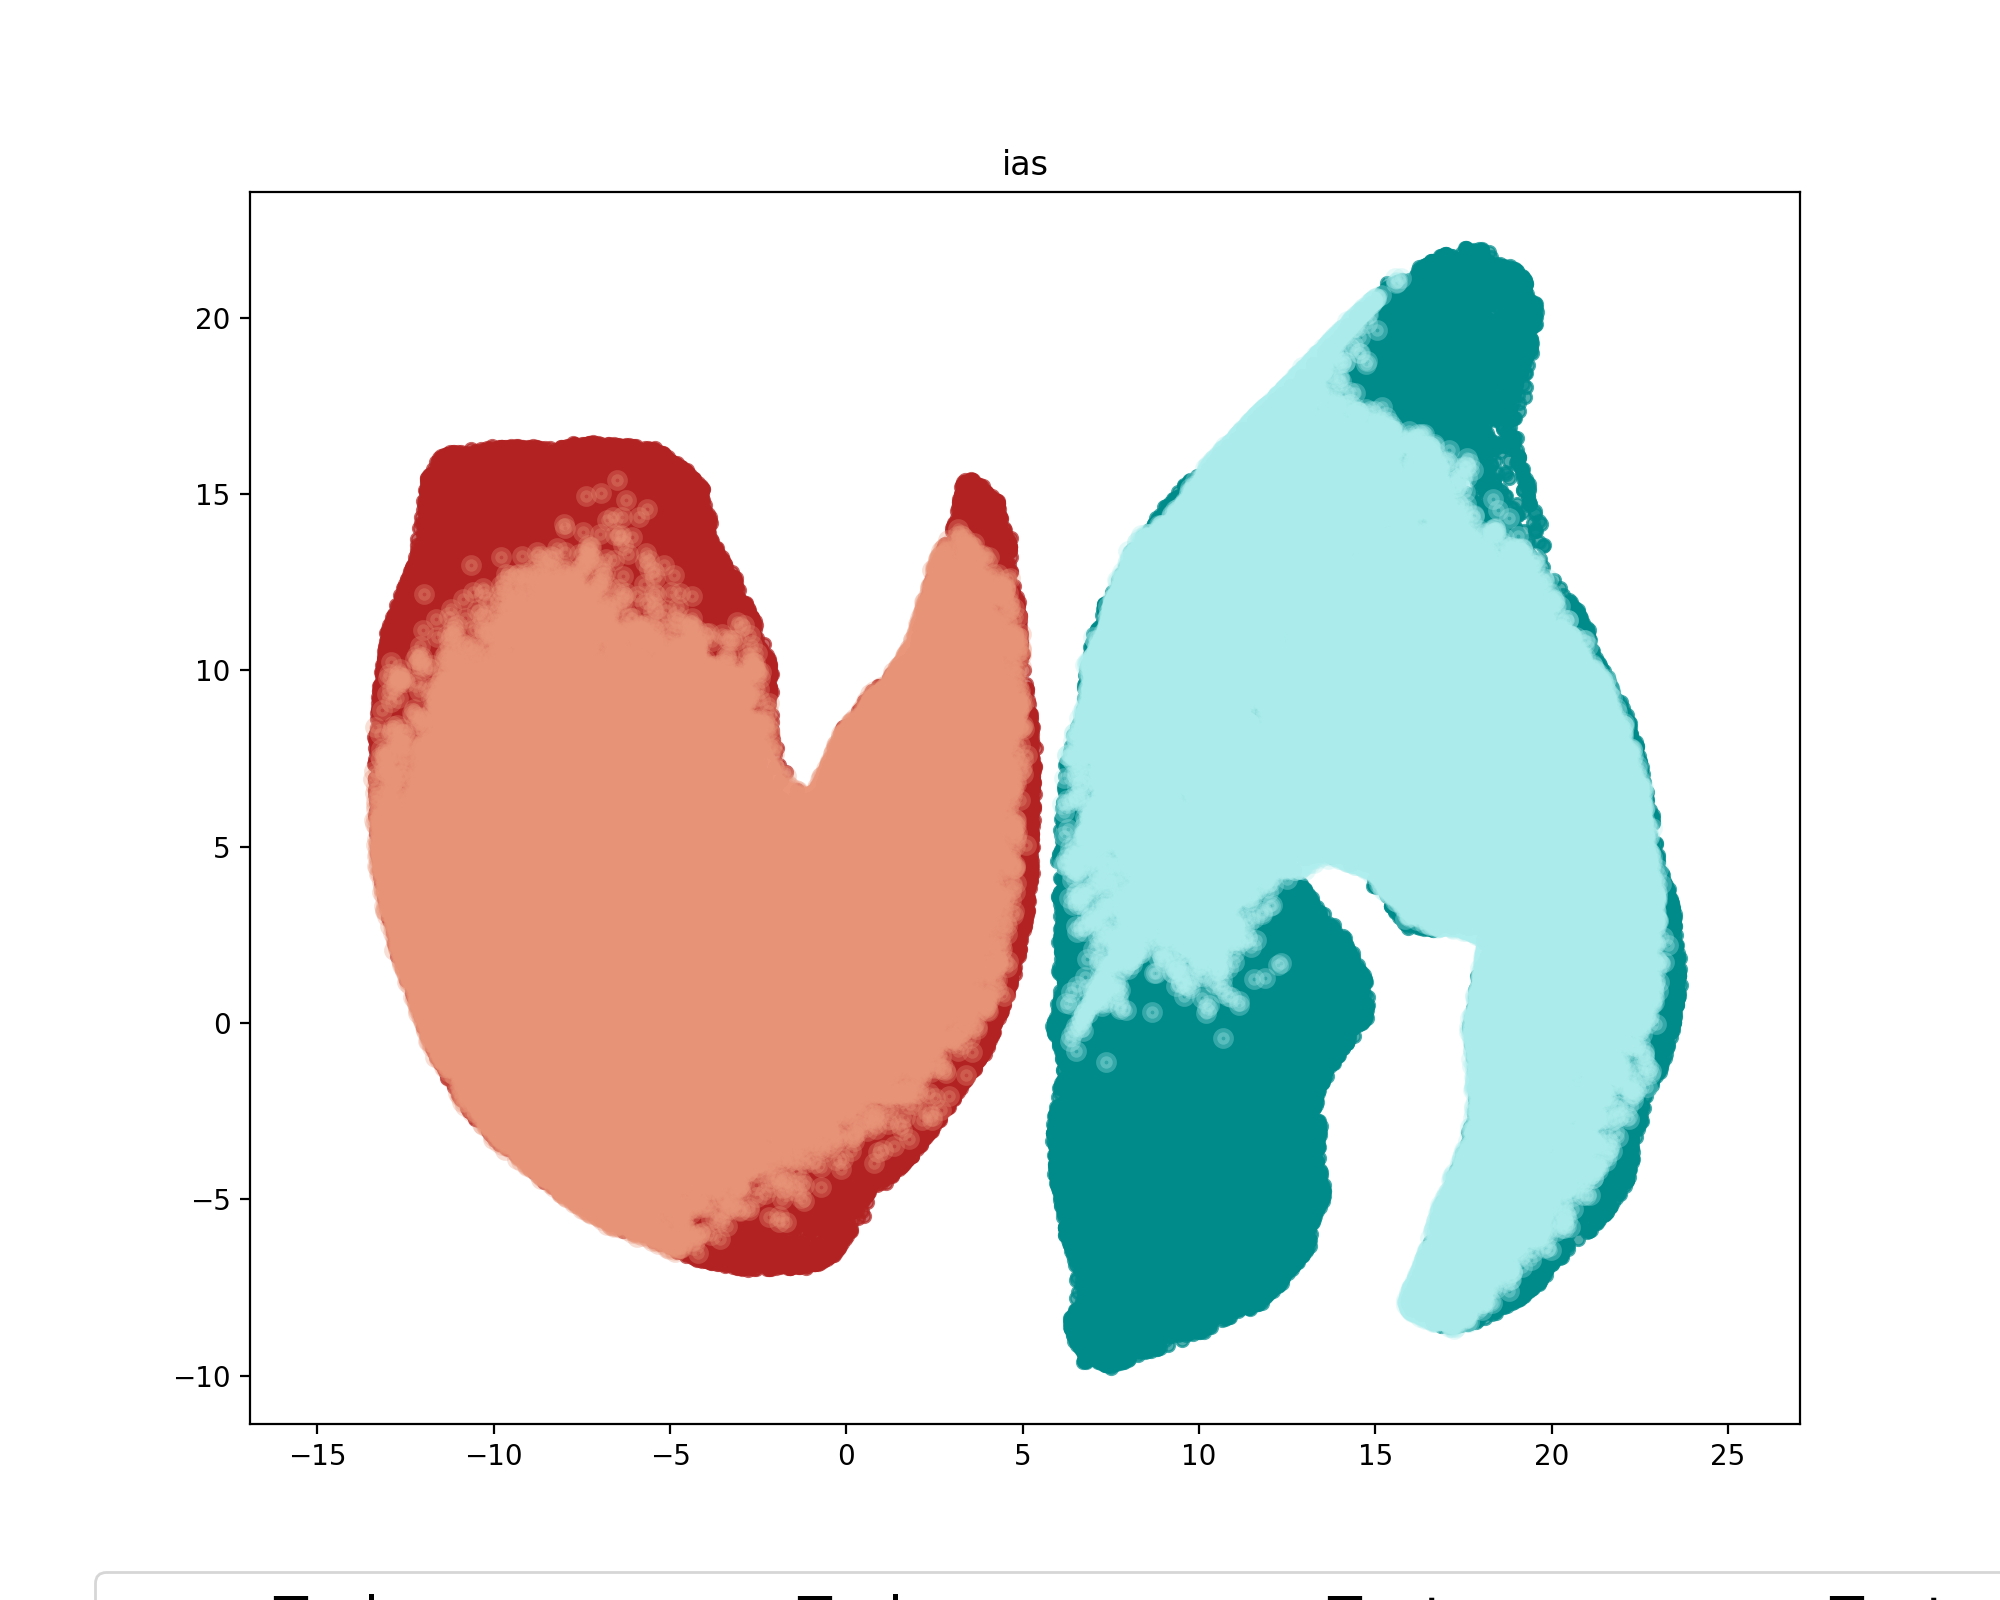

ttc


<IPython.core.display.Javascript object>


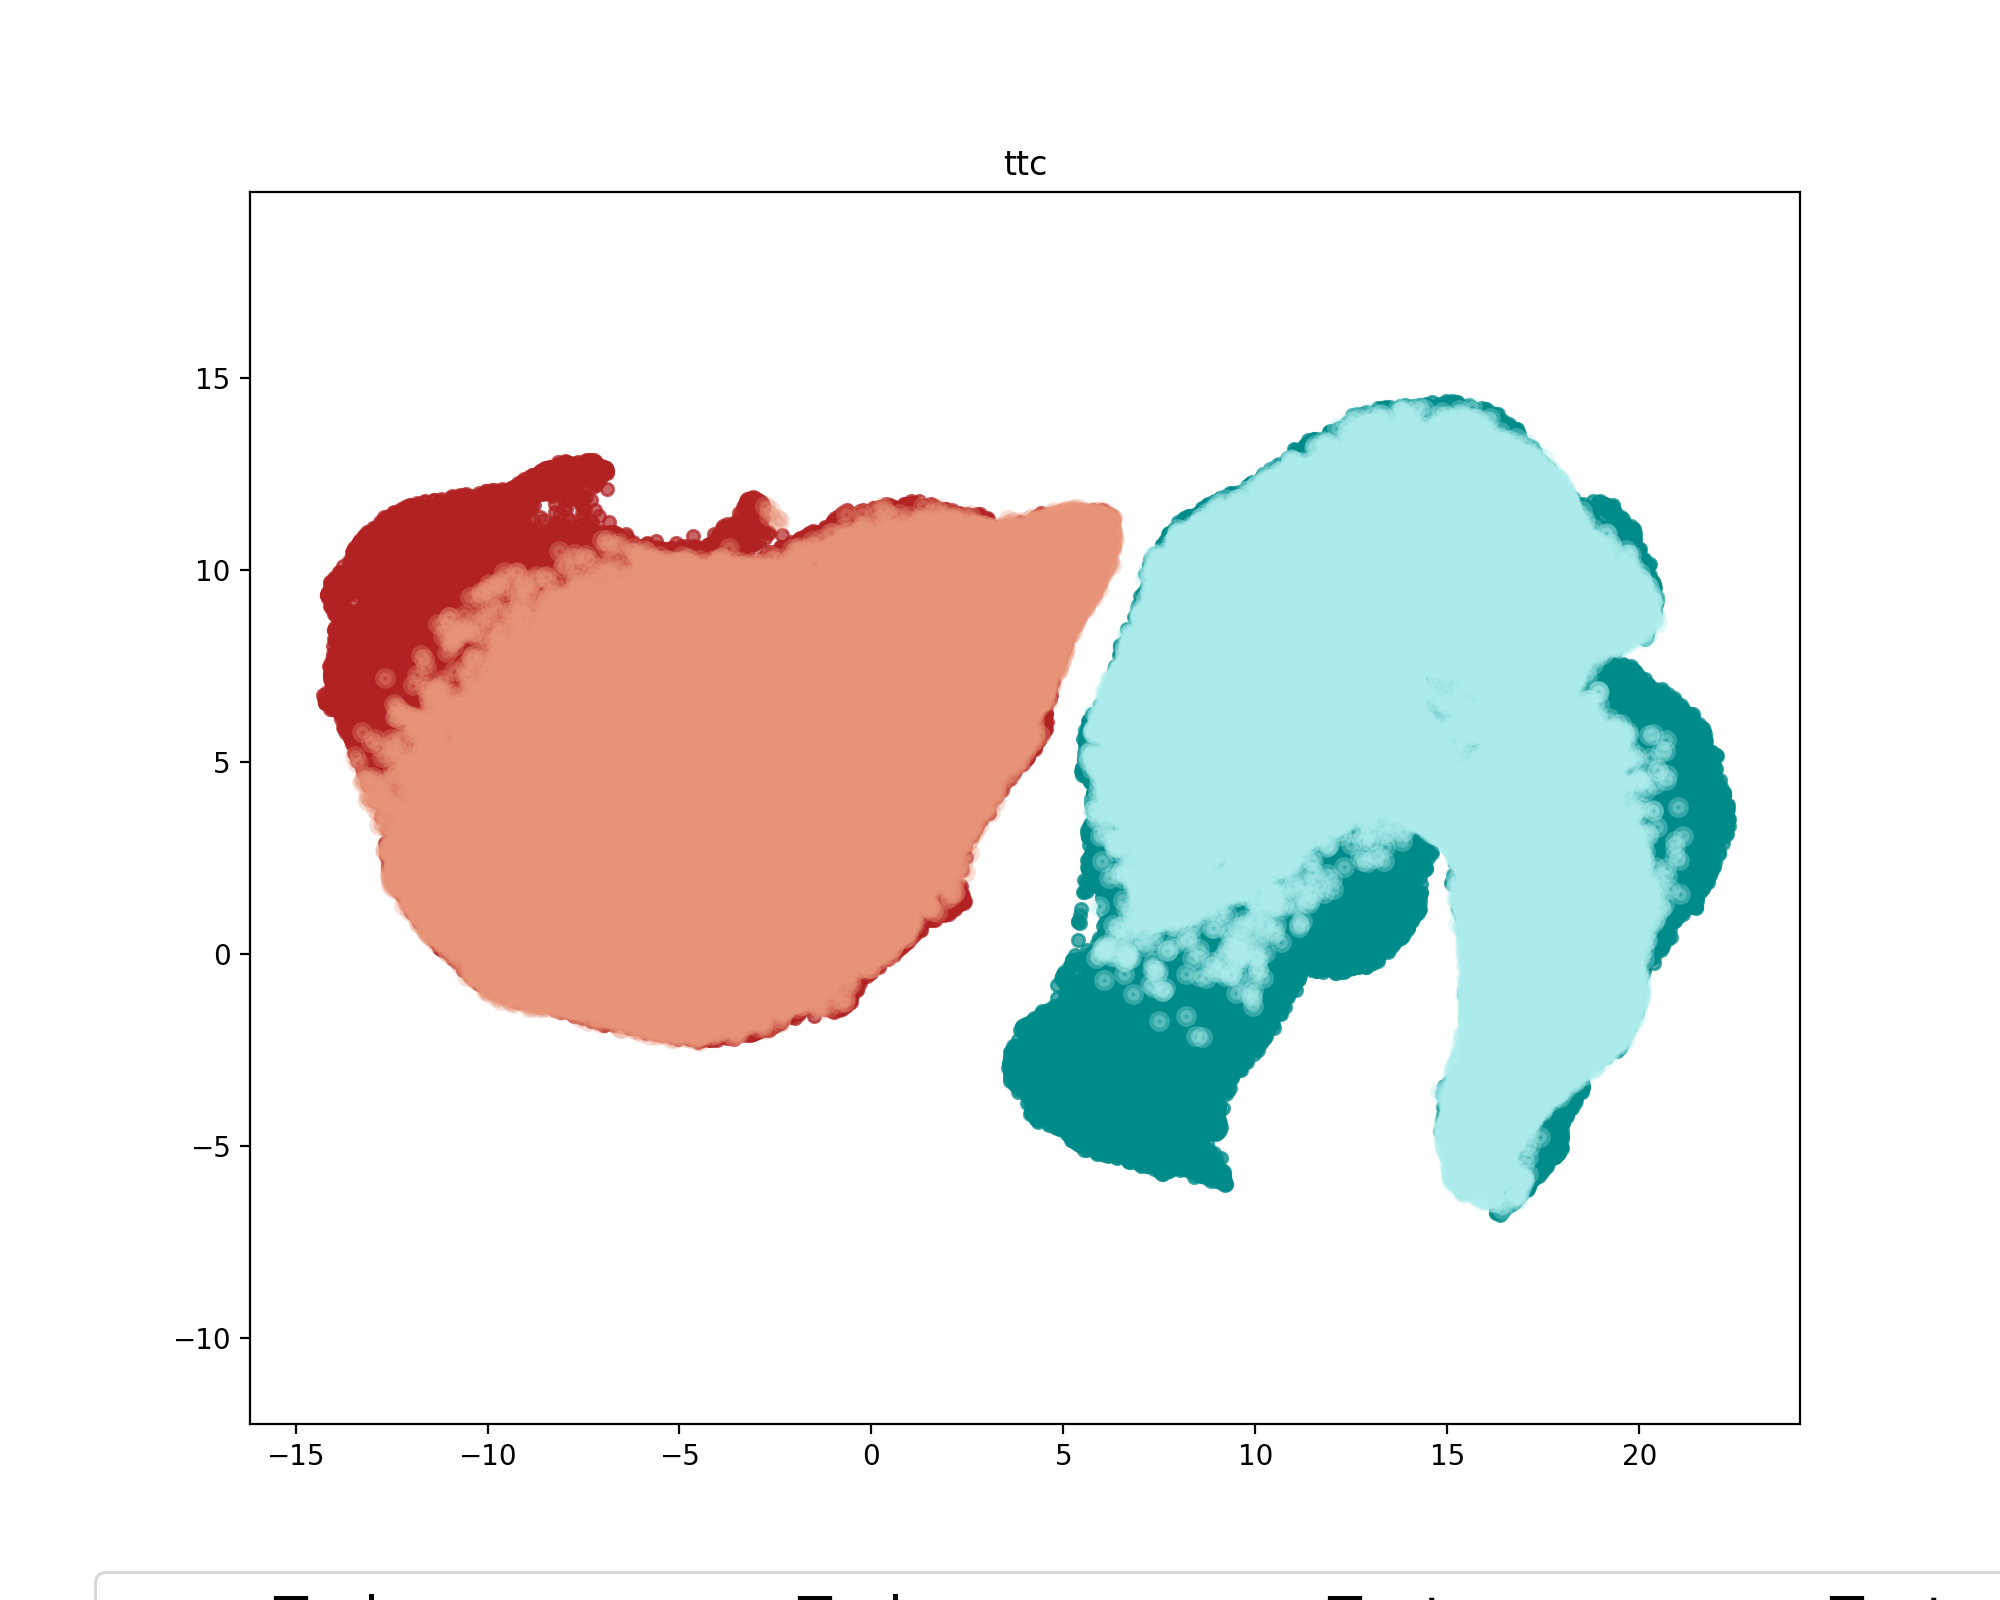

fle_fax


<IPython.core.display.Javascript object>


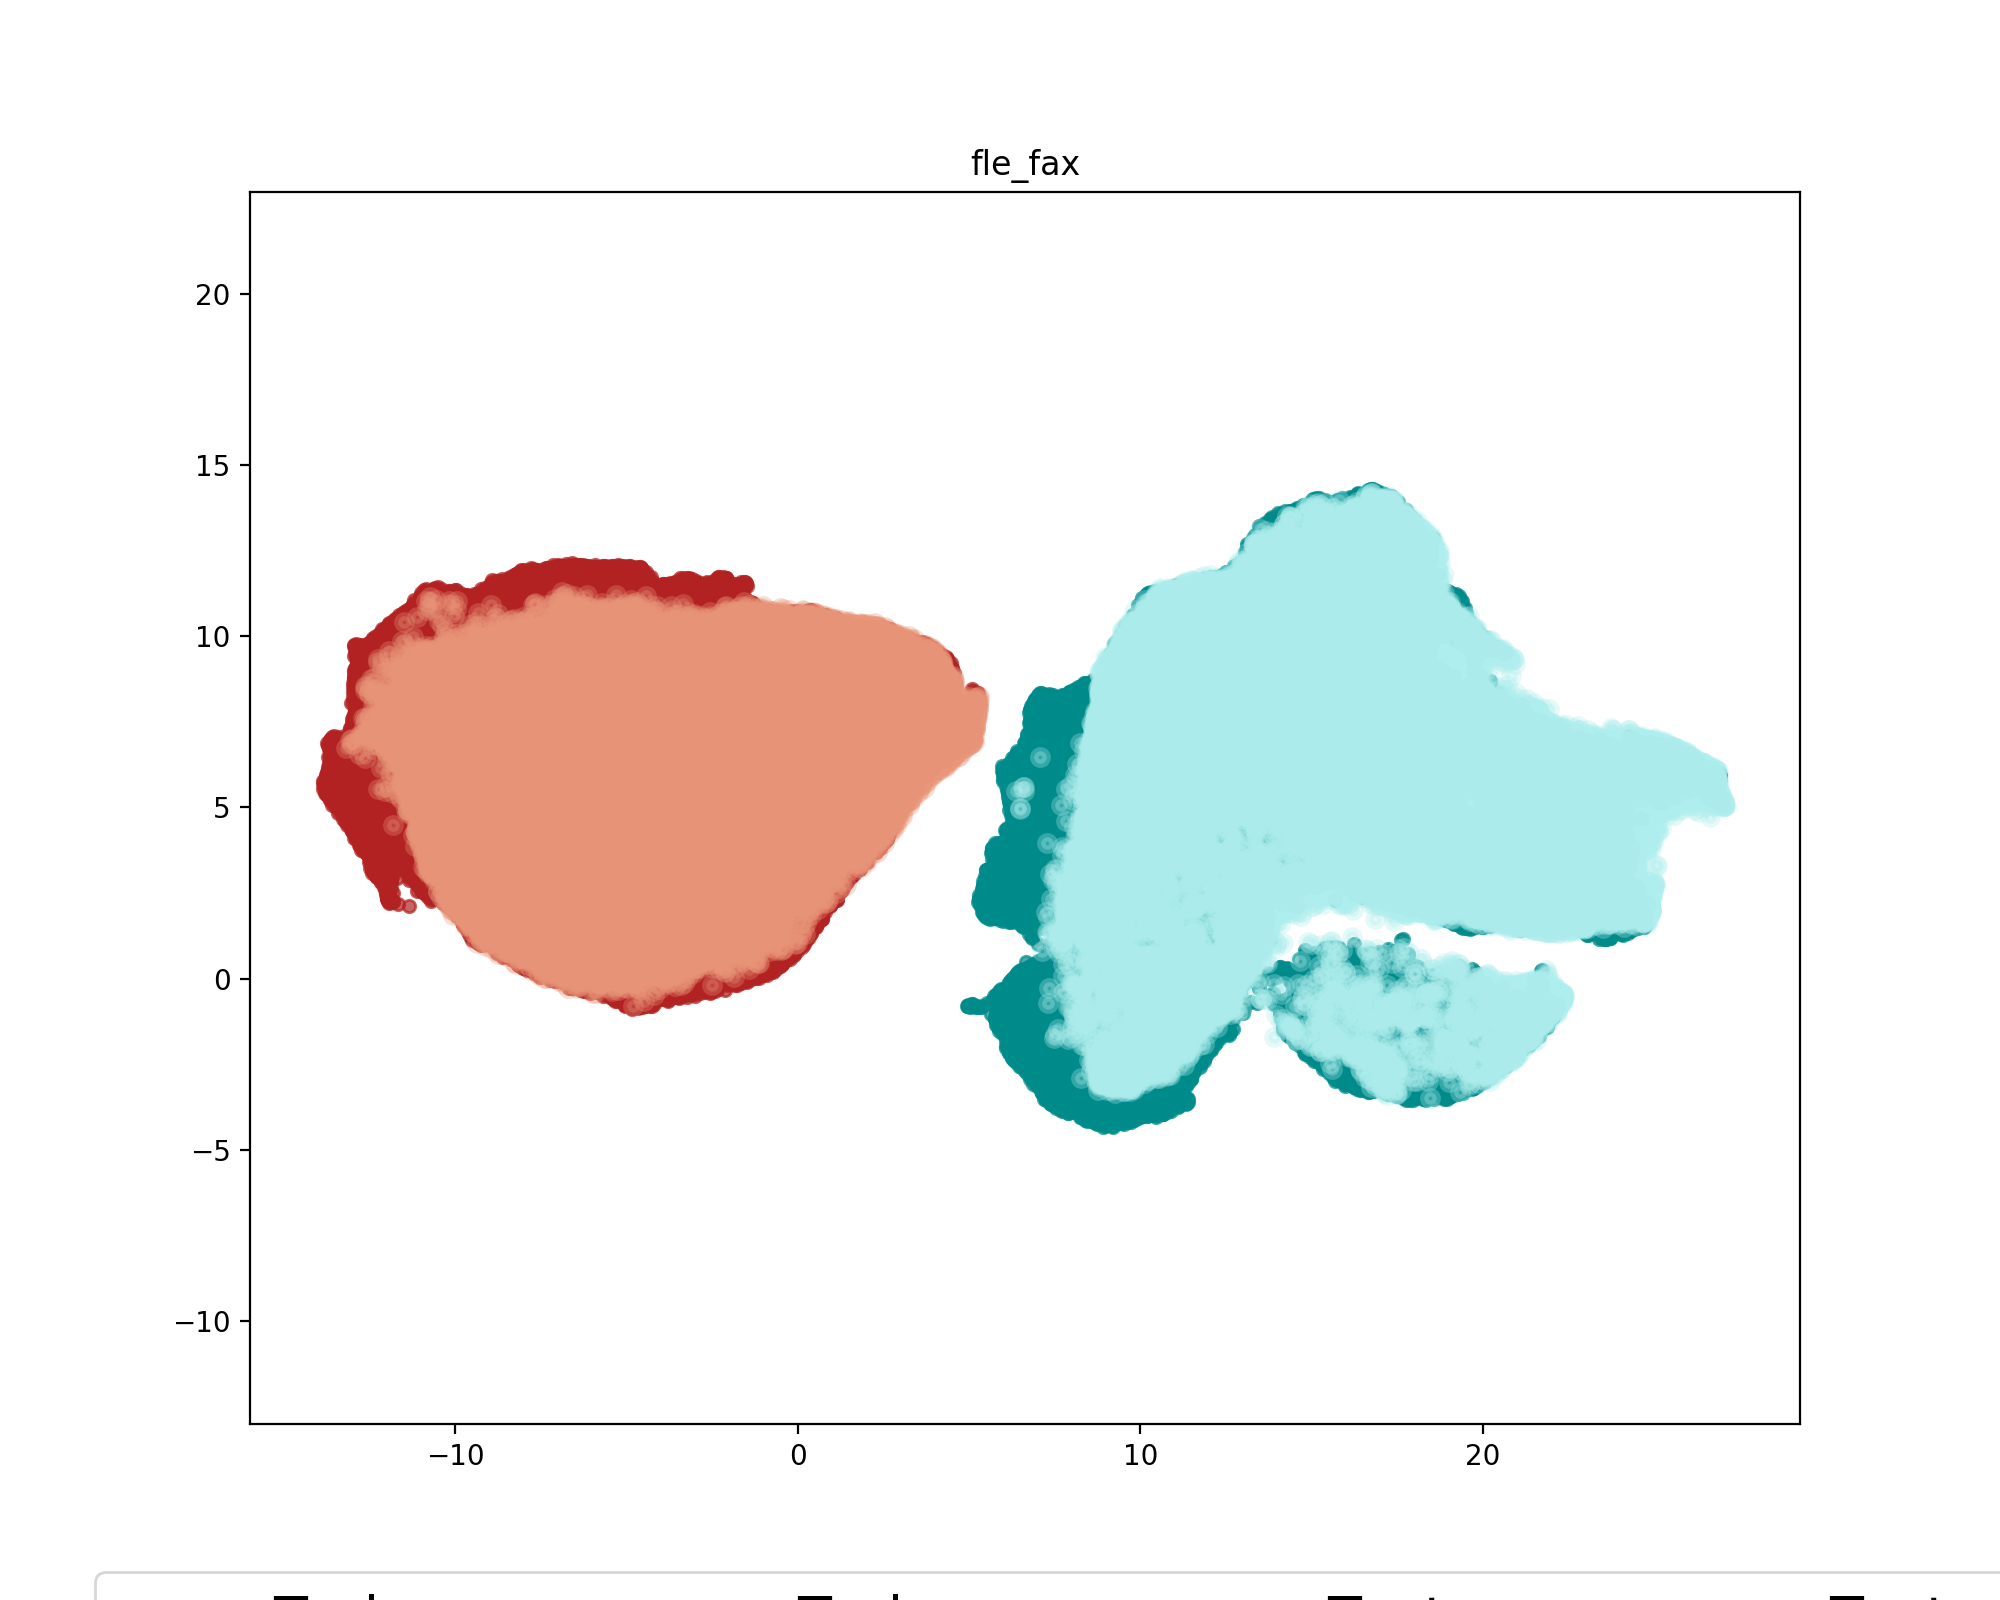

ftc_fle


<IPython.core.display.Javascript object>


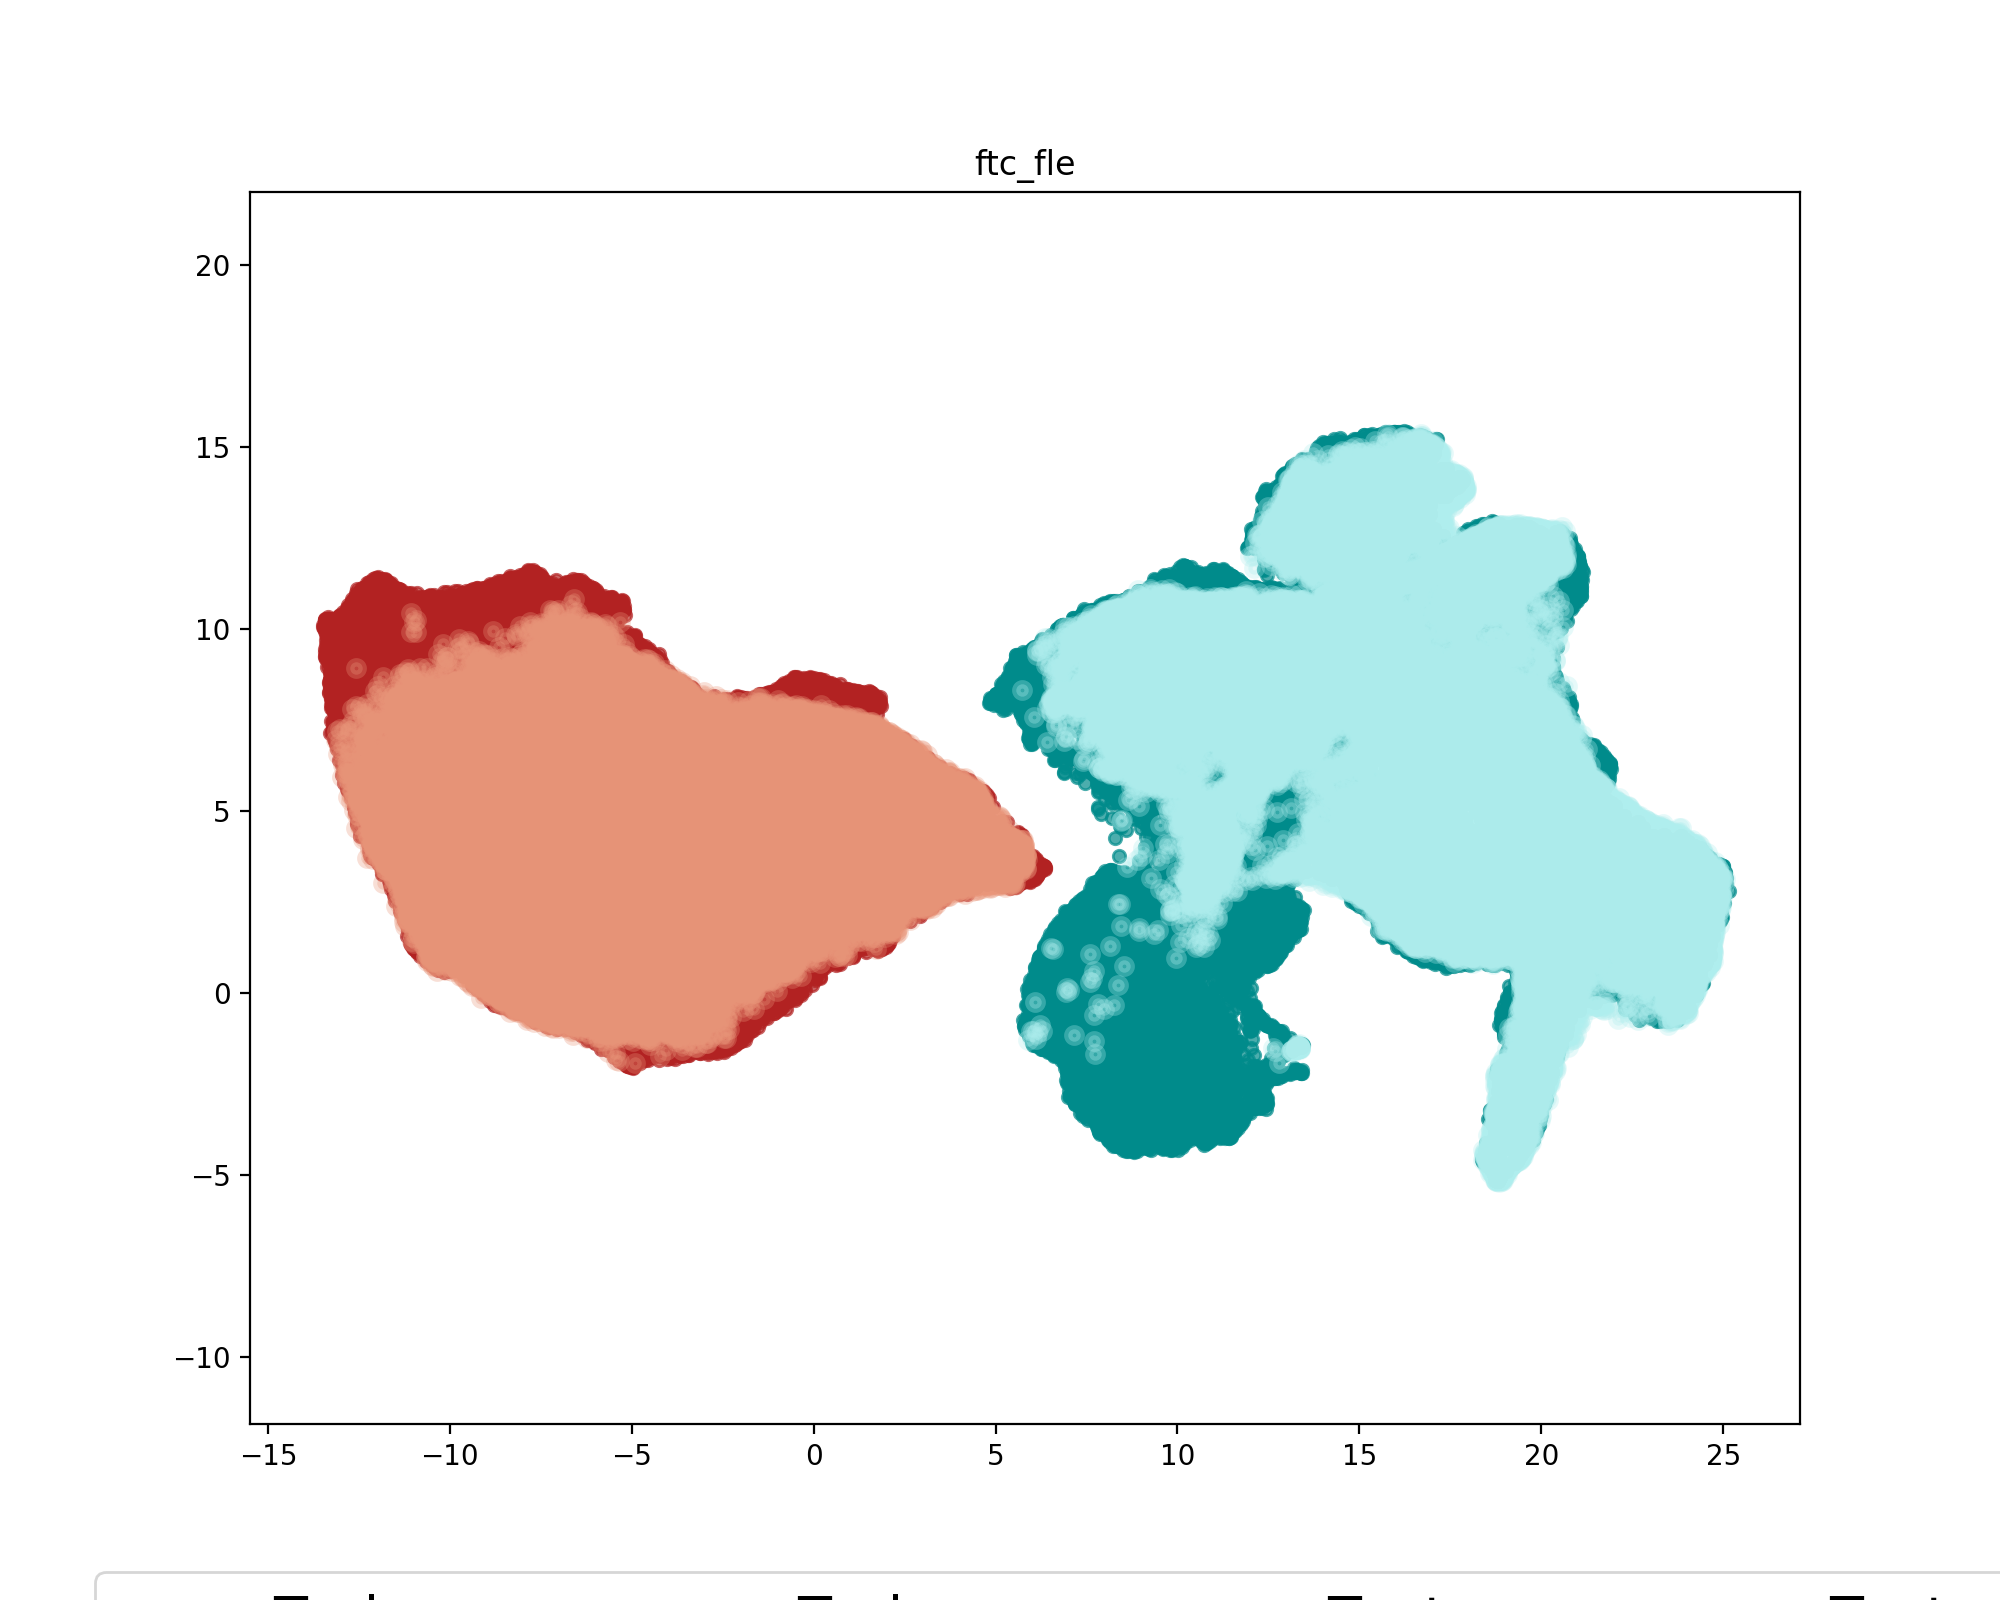

ftc_fle_fax


<IPython.core.display.Javascript object>


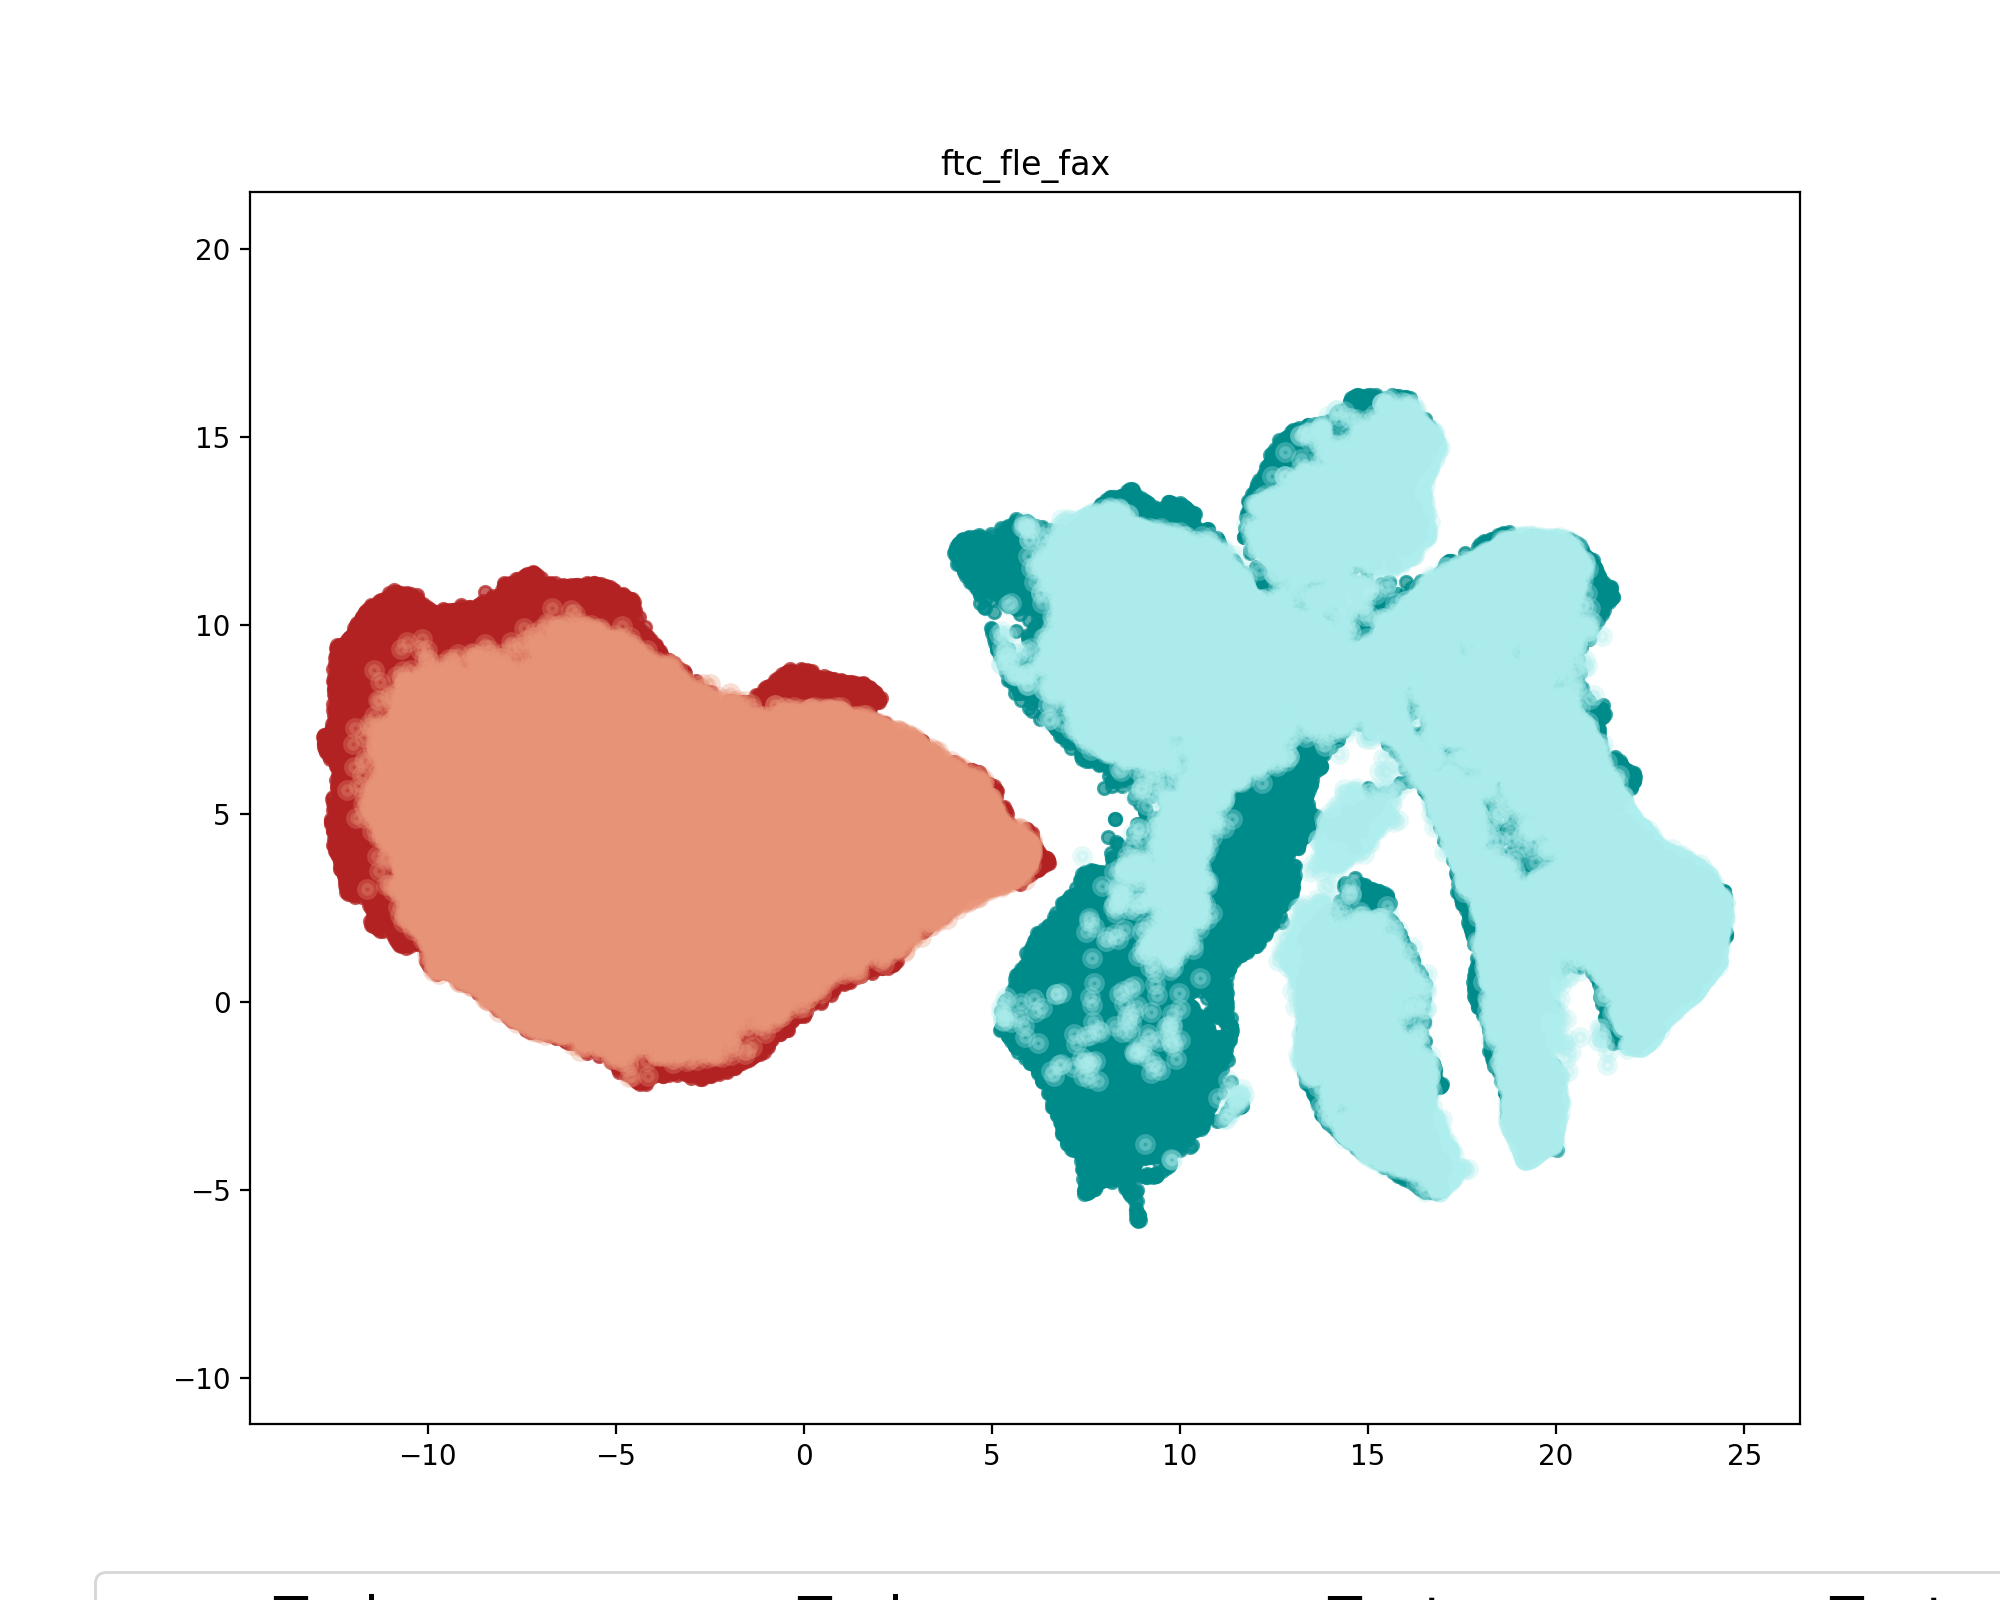

fle_fax_ttc


<IPython.core.display.Javascript object>


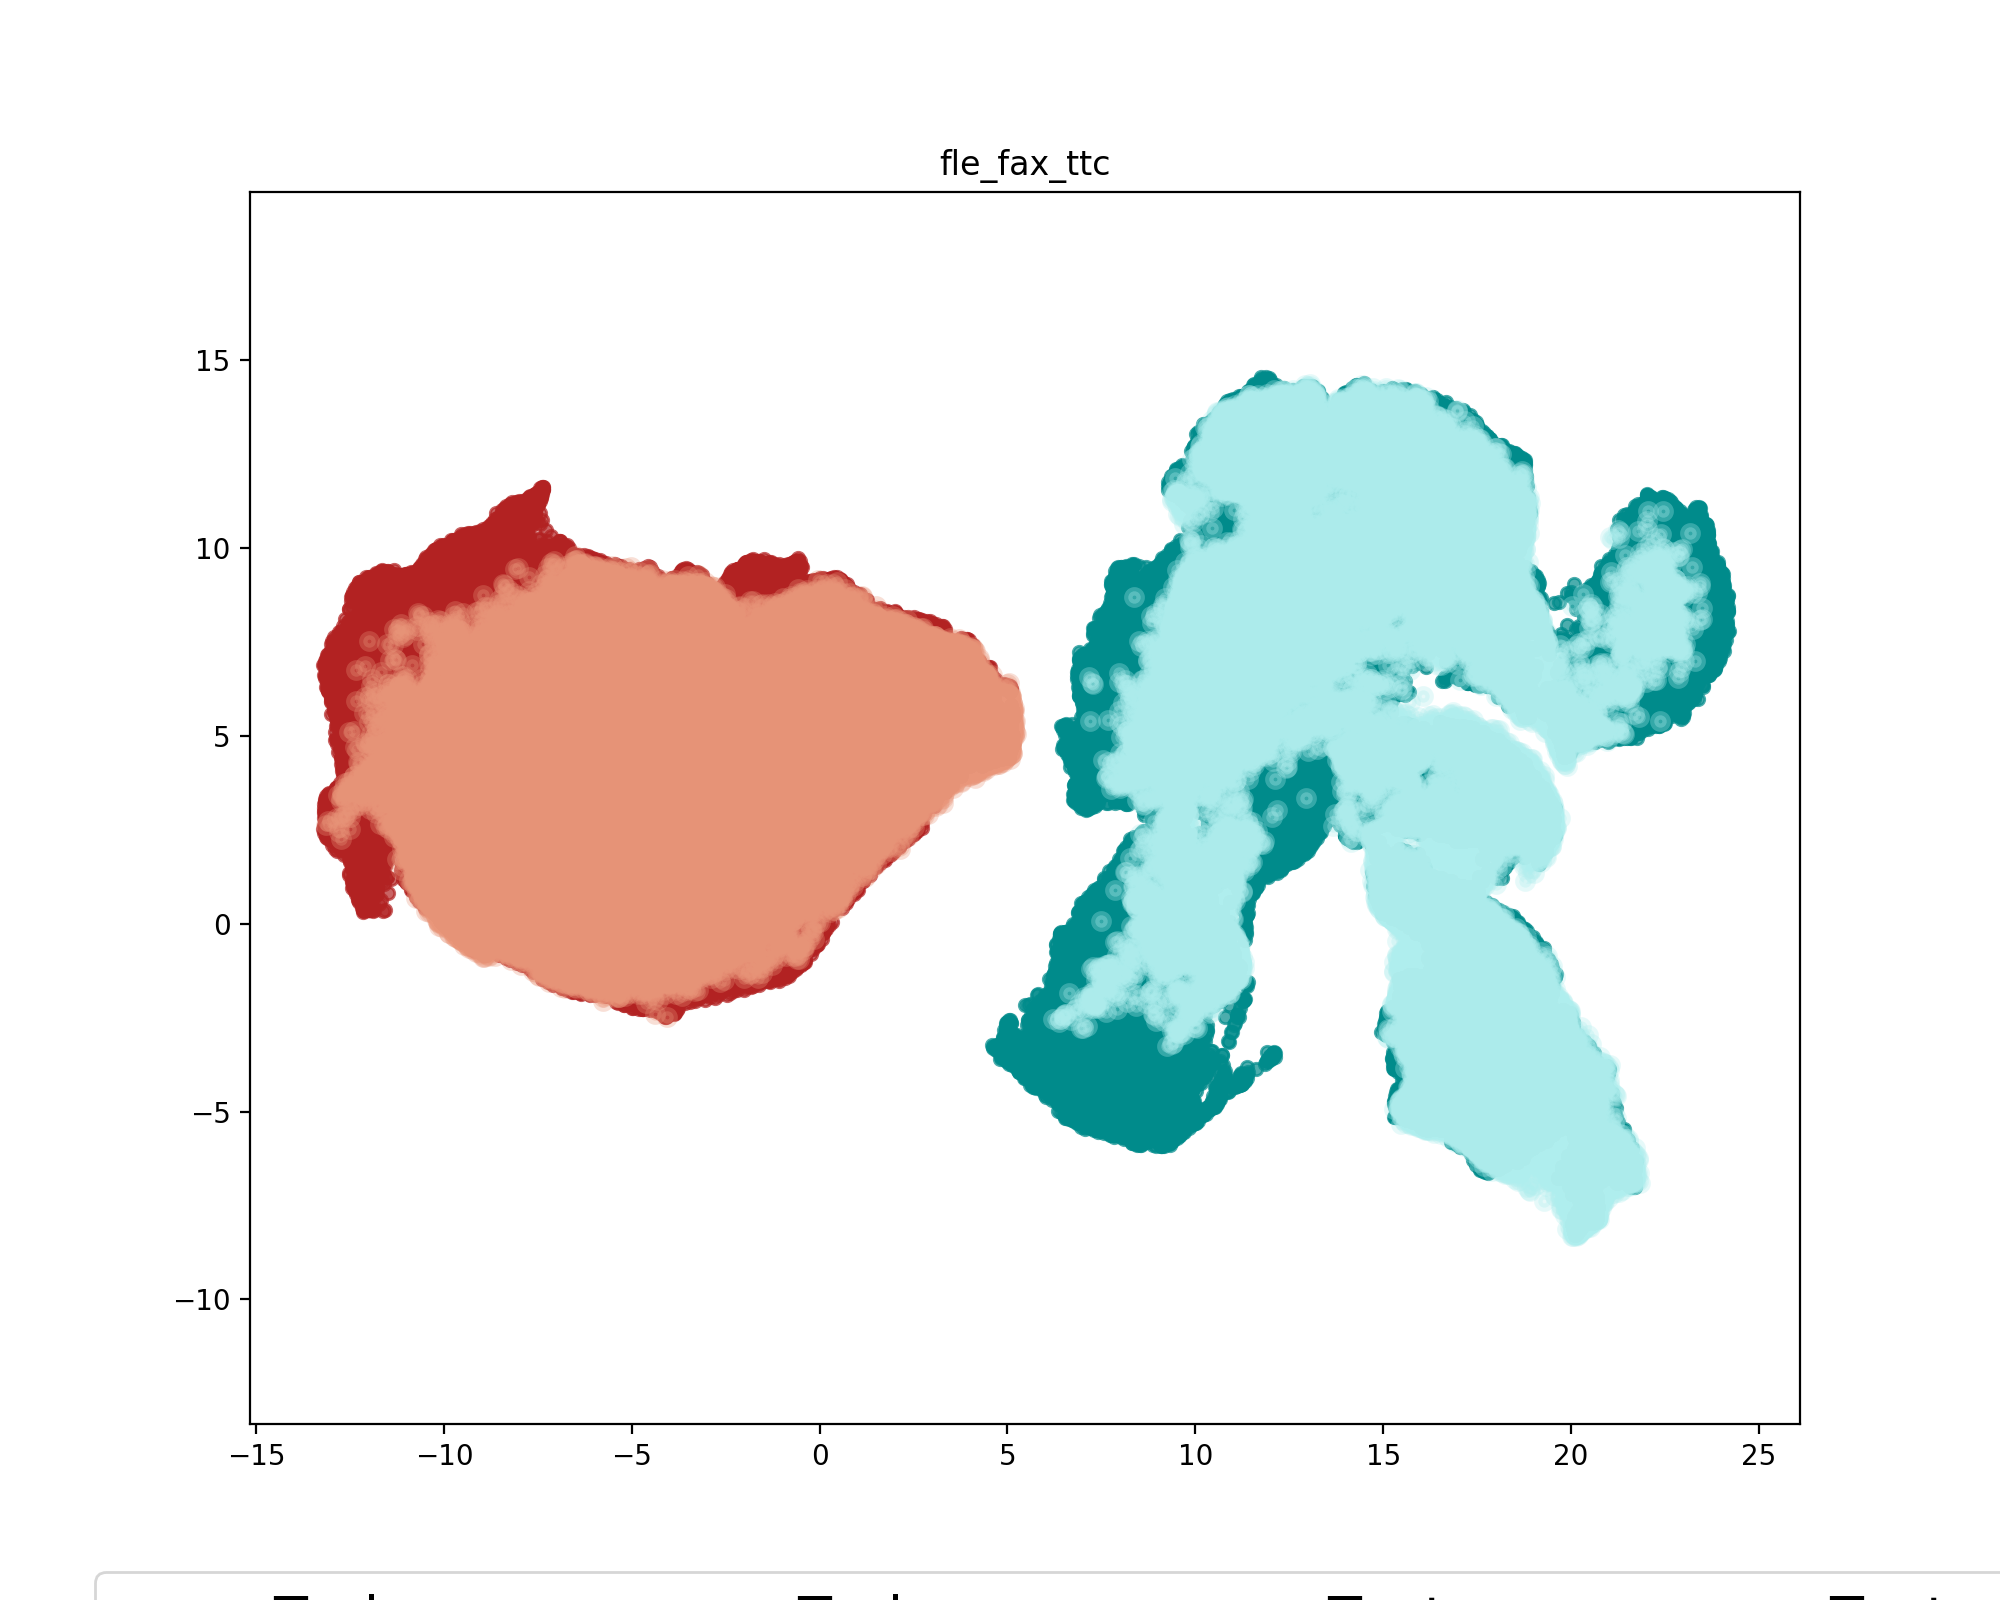

In [7]:
markers = [['fle', 'fax'], ['ftc', 'fle'], ['ftc', 'fle', 'fax'], ['fle', 'fax', 'ttc']]    
files = glob("pairs/*.npz")

dic_embeddings_pairs, dic_data_pairs = get_embeddings(files, feat='time', mode='s', n=20, dist=0.5, n_components=2, markers_concat=markers)

for key in dic_embeddings_pairs:
    embedding_train = dic_embeddings_pairs[key]["train"][:, 2:] 
    labels_train = dic_embeddings_pairs[key]["train"][:, 0]
    embedding_test = dic_embeddings_pairs[key]["test"][:, 2:] 
    labels_test = dic_embeddings_pairs[key]["test"][:, 0]
    print(key)
    plt.figure(figsize=(10, 8)) 
    idxs_train_pos = np.where(labels_train==1)[0]
    idxs_train_neg = np.where(labels_train==0)[0]
    plt.scatter(embedding_train[idxs_train_pos, 0], embedding_train[idxs_train_pos, 1], facecolors='darkcyan', s=20, alpha=0.7, label='Train pos')
    plt.scatter(embedding_train[idxs_train_neg, 0], embedding_train[idxs_train_neg, 1], facecolors='firebrick', s=20, alpha=0.7, label='Train neg')
    idxs_test_pos = np.where(labels_test==1)[0]
    idxs_test_neg = np.where(labels_test==0)[0]
    plt.scatter(embedding_test[idxs_test_pos, 0], embedding_test[idxs_test_pos, 1], facecolors='paleturquoise', linewidths=3, s=20, alpha=0.3, label='Test pos')
    plt.scatter(embedding_test[idxs_test_neg, 0], embedding_test[idxs_test_neg, 1], facecolors='darksalmon', linewidths=3, s=20, alpha=0.3, label='Test neg')
    plt.gca().set_aspect('equal', 'datalim')  
    plt.legend(loc=[-0.1, -0.2], ncol=4, fontsize=20, scatterpoints=10)
    plt.title(key)
